In [2]:
#!pip install -U scikit-learn
#!pip install -U charset-normalizer==2.1.0
#!pip install missingno
#!pip install scikeras

In [1]:
#libs
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import tensorflow as tf
import math
import statsmodels.api as sm
import copy
import datetime
import xgboost as xgb
import sklearn

#analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

#processing
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from pandas.tseries.offsets import DateOffset
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasRegressor

#metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error as mape

import os
import glob
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

tf.random.set_seed(111)

## Подготовка данных

### Загрузка и просмотр данных

In [2]:
path = r'C:\Users\1123\Desktop\st_forecasting\historical' 

files = os.listdir(path)
files_xls = [f for f in files if int(f[:4]) > 2014 ]
files_xls

df_from_each_file = (pd.read_excel(path + '\\' + f) for f in files_xls)

In [3]:
dfn = pd.concat(df_from_each_file, ignore_index=True).reset_index(drop=True)
dfn.head()

Subsegment Flight number IATA Airline type Airline short name  \
0    DOM INT       4G 9603   4G          Dom        Gazpromavia   
1    DOM INT       4G 9604   4G          Dom        Gazpromavia   
2    DOM INT       4G 9612   4G          Dom        Gazpromavia   
3    DOM INT       4G 9612   4G          Dom        Gazpromavia   
4    DOM INT       4G 9634   4G          Dom        Gazpromavia   

     Destination RAP_CODE        City Country ENG  Region Service type  \
0  International      SVQ     Sevilla       Spain  Europe            C   
1  International      SVQ     Sevilla       Spain  Europe            C   
2  International      LUX  Luxembourg  Luxembourg  Europe            C   
3  International      MHP       Minsk     Belarus     CIS            C   
4  International      RIX        Riga      Latvia  Europe            C   

      Actual time                Model  PAX Actual  MTOW Actual  \
0  15.04.15 11:19      BOEING B737-700         NaN       69.399   
1  17.04.15 07:11      BOEING B737-700         NaN          NaN   
2  29.09.15 00:38  DASSAULT FALCON 900         NaN          NaN   
3  21.08.15 13:53  DASSAULT FALCON 900         NaN          NaN   
4  15.08.15 16:22      BOEING B737-700         NaN          NaN   

   Departure ATM Actual  SEATS Actual  
0                   1.0         120.0  
1                   NaN         120.0  
2                   NaN          14.0  
3                   NaN          14.0  
4                   NaN         120.0

In [4]:
dfn.shape

(1058033, 17)

In [5]:
dfn.duplicated().sum()

0

In [6]:
dfn.isna().sum()

Subsegment                   0
Flight number               21
IATA                     17081
Airline type              7204
Airline short name        3942
Destination                  0
RAP_CODE                     9
City                        40
Country ENG                 17
Region                    1932
Service type                21
Actual time                  0
Model                     2412
PAX Actual                1382
MTOW Actual             528905
Departure ATM Actual    528905
SEATS Actual               206
dtype: int64

<Axes: >

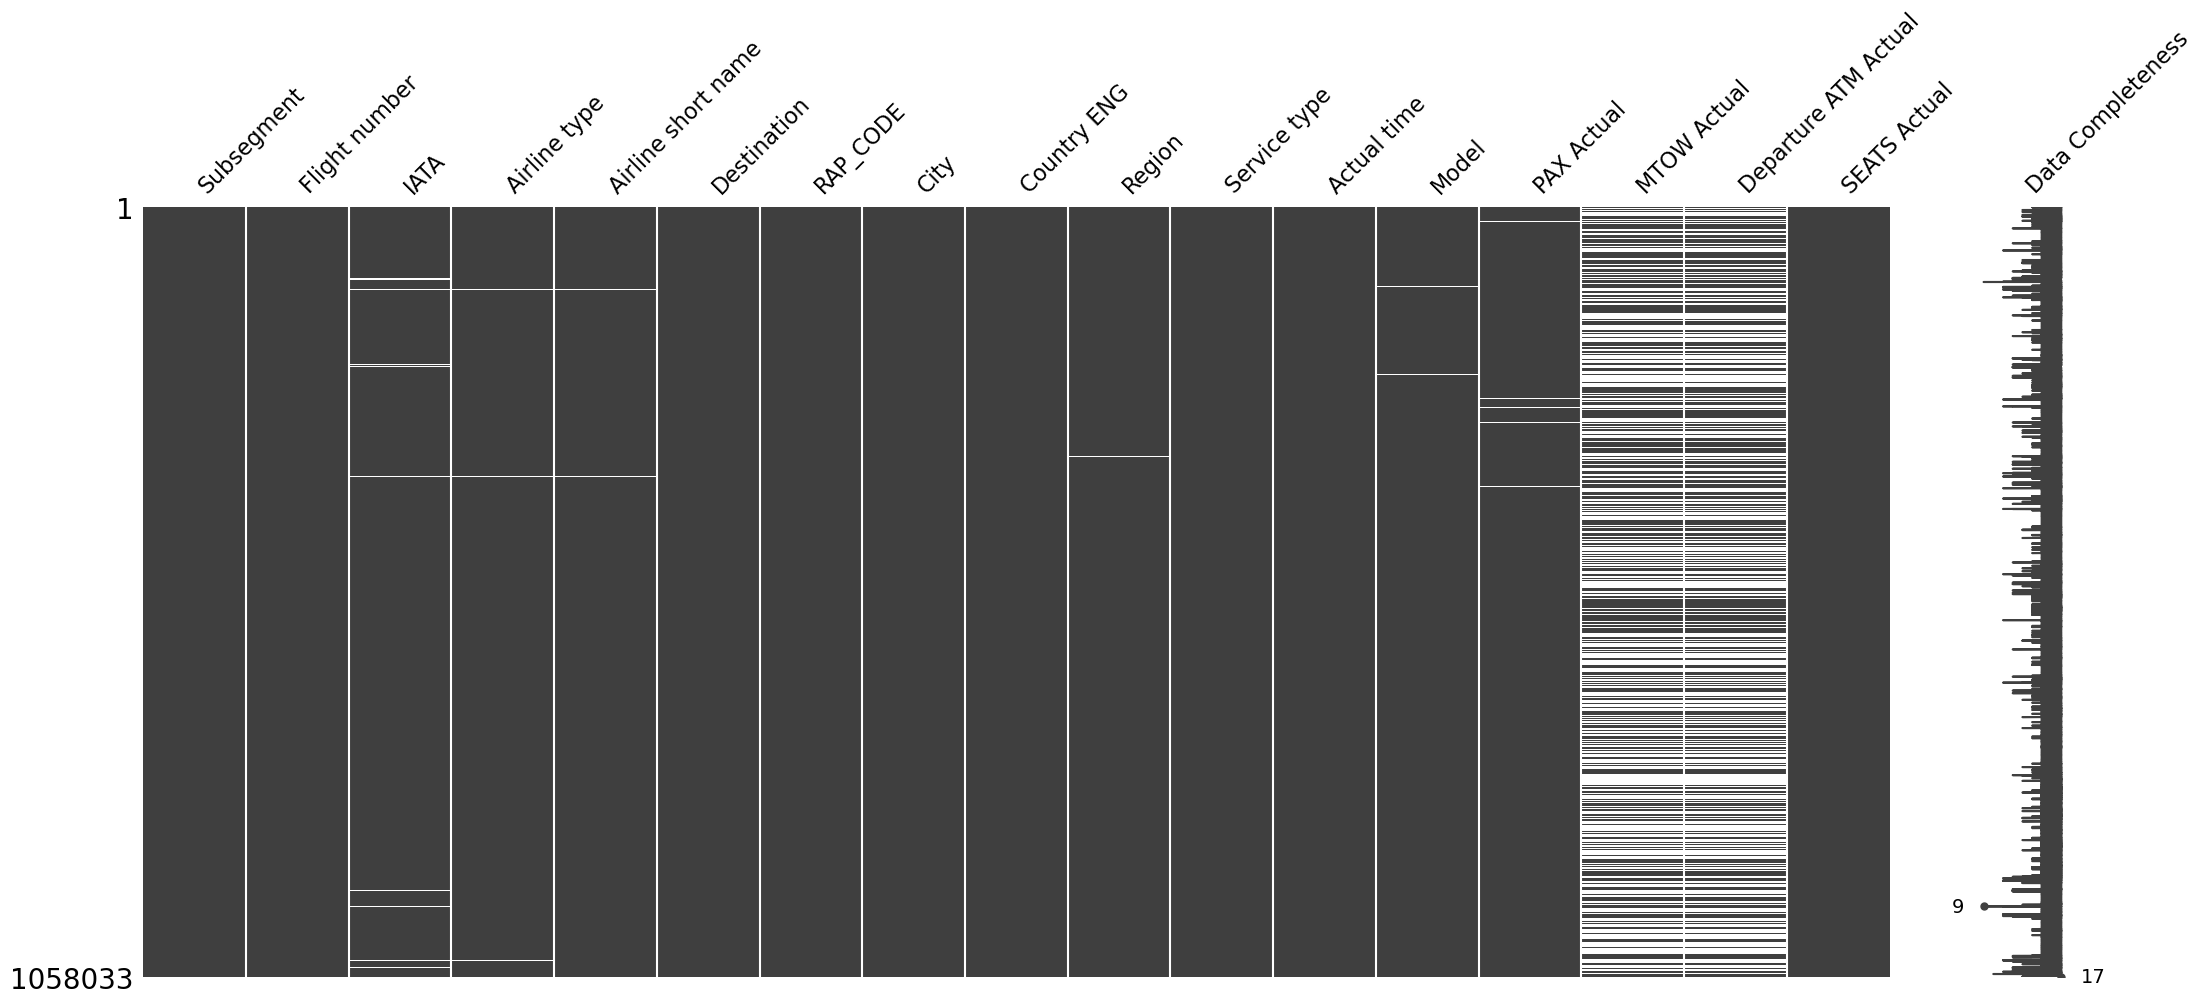

In [7]:
msno.matrix(dfn, labels=True)

Как можно увидеть, данных достаточно много, дубликаты отсутствуют, а с пропусками нужно будет работать. В колонках MTOW и ATM показатели отображены только для рейсов на вылет, наблюдения с пропусками в данных столбцах необходимо удалить и обрабатывать пропуски далее в данных исключительно рейсов из Пулково. Аналогично с PAX - необходимы наблюдения с известным количеством пассажиров для прогноза.

Пропуски в IATA не так важны - задача заключается в построении краткосрочного прогноза по направлениям, без связок с авиакомпаниями.

### Удаление пропусков

In [8]:
dfn = dfn.dropna(subset = ['MTOW Actual', 'PAX Actual']).reset_index(drop=True)

Также удаляются пропуски и нули в показателе кол-ва посадочных мест в самолете - этот столбец необходим для дальнейших расчетов.

In [9]:
dfn = dfn.dropna(subset = ['SEATS Actual']).reset_index(drop=True)
dfn = dfn.drop(dfn[dfn['SEATS Actual'] == 0].index).reset_index(drop=True)

In [10]:
dfn.isna().sum()

Subsegment                 0
Flight number              0
IATA                    8222
Airline type            3398
Airline short name      1928
Destination                0
RAP_CODE                   1
City                      14
Country ENG                3
Region                   828
Service type               0
Actual time                0
Model                   1170
PAX Actual                 0
MTOW Actual                0
Departure ATM Actual       0
SEATS Actual               0
dtype: int64

<Axes: >

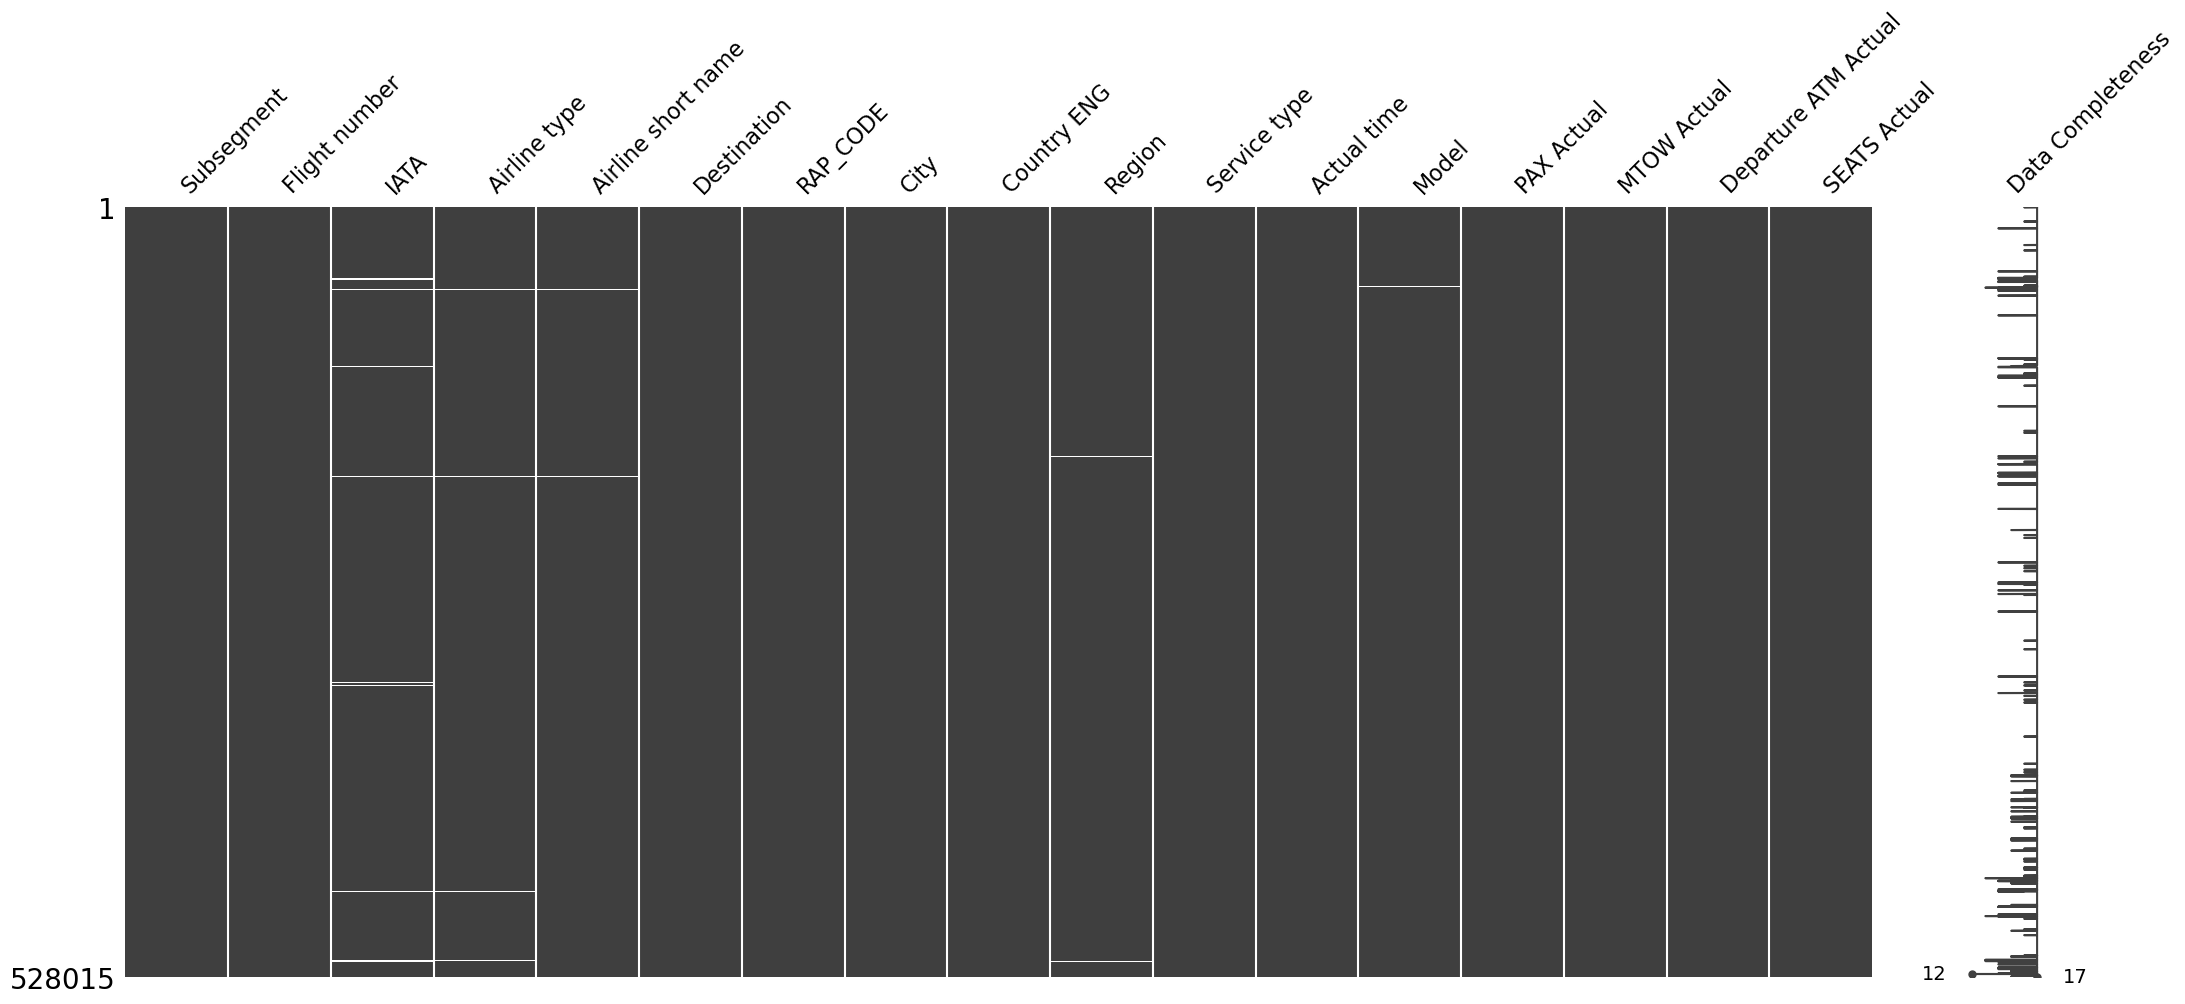

In [11]:
msno.matrix(dfn, labels=True)

В столбцах, необходимых для дальнейшей работы нет пропусков, далее проиводится обработка данных.

### Обработка данных

Необходимо создать столбец с рассчитаным LF, для этого нужно разделить реальное кол-во пассажиров на кол-во мест на воздушном судне.

In [12]:
dfn['LF'] = dfn['PAX Actual']/dfn['SEATS Actual']*100

In [13]:
dfn.head()

Subsegment Flight number IATA Airline type Airline short name  \
0    DOM INT       5N 9215   5N          Dom          Smartavia   
1    DOM INT       5N 9221   5N          Dom          Smartavia   
2    DOM INT       5N 9241   5N          Dom          Smartavia   
3    DOM INT       5N 9241   5N          Dom          Smartavia   
4    DOM INT       5N 9241   5N          Dom          Smartavia   

     Destination RAP_CODE       City Country ENG  Region Service type  \
0  International      BCN  Barcelona       Spain  Europe            C   
1  International      HEL   Helsinki     Finland  Europe            C   
2  International      BOJ    Bourgas    Bulgaria  Europe            C   
3  International      BOJ    Bourgas    Bulgaria  Europe            C   
4  International      BOJ    Bourgas    Bulgaria  Europe            C   

      Actual time            Model  PAX Actual  MTOW Actual  \
0  17.03.15 09:58  BOEING B737-500        94.0       61.688   
1  31.01.15 00:39  BOEING B737-500        38.0       60.554   
2  14.07.15 10:56  BOEING B737-500       125.0       60.554   
3  28.07.15 11:25  BOEING B737-500       110.0       60.554   
4  01.08.15 11:00  BOEING B737-500       107.0       60.554   

   Departure ATM Actual  SEATS Actual         LF  
0                   1.0         189.0  49.735450  
1                   1.0         135.0  28.148148  
2                   1.0         135.0  92.592593  
3                   1.0         135.0  81.481481  
4                   1.0         135.0  79.259259

Далее столбец с датой переводится в формат datetime для того, чтобы работать с ним не как со строкой, а совершать операции именно типа даты.

In [14]:
dfn['Actual time'] = pd.to_datetime(dfn['Actual time'], format="%d.%m.%y %H:%M")

Проверка на выбросы.

In [15]:
dfn.describe()

PAX Actual    MTOW Actual  Departure ATM Actual   SEATS Actual  \
count  528015.000000  528015.000000         528015.000000  528015.000000   
mean      119.941502      73.747153              1.000206     151.366368   
std        58.443654      38.634397              0.014757      62.791149   
min         0.000000       0.000000              0.000000       1.000000   
25%        84.000000      70.000000              1.000000     128.000000   
50%       119.000000      70.000000              1.000000     144.000000   
75%       153.000000      77.000000              1.000000     180.000000   
max       816.000000     575.000000              2.000000    1566.000000   

                  LF  
count  528015.000000  
mean       81.321510  
std        49.383839  
min         0.000000  
25%        66.406250  
50%        85.443038  
75%        95.238095  
max       950.000000

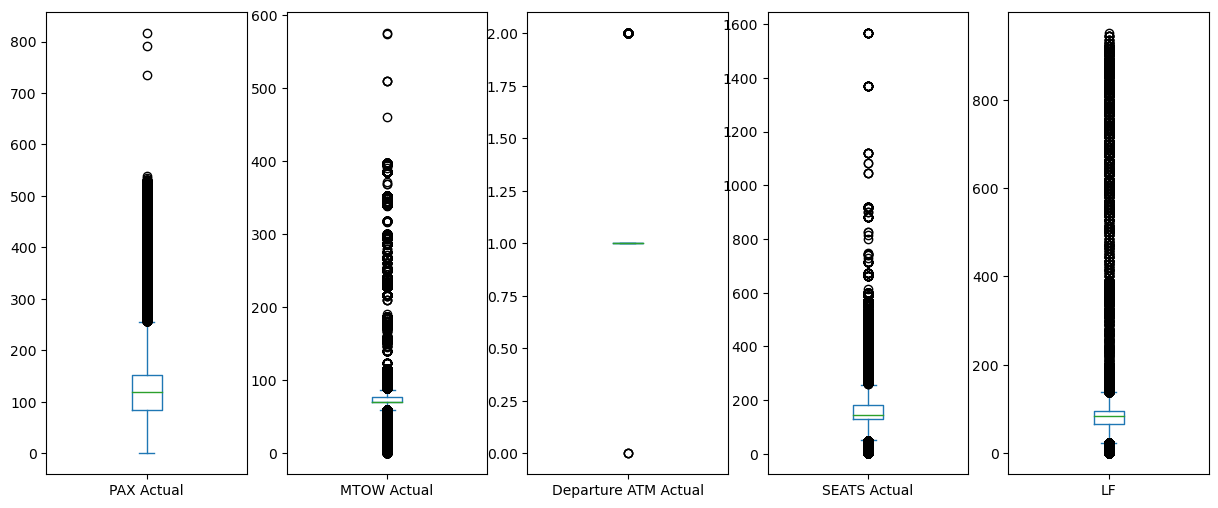

In [16]:
dfn.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(15, 6)
);

Можно заметить:

   1. Выбросы в значениях PAX, SEATS и MTOW (большие значения, которые не соответствуют реальности) 
   2. Выбросы в LF (слишком маленькая загрузка)
   3. Ошибки в заполнении ATM (несколько наблюдений с цифрой 2 и 0)

Самый большой самолет в мире имеет 853 пассажирских места в одноклассной компоновке. В Пулково он был в 2018 году и после в трехклассной компоновке с максимальной вместимостью 519, также упоминалась 4х-классная компоновка с 575 пассажирскими местами https://pulkovoairport.ru/about/press_center/news/9657/#:~:text=%D0%90%D1%8D%D1%80%D0%BE%D0%BF%D0%BE%D1%80%D1%82%20%D0%9F%D1%83%D0%BB%D0%BA%D0%BE%D0%B2%D0%BE%2025%20%D0%BE%D0%BA%D1%82%D1%8F%D0%B1%D1%80%D1%8F%202018,Airbus%20A380%2D800%20%D0%B0%D0%B2%D0%B8%D0%B0%D0%BA%D0%BE%D0%BC%D0%BF%D0%B0%D0%BD%D0%B8%D0%B8%20%D0%AD%D0%BC%D0%B8%D1%80%D0%B5%D0%B9%D1%82%D1%81, все значения выше 575 вероятно являеюся технической ошибкой. Возможно, за один рейс было посчитано несколько. Всего таких наблюдений 286 из более чем полумиллиона, стоит избавиться от них.

In [17]:
dfn[dfn['SEATS Actual'] > 575]['SEATS Actual'].count()

286

Аналогично с реальной загрузкой пассажиров. Значений больше 575 всего 3, но их стоит убрать.

In [18]:
dfn[dfn['PAX Actual'] > 575]['PAX Actual'].count()

3

Аналогично с MTOW, так как в данном проекте учитываются только пассажироперевозки, т.е. грузовые рейсы отсутствуют, то показатель стоит оставить максимум взлетной массы большого пассажирского судна. Максимальная взлётная масса Airbus A380 — 560 тонн, значения выше будут удалены

In [19]:
dfn[dfn['MTOW Actual'] > 560]['MTOW Actual'].count()

2

In [20]:
dfn = dfn.drop(dfn[dfn['SEATS Actual'] > 575].index).reset_index(drop=True)
dfn = dfn.drop(dfn[dfn['PAX Actual'] > 575].index).reset_index(drop=True)
dfn = dfn.drop(dfn[dfn['MTOW Actual'] > 560].index).reset_index(drop=True)

Далее необходимо понять сколько ошибок в индикаторе взлетно-посадочной операции. Всего 113, стоит убрать их из датасета.


In [21]:
dfn[dfn['Departure ATM Actual'] != 1]['Departure ATM Actual'].count()

113

In [22]:
dfn = dfn.drop(dfn[dfn['Departure ATM Actual'] != 1].index).reset_index(drop=True)

Наблюдения со значением LF > 100 будут удалены, т.к. количество пассажиров превышающее количество посадочных мест невозможно и такие наблюдения скорее всего возникли по технической ошибке. LF < 20 также маловероятен - это либо техническая ошибка, либо аномалия, т.к. обычно при экстремально низкой загрузке рейса он не производится.

In [23]:
dfn = dfn.drop(dfn[dfn['LF'] < 20].index).reset_index(drop=True)
dfn = dfn.drop(dfn[dfn['LF'] > 100].index).reset_index(drop=True)

В итоге ящики с усами выглядят следующим образом. В данной ситуации, когда важна целостность временного ряда, по статистическим метрикам, например, межквартильному расстоянию, выбросы не удаляются. 

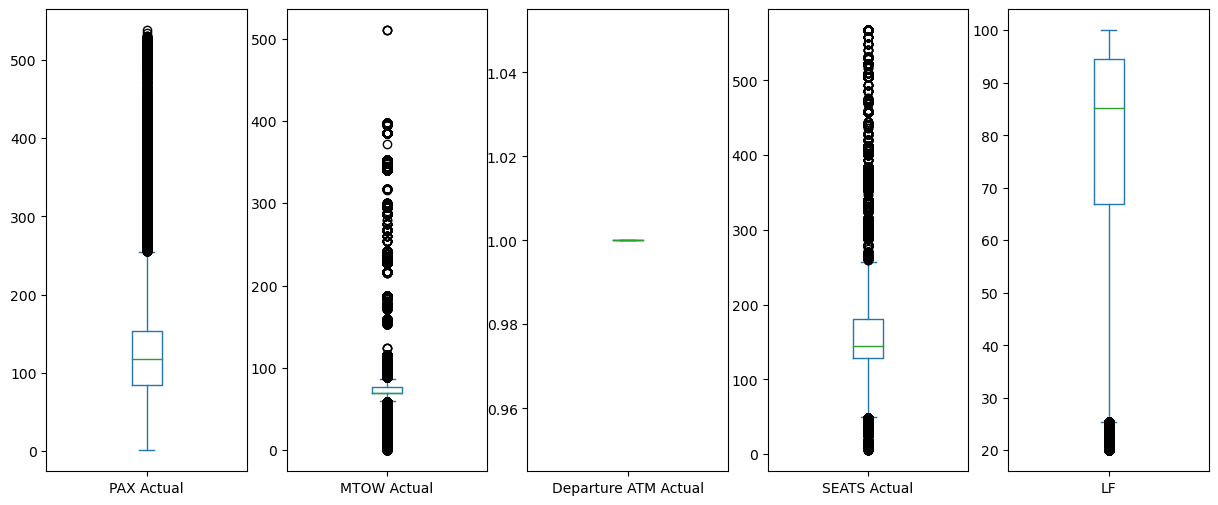

In [24]:
dfn.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(15, 6)
);

In [25]:
dfn.shape

(502346, 18)

### Деление по сегментам

Переименование столбцов на названия метрик, создание словарей с названиями метрик и сегментов для дальнейшего упрощения работы со структурами данных. 

In [26]:
dfn = dfn.rename(columns={'PAX Actual': 'PAX', 'MTOW Actual': 'MTOW', 'Departure ATM Actual': 'ATM', 
                        'Actual time': 'Time'})
coll = ['PAX', 'MTOW', 'LF', 'ATM']
seg = ['DOM INT', 'DOM MOW', 'DOM REG', 'INT BEL', 'INT OTH', 'INT LCC']

Деление в разрезе сегментов обусловлено тем, что поведение сегментов может отличаться, например сезонность в московском направлении может быть больше выражена недельно, а в интернациональных - годично. Также на некоторых направлениях меньше данных (INT OTH начинает отсчет от 2017 года), что тоже необходимо учесть при обучении моделей.

In [27]:
dict_all = {} #словарь с датафреймами 

for j in range (0, 6):
    dict_all[seg[j]] = {}
    for i in range(0, 2):
        dict_all[seg[j]][coll[i]] = dfn[dfn['Subsegment'] == seg[j]][['Time', coll[i]]].resample('D', on= 'Time')\
                                                                .apply({coll[i]  : 'sum'}).reset_index()
    dict_all[seg[j]]['LF'] = dfn[dfn['Subsegment'] == seg[j]][['Time', 'LF']].resample('D', on= 'Time')\
                                                                .apply({'LF'  : 'mean'}).reset_index()     
    dict_all[seg[j]]['ATM'] = dfn[dfn['Subsegment'] == seg[j]][['Time', 'ATM']].resample('D', on= 'Time')\
                                                                .apply({'ATM'  : 'count'}).reset_index()

In [28]:
n = pd.DataFrame(index = coll, columns = seg)
for j in range (0, 6):
    for i in range(0, 4):
        n[seg[j]][coll[i]] = len(dict_all[seg[j]][coll[i]])

In [29]:
n

DOM INT DOM MOW DOM REG INT BEL INT OTH INT LCC
PAX     2903    2903    2903    2903    2903    1645
MTOW    2903    2903    2903    2903    2903    1645
LF      2903    2903    2903    2903    2903    1645
ATM     2903    2903    2903    2903    2903    1645

In [36]:
import datetime as dt
display(dfn[dfn['Time'].dt.date >= dt.date(2022, 1, 1)]['PAX'].sum())
dict_all[seg[2]]['PAX'][dict_all[seg[2]]['PAX']['Time'].dt.date >= dt.date(2022, 1, 1)]['PAX'].sum()

8382427.0

5245849.0

Для предварительного анализа создаются словари по 4 прогнозируемым метрикам, в которых находятся датафреймы по 6 сегментам

In [31]:
dfn['Subsegment'].unique()

array(['DOM INT', 'DOM MOW', 'DOM REG', 'INT BEL', 'INT OTH', 'INT LCC'],
      dtype=object)

In [32]:
#деление на датафреймы по сегментам, сборка в данные по дням
dict_LF = {} #словарь с датафреймами LF по сегментам
dict_MTOW = {} #словарь с датафреймами MTOW по сегментам
dict_ATM = {} #словарь с датафреймами ATM по сегментам
dict_PAX = {} #словарь с датафреймами PAX по сегментам

for i in range(1,7):
    dict_LF["{}".format(dfn['Subsegment'].unique()[i-1])] = dfn[(dfn['Subsegment'] == dfn['Subsegment'].unique()[i-1])]\
                                                            .resample('D', on= 'Time')\
                                                            .apply({'LF'  : 'mean'}).reset_index()
    dict_MTOW["{}".format(dfn['Subsegment'].unique()[i-1])] = dfn[(dfn['Subsegment'] == dfn['Subsegment'].unique()[i-1])]\
                                                            .resample('D', on= 'Time')\
                                                            .apply({'MTOW'  : 'mean'}).reset_index()                                                        
    dict_ATM["{}".format(dfn['Subsegment'].unique()[i-1])] = dfn[(dfn['Subsegment'] == dfn['Subsegment'].unique()[i-1])]\
                                                            .resample('D', on= 'Time')\
                                                            .apply({'ATM'  : 'count'}).reset_index()
    dict_PAX["{}".format(dfn['Subsegment'].unique()[i-1])] = dfn[(dfn['Subsegment'] == dfn['Subsegment'].unique()[i-1])]\
                                                            .resample('D', on= 'Time')\
                                                            .apply({'PAX'  : 'mean'}).reset_index()

## Анализ данных

Перед обучением моделей данные будут рассмотрены чуть ближе. Из предобработки данных уже можно сделать выводы о том, как распределены значения прогнозируемых переменных, 

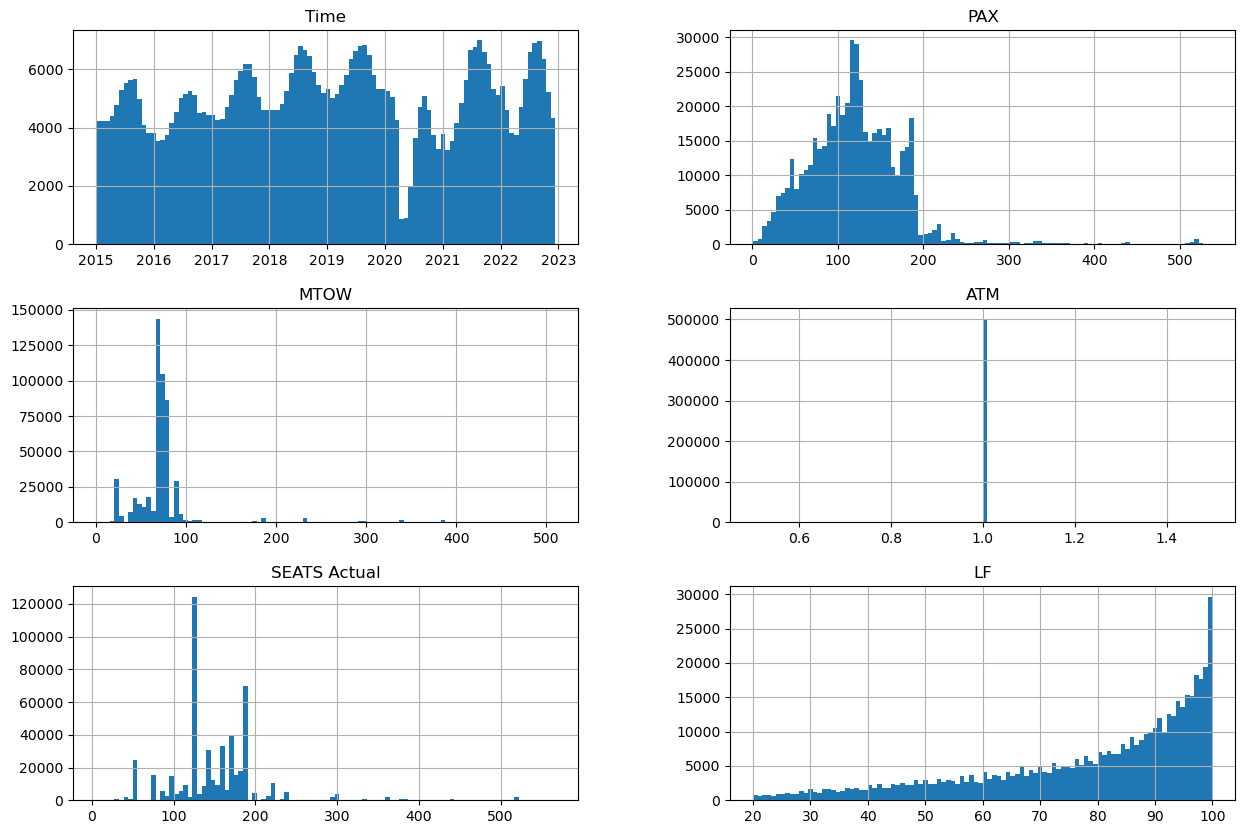

In [32]:
dfn.hist(figsize=(15, 10), bins = 100);

In [33]:
dict_all[seg[5]][coll[3]]

Time  ATM
0    2017-08-27    1
1    2017-08-28    0
2    2017-08-29    0
3    2017-08-30    1
4    2017-08-31    0
...         ...  ...
1640 2022-02-22    0
1641 2022-02-23    1
1642 2022-02-24    0
1643 2022-02-25    0
1644 2022-02-26    1

[1645 rows x 2 columns]

In [35]:
for j in range (0, 6):
    adf = pd.DataFrame(columns = coll, index = dict_all[seg[j]]['PAX']['Time'])
    for i in range(0, 4):
        df = dict_all[seg[j]][coll[i]]
        adf[coll[i]] = list(df[coll[i]])
        
    print('\n', seg[j])
    display(adf.describe())


 DOM INT


PAX         MTOW           LF          ATM
count  2903.000000  2903.000000  2784.000000  2903.000000
mean   2963.366862  1812.001108    78.489074    19.901137
std    2088.540109  1217.162244    12.259296    11.984234
min       0.000000     0.000000    25.000000     0.000000
25%    1273.500000   867.945500    70.846145    10.000000
50%    2546.000000  1657.045000    80.684095    20.000000
75%    4381.500000  2575.962500    87.725290    29.000000
max    8770.000000  5017.819000   100.000000    51.000000


 DOM MOW


PAX         MTOW           LF          ATM
count   2903.000000  2903.000000  2903.000000  2903.000000
mean    5468.737513  3354.655706    77.742717    44.445401
std     1536.225627   769.933418    11.006855     9.982257
min      106.000000   111.600000    30.992662     3.000000
25%     4579.500000  2928.485000    71.182094    39.000000
50%     5581.000000  3498.535000    78.929337    46.000000
75%     6420.000000  3840.868500    86.322760    51.000000
max    12093.000000  6993.213000    98.169066    89.000000


 DOM REG


PAX          MTOW           LF          ATM
count   2903.000000   2903.000000  2903.000000  2903.000000
mean    9454.829831   5550.301326    77.217370    83.045470
std     4656.966747   2163.983079     9.339299    29.106082
min      746.000000    610.011000    41.526687     9.000000
25%     6097.500000   4015.660000    71.162711    64.000000
50%     8399.000000   5088.022000    78.171431    77.000000
75%    11573.000000   6528.970000    84.313192    94.000000
max    24115.000000  12041.012000    96.557228   169.000000


 INT BEL


PAX         MTOW           LF          ATM
count  2903.000000  2903.000000  2386.000000  2903.000000
mean    253.952463   167.579364    71.837527     3.066138
std     154.447511    91.786982    14.631148     1.597864
min       0.000000     0.000000    25.572716     0.000000
25%     163.000000   126.370000    60.924199     3.000000
50%     275.000000   197.028000    72.657217     4.000000
75%     361.000000   236.675000    83.702161     4.000000
max     837.000000   400.247000   100.000000     6.000000


 INT OTH


PAX         MTOW           LF          ATM
count  2903.000000  2903.000000  2804.000000  2903.000000
mean   2658.229762  1847.135658    73.660034    22.312435
std    1742.286054  1130.854661    11.262645    13.468492
min       0.000000     0.000000    24.616060     0.000000
25%    1262.500000   973.939000    65.814895    10.000000
50%    2413.000000  1821.000000    74.844454    23.000000
75%    3940.000000  2622.000000    82.752783    33.000000
max    7353.000000  5263.000000    99.621212    58.000000


 INT LCC


PAX         MTOW          LF          ATM
count  1645.000000  1645.000000  683.000000  1645.000000
mean     84.857751    38.372036   84.414024     0.482067
std     109.412351    49.607408   12.941330     0.619395
min       0.000000     0.000000   22.608696     0.000000
25%       0.000000     0.000000   79.885266     0.000000
50%       0.000000     0.000000   87.222222     0.000000
75%     176.000000    83.000000   93.345411     1.000000
max     449.000000   178.000000  100.000000     2.000000

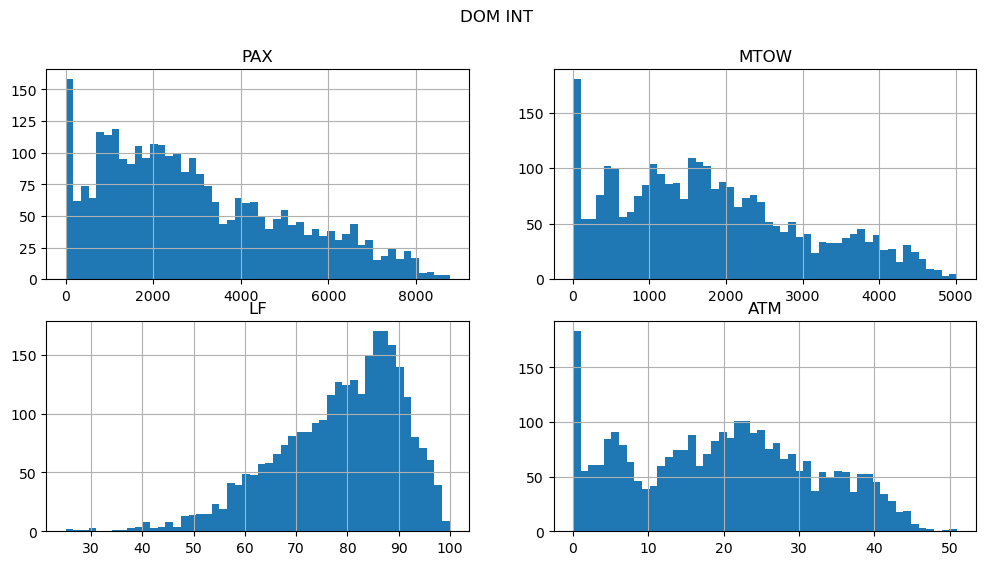

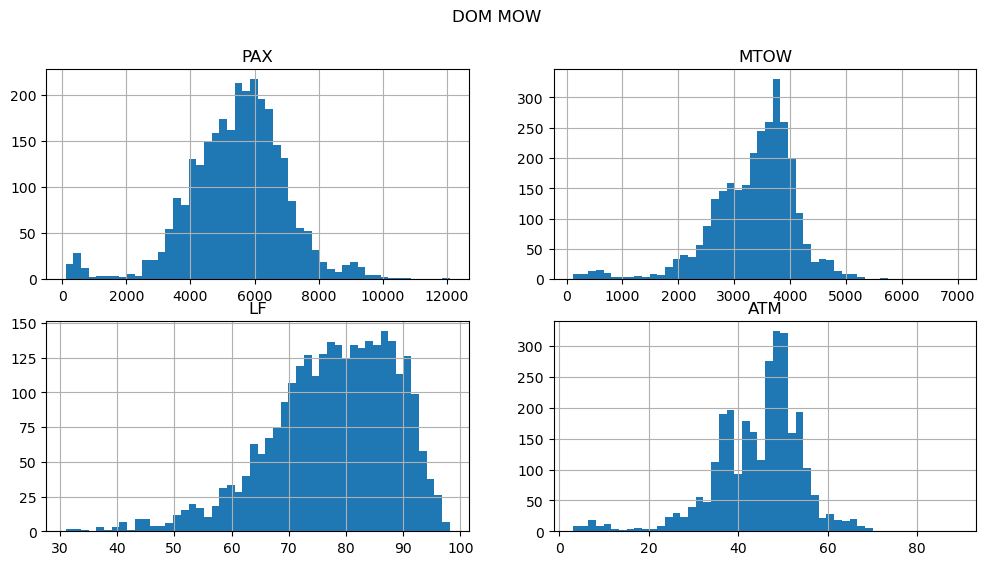

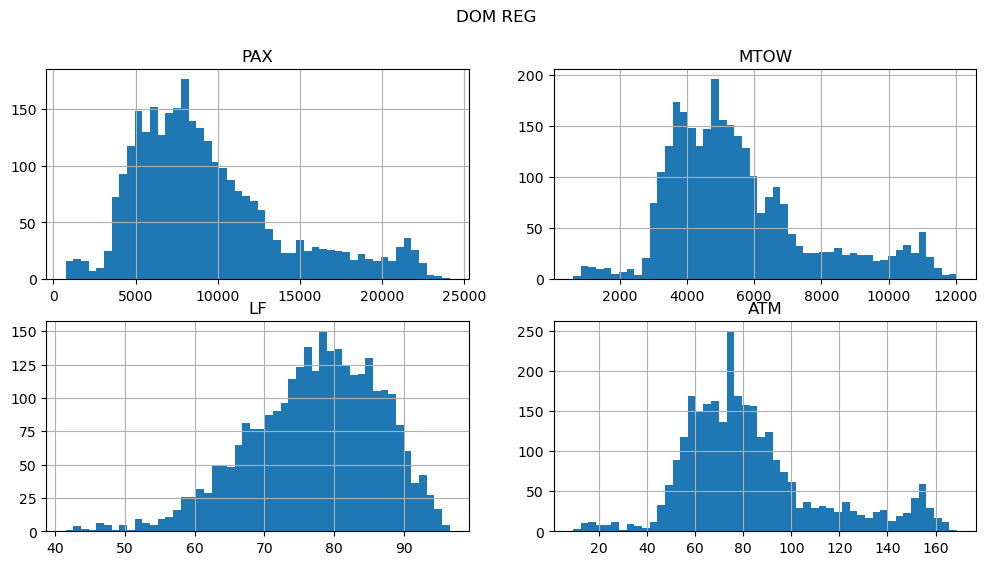

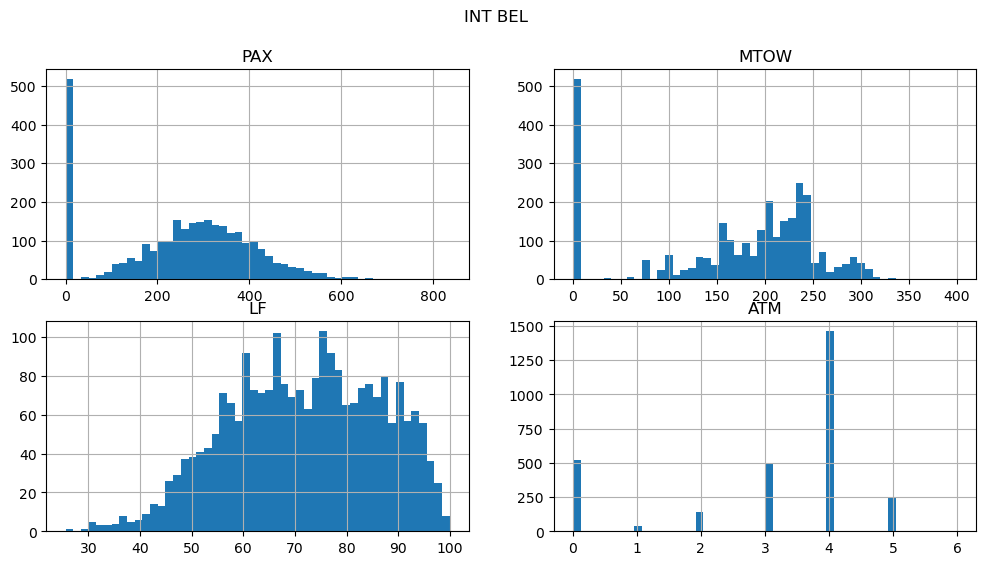

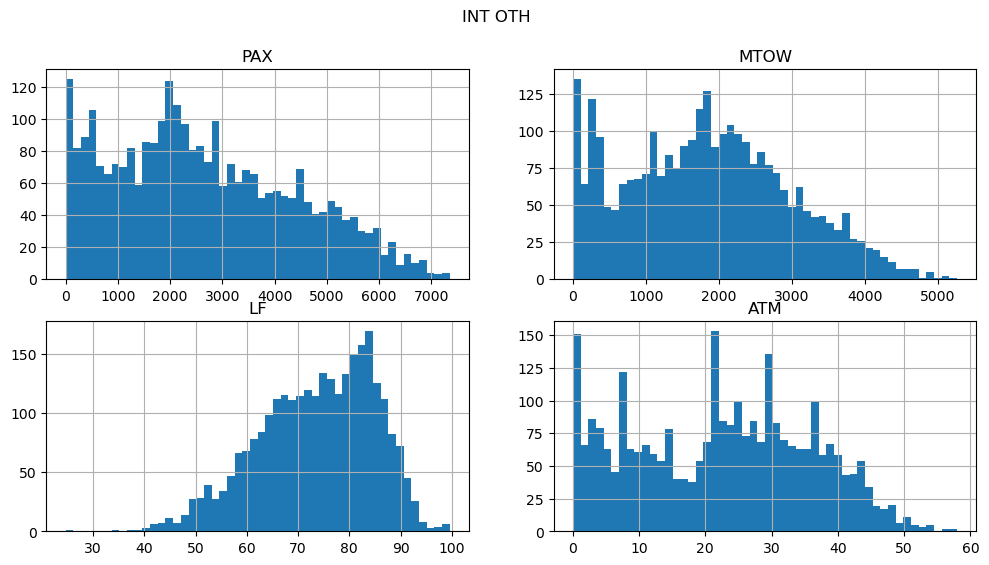

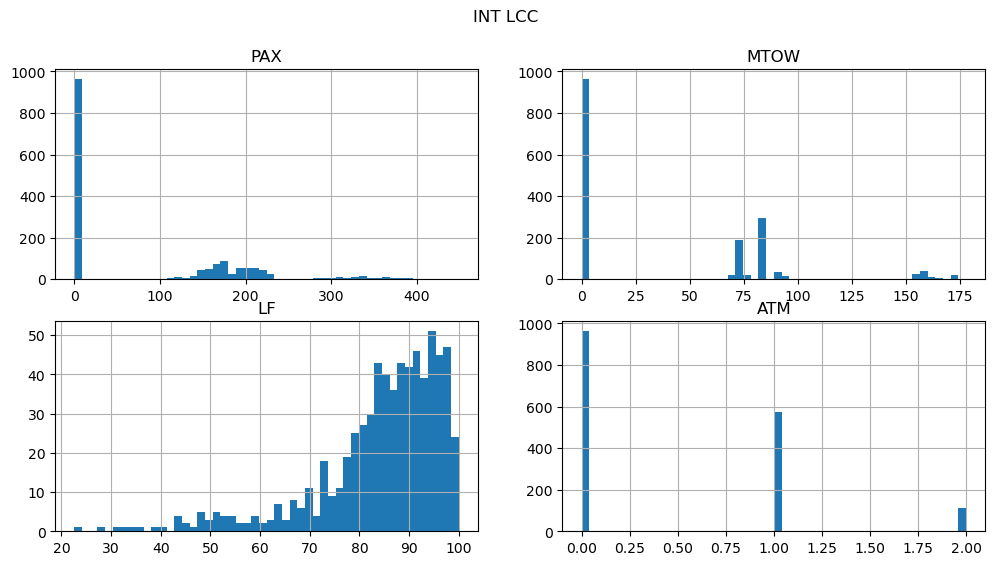

In [36]:
for i in range(0, 6):
    figure, axis = plt.subplots(2, 2, figsize = (12,6))
    k = 0
    d = 0
    for j in range (0, 4):
        axis[k, d].hist(dict_all[seg[i]][coll[j]][coll[j]], bins=50)
        axis[k, d].set_title(coll[j])
        axis[k, d].grid()
        d +=1
        if d > 1:
            k +=1
            d = 0
    figure.suptitle(seg[i])
    

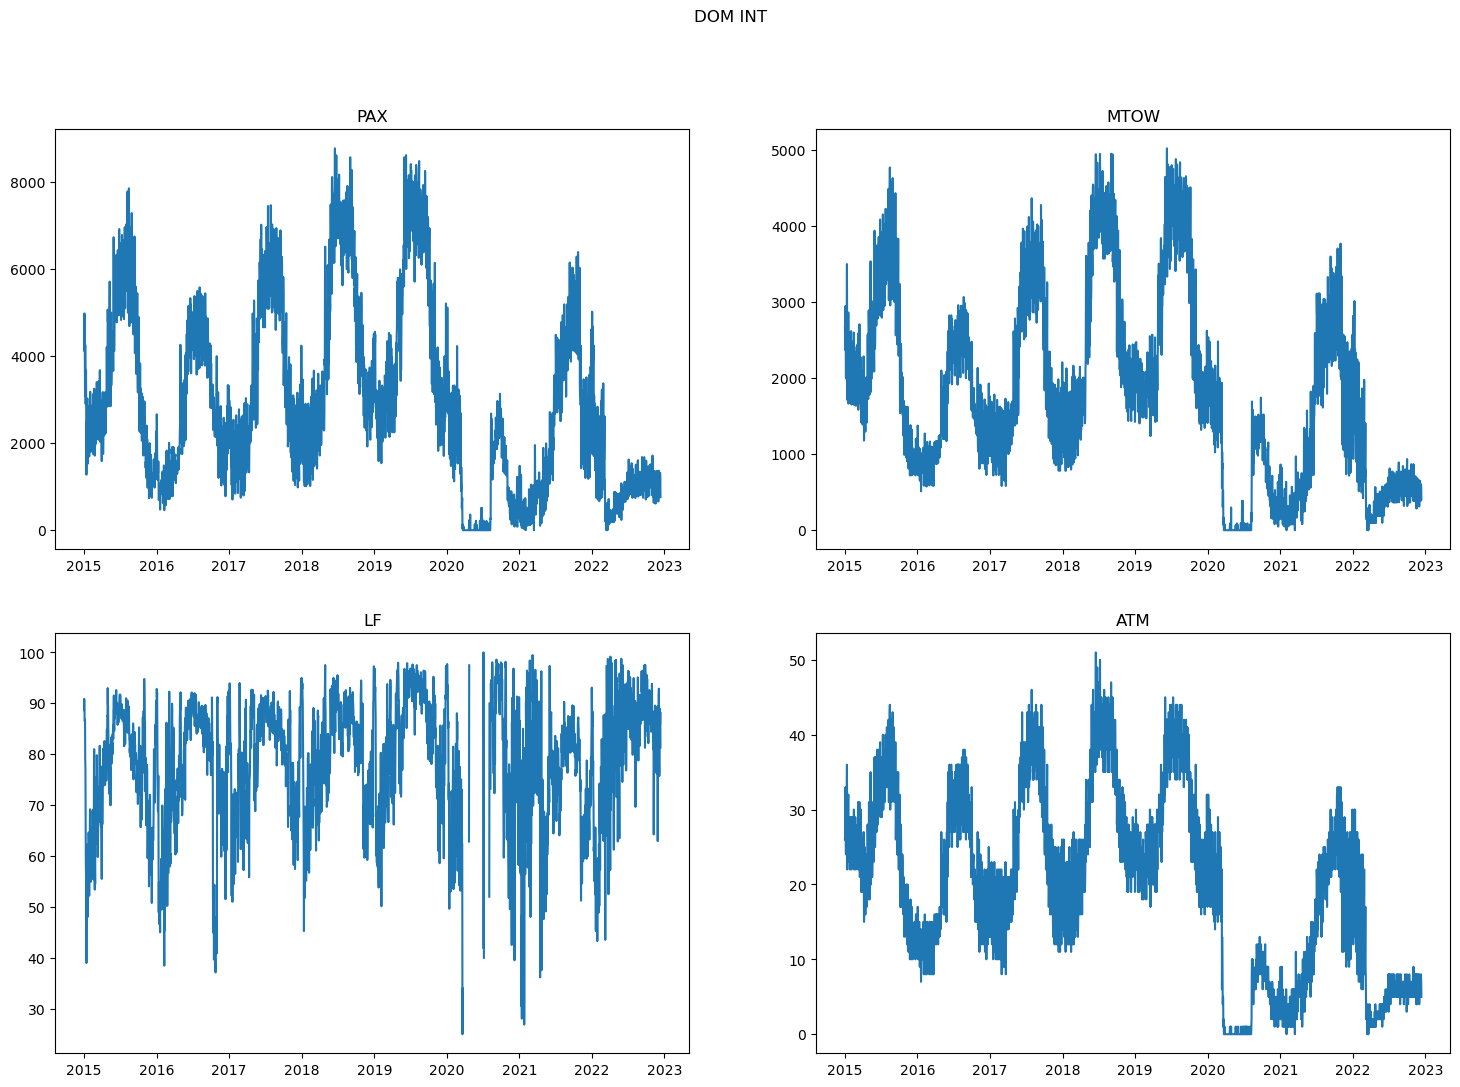

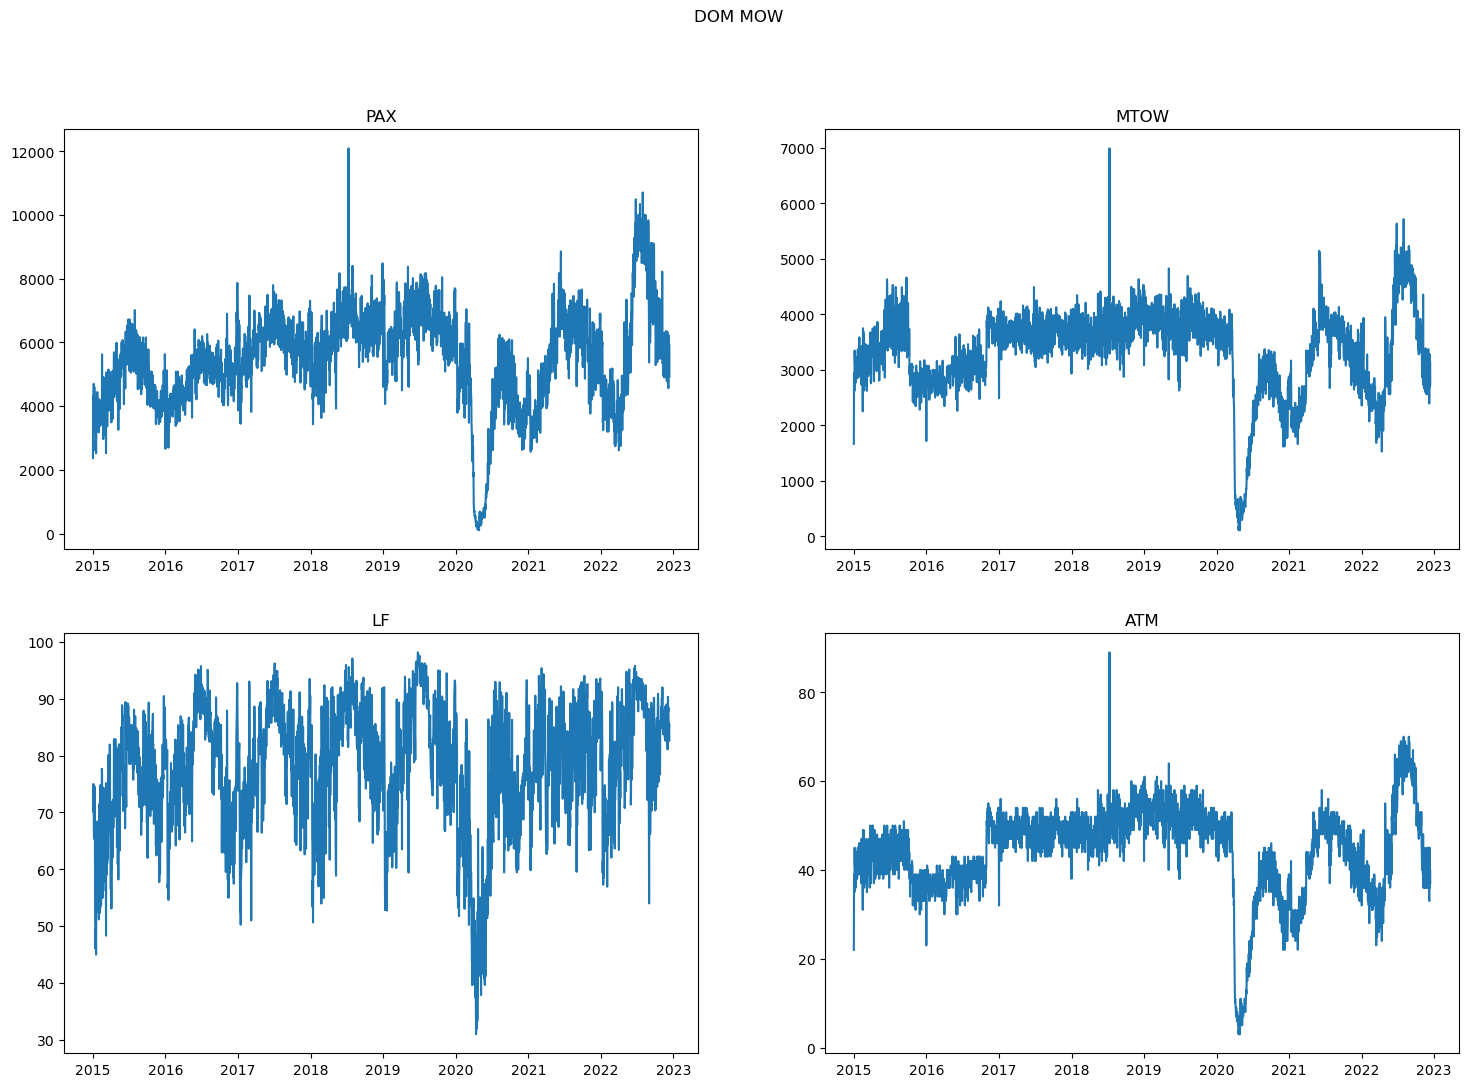

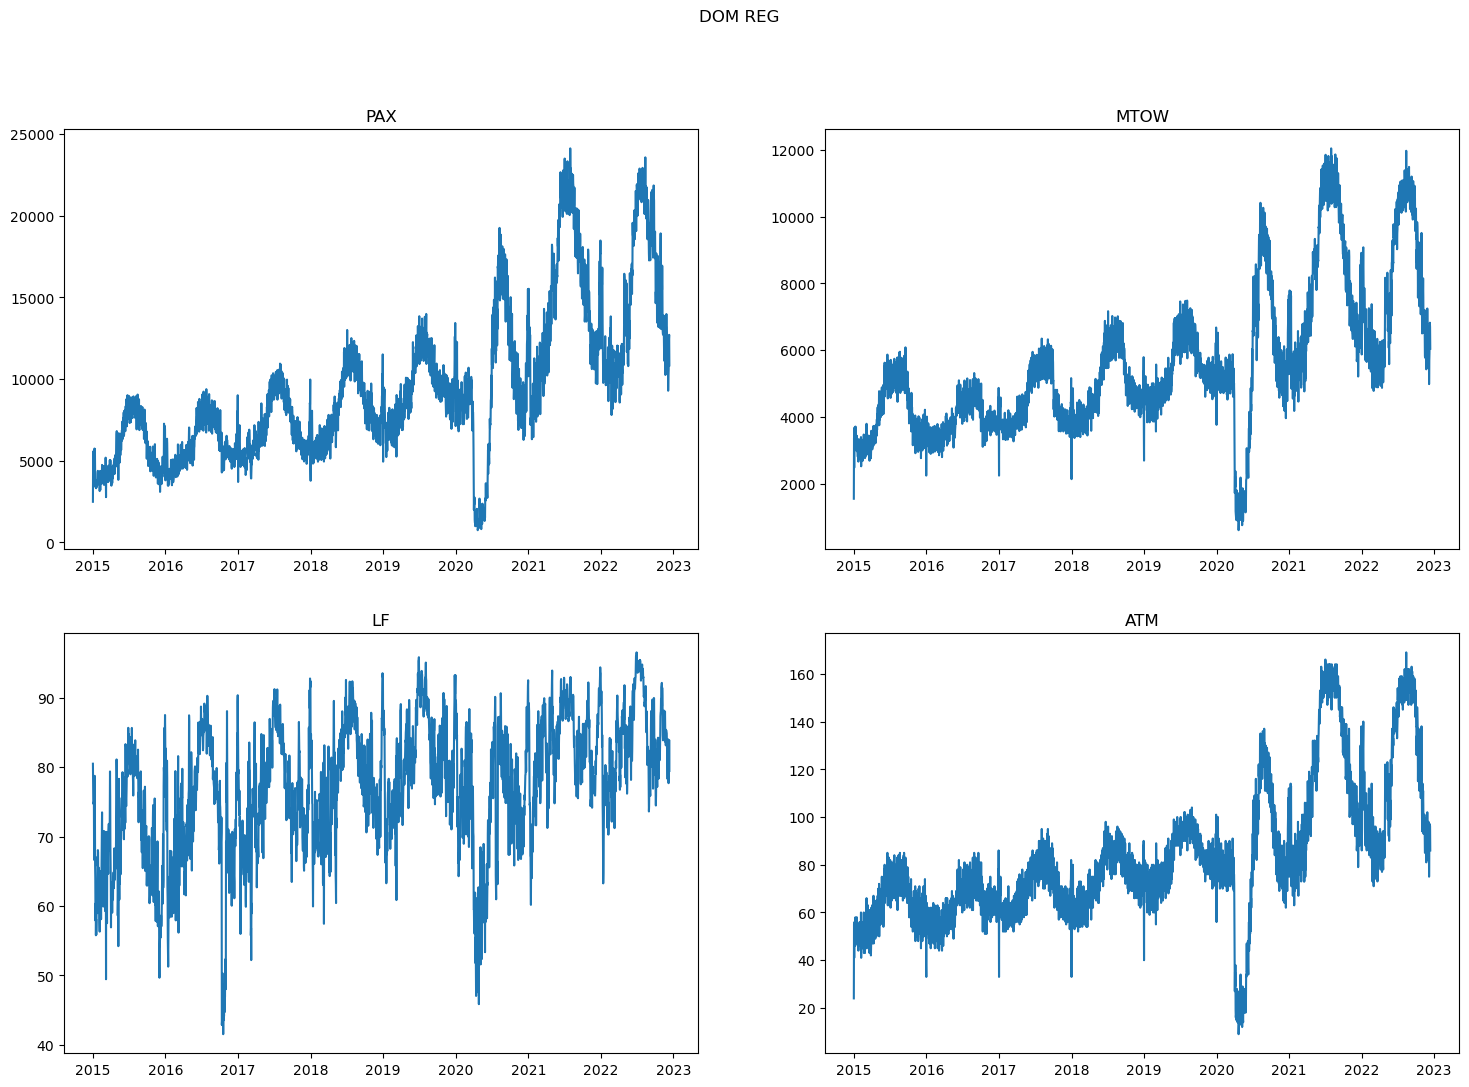

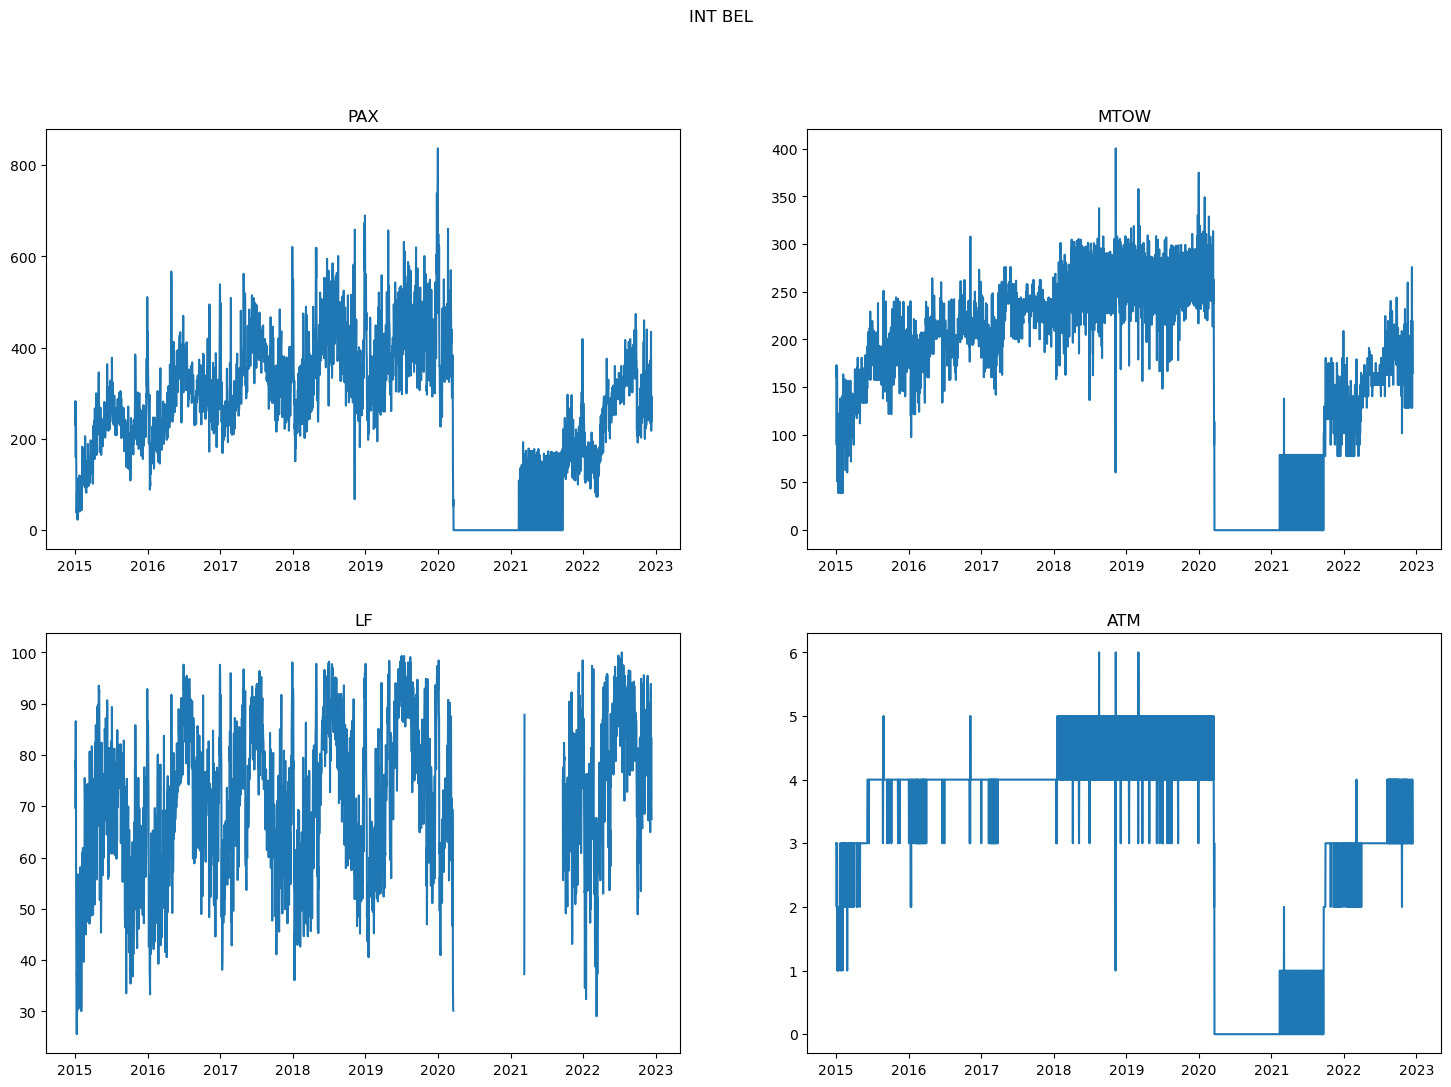

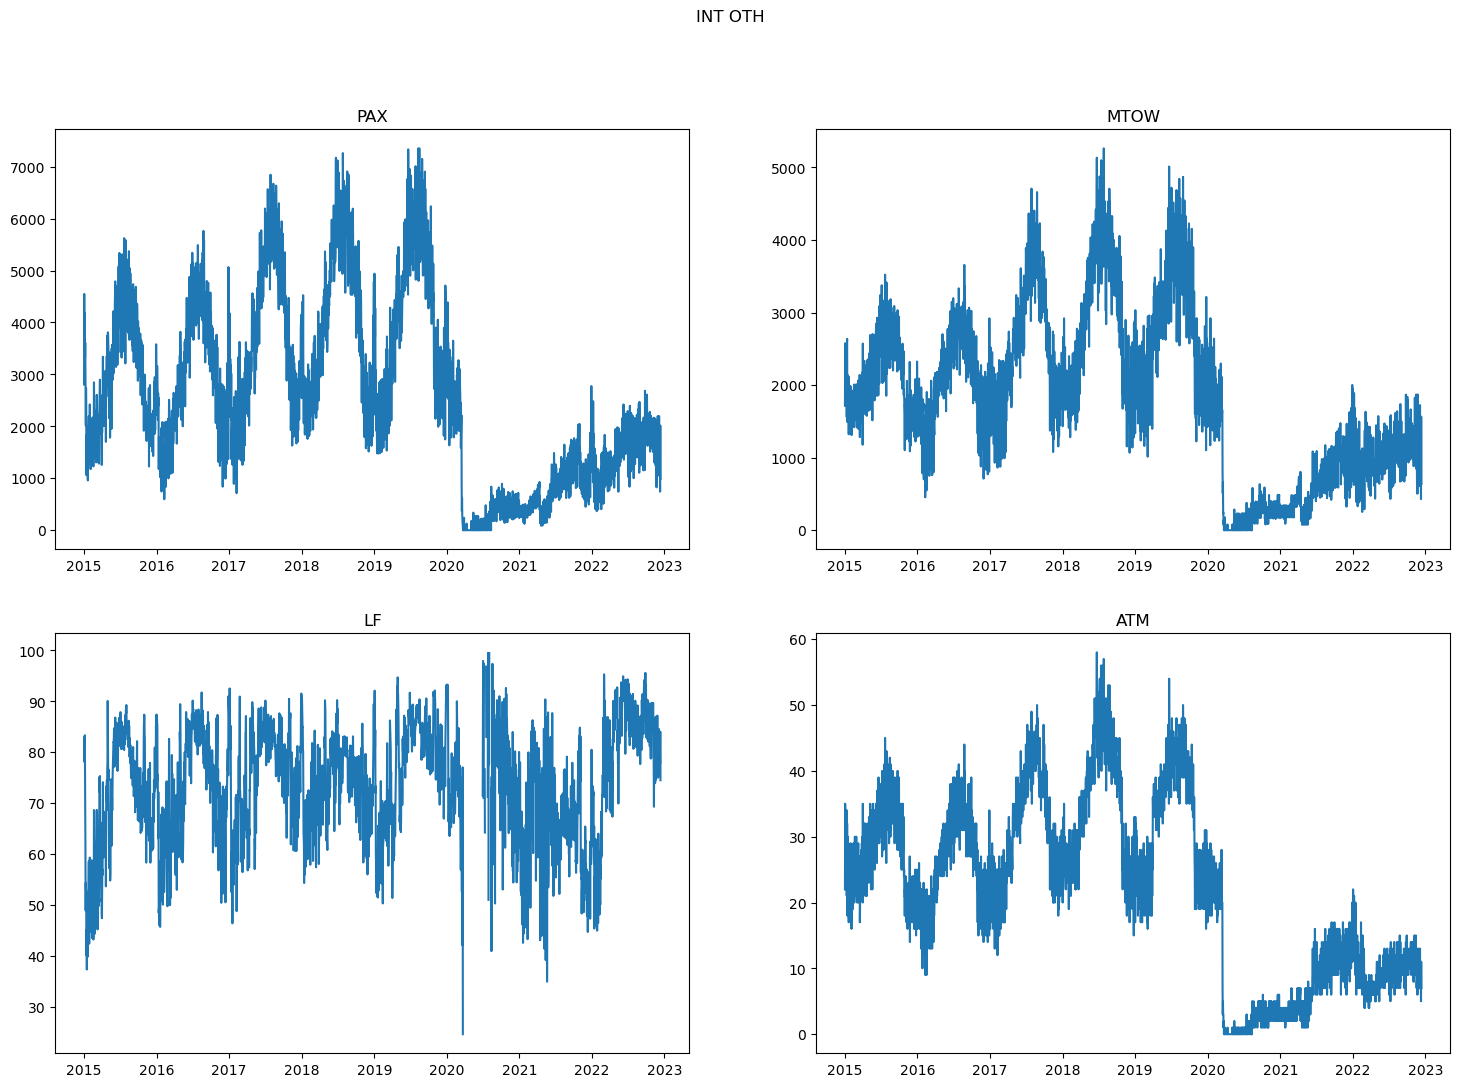

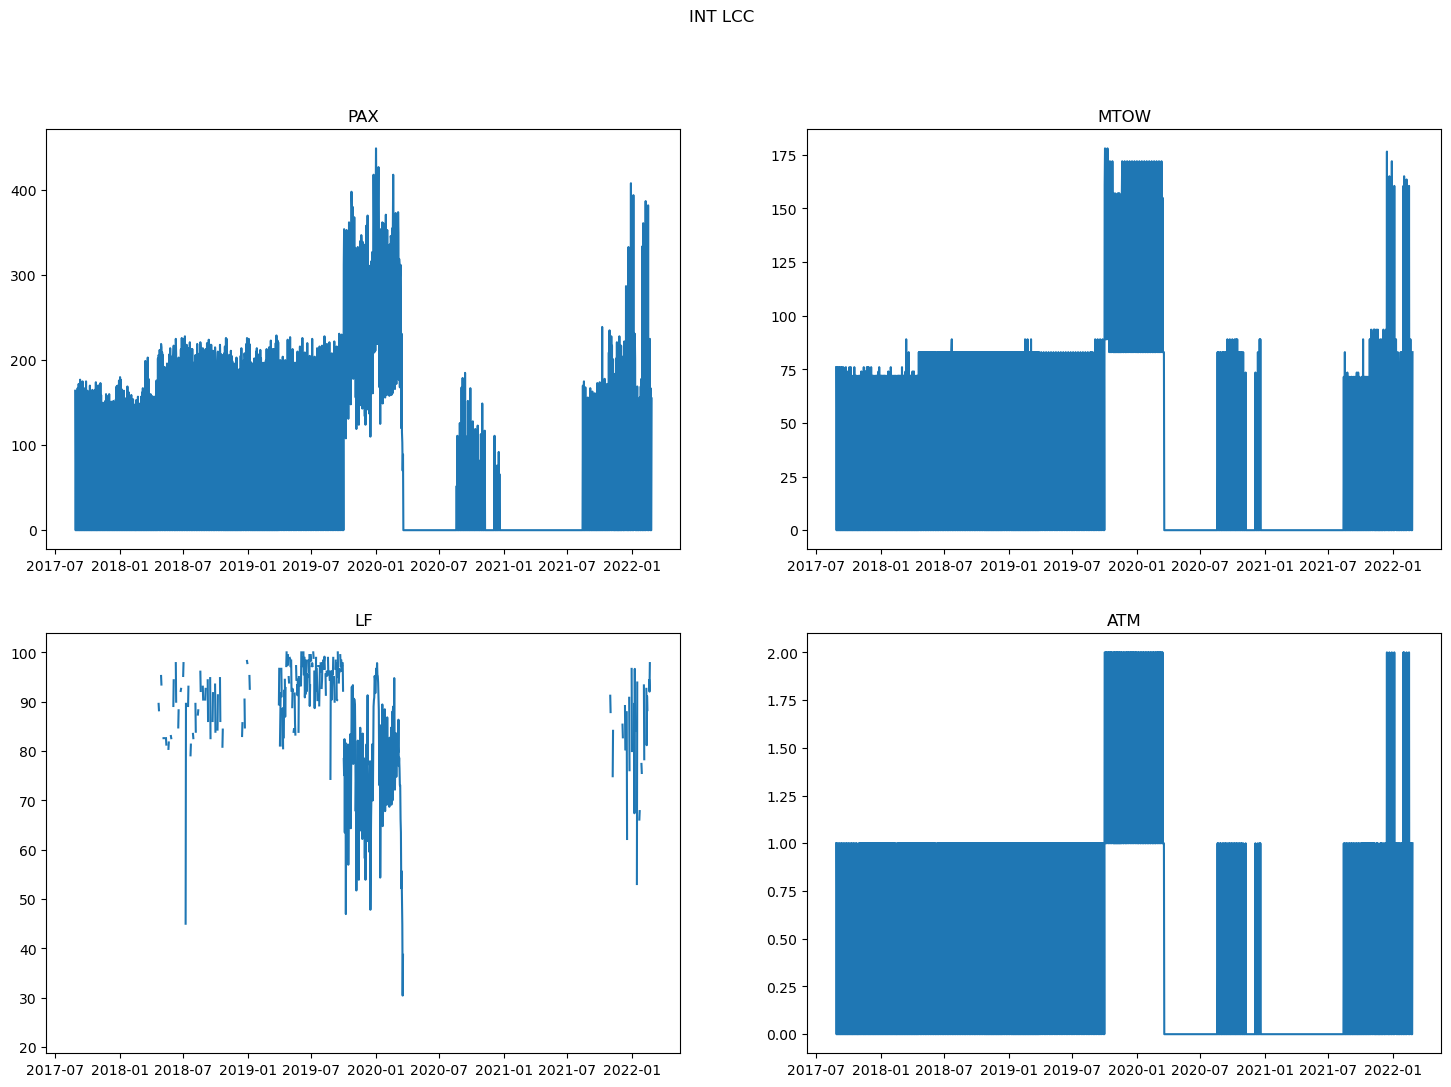

In [37]:
mpl.rcParams['figure.figsize'] = (18,12)
for i in range(0, 6):
    figure, axis = plt.subplots(2, 2)
    k = 0
    d = 0
    for j in range (0, 4):
        x = dict_all[seg[i]][coll[j]]['Time']
        y = dict_all[seg[i]][coll[j]][coll[j]]
        axis[k, d].plot(x,y)
        axis[k, d].set_title(coll[j])
        d +=1
        if d > 1:
            k +=1
            d = 0
    figure.suptitle(seg[i])

In [38]:
sum(dict_all[seg[5]][coll[3]][coll[3]])

793

По графикам выше можно увидеть, что в разных сегментах показатели ведут себя различным образом. Также различается кол-во наблюдений и наличие пропусков в данных. Уже отсюда можно предположить, что модели машинного обучения дадут хороший результат на первых пяти сегментах, а на последнем - в который входят рейсы, выполняемые иностранными перевозчиками (кроме рейсов 7-й свободы) - результат будет хуже из-за большого количества пропусков в данных.

Однако на последнем сегменте производится не так много рейсов, как на остальных пяти (взлетно-посадочных операций всего 793 с 2017 года, по сравнению с десятками тысяч на других), поэтому для сокращения операционных затрат стоит фокусироваться на повышении точности прогноза в самых востребованных направлениях, которые нагружают системы и сотрудников аэропотра.

Для более точного подбора гиперпараметров обучаемых далее моделей полезно понять, как выглядят временные ряды в декомпозированном виде. Здесь будет рассмотрена самая очевидна в интерпретации метрика - PAX, которая в обработанных и сгрупированных данных представляет собой cуммарное количество пассажиров, вылетающих из Пулково в день в период с 2015 по конец 2022 года.

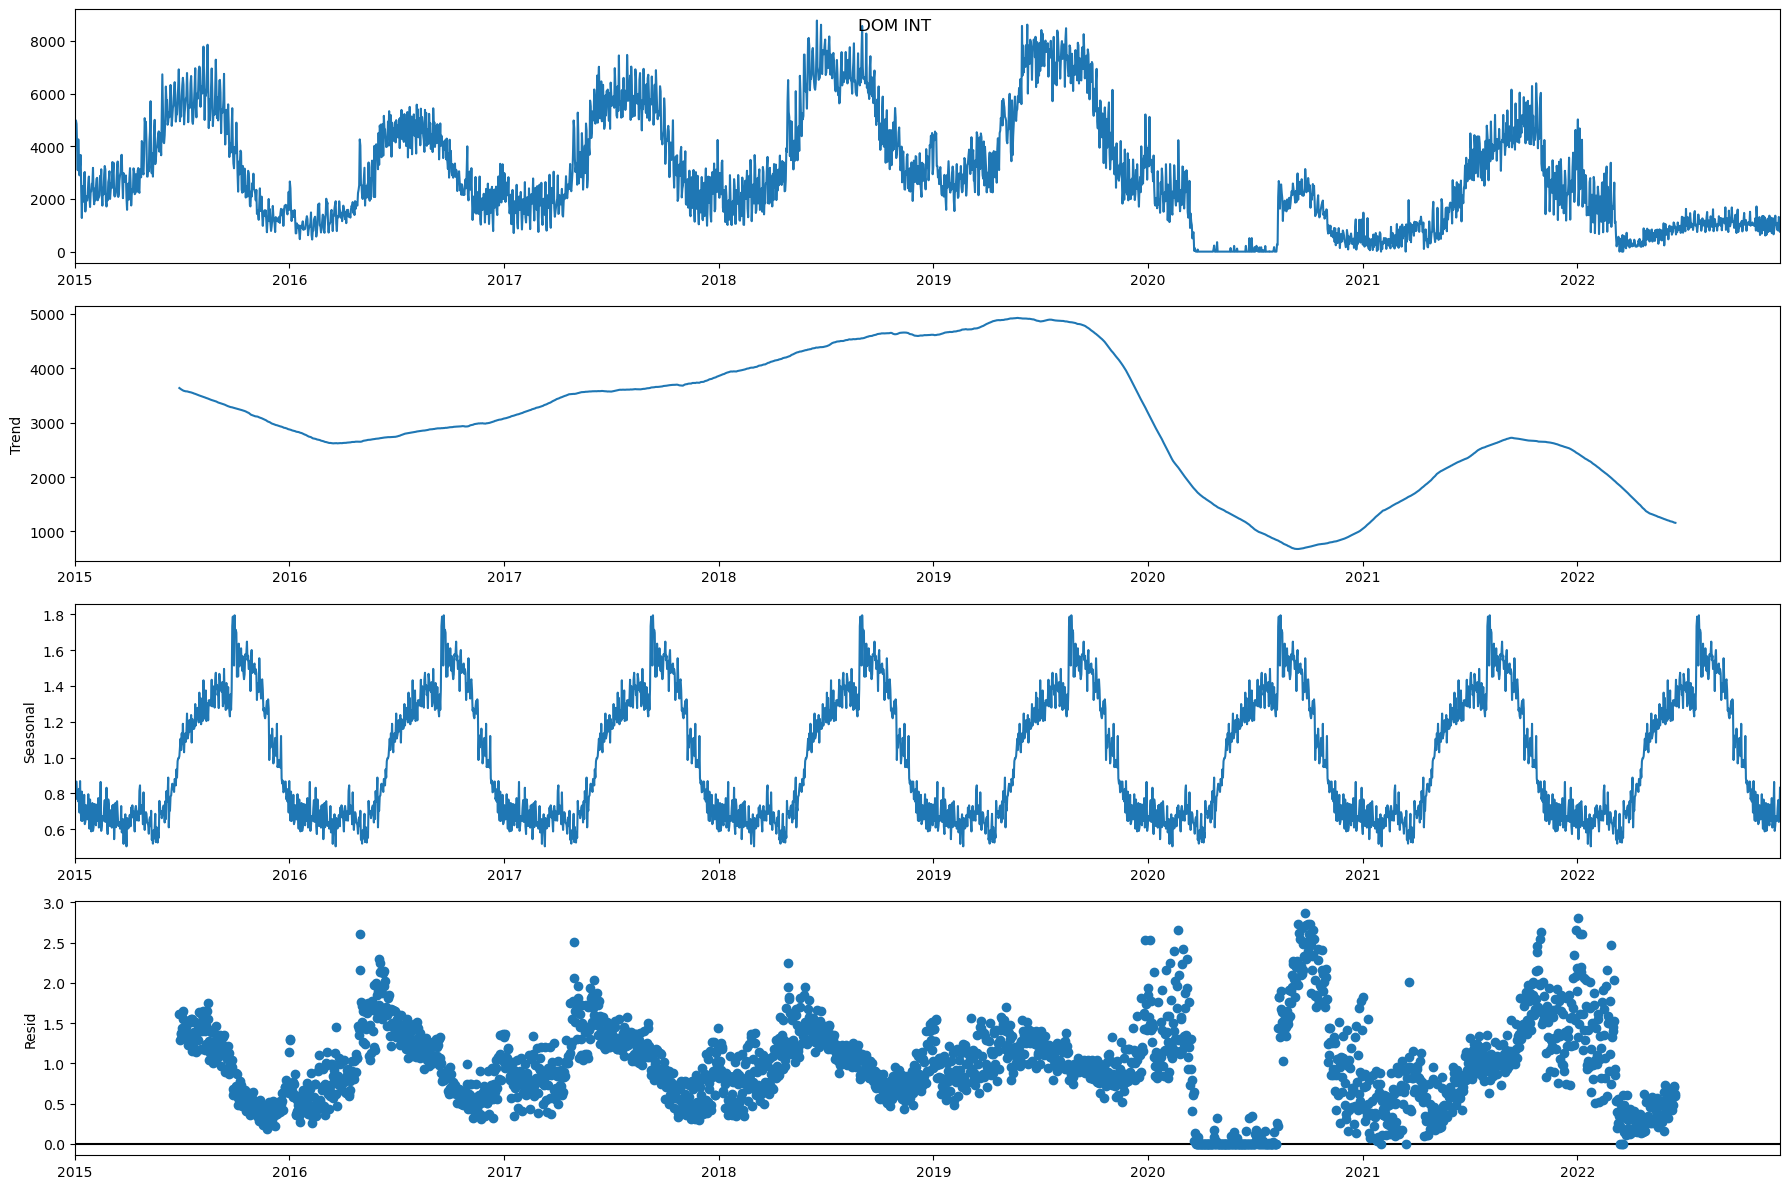

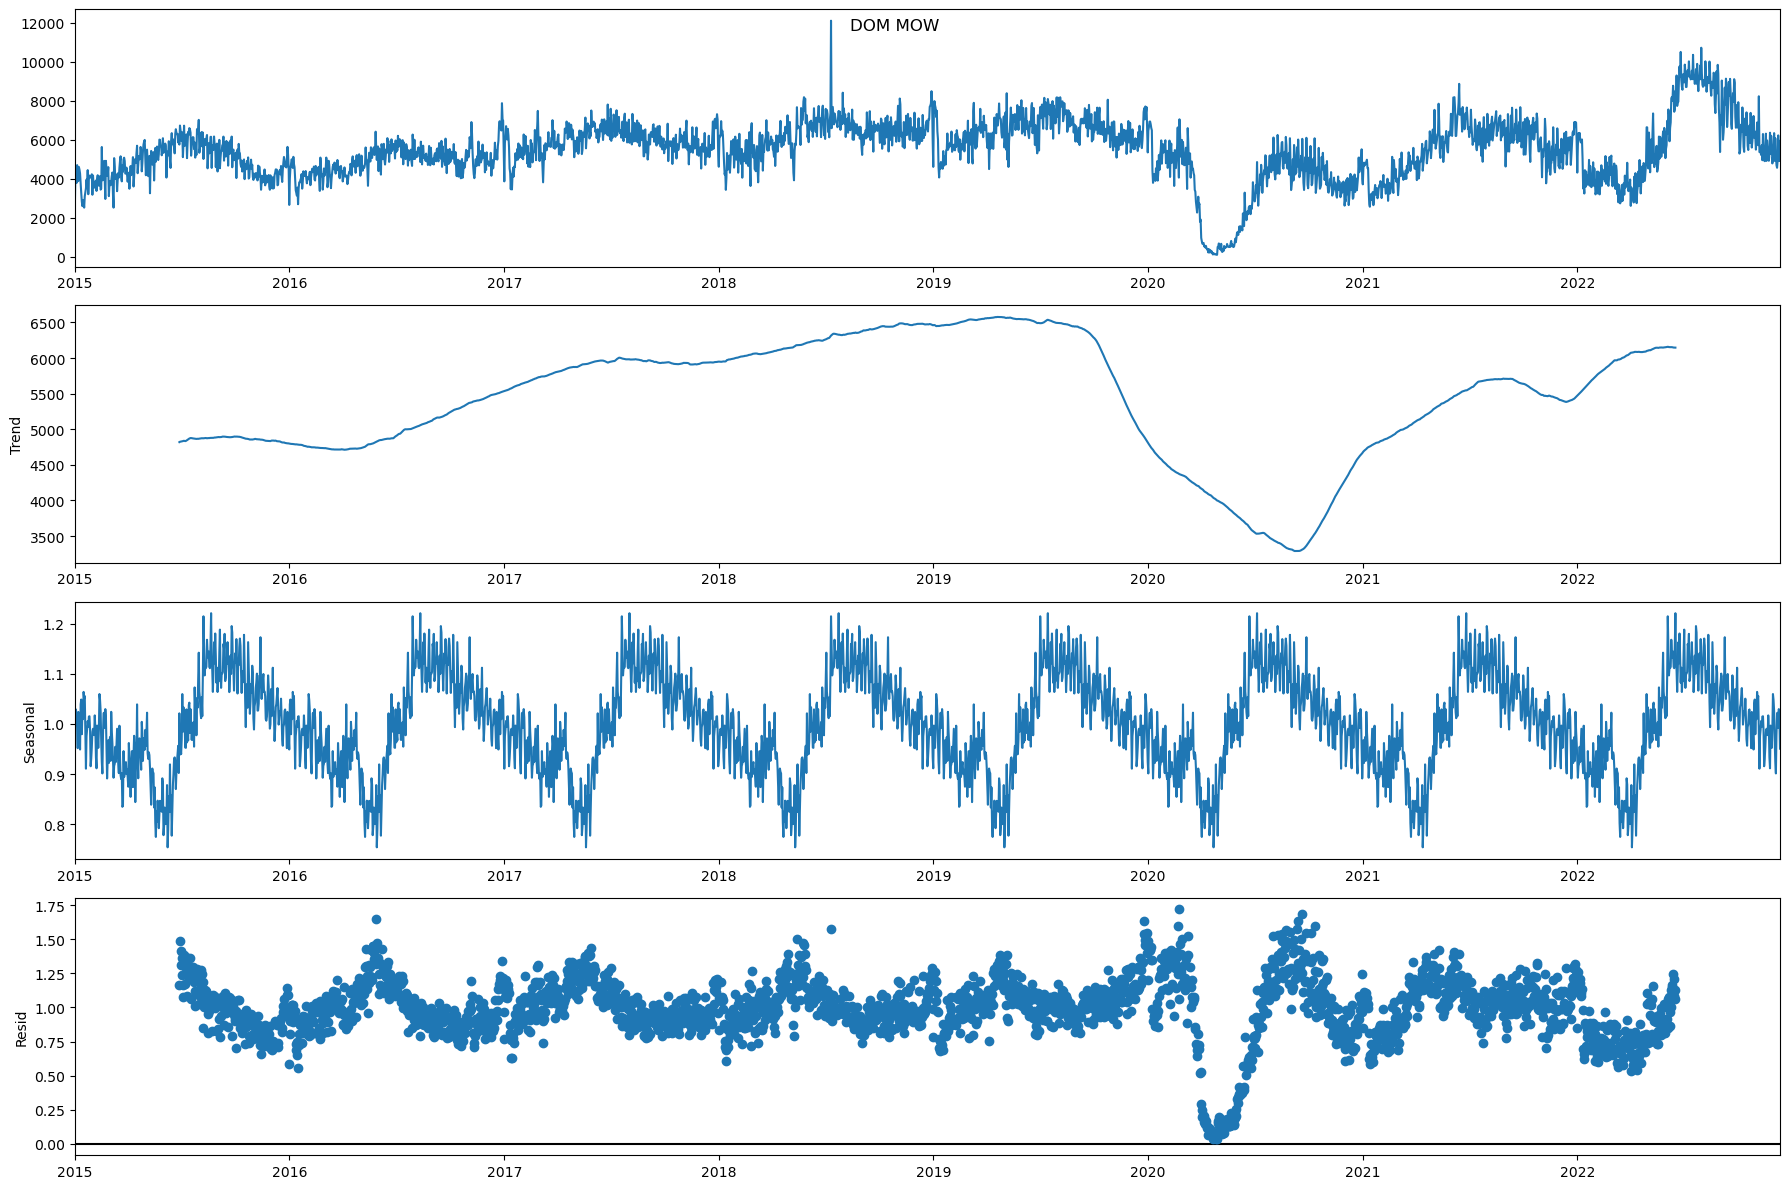

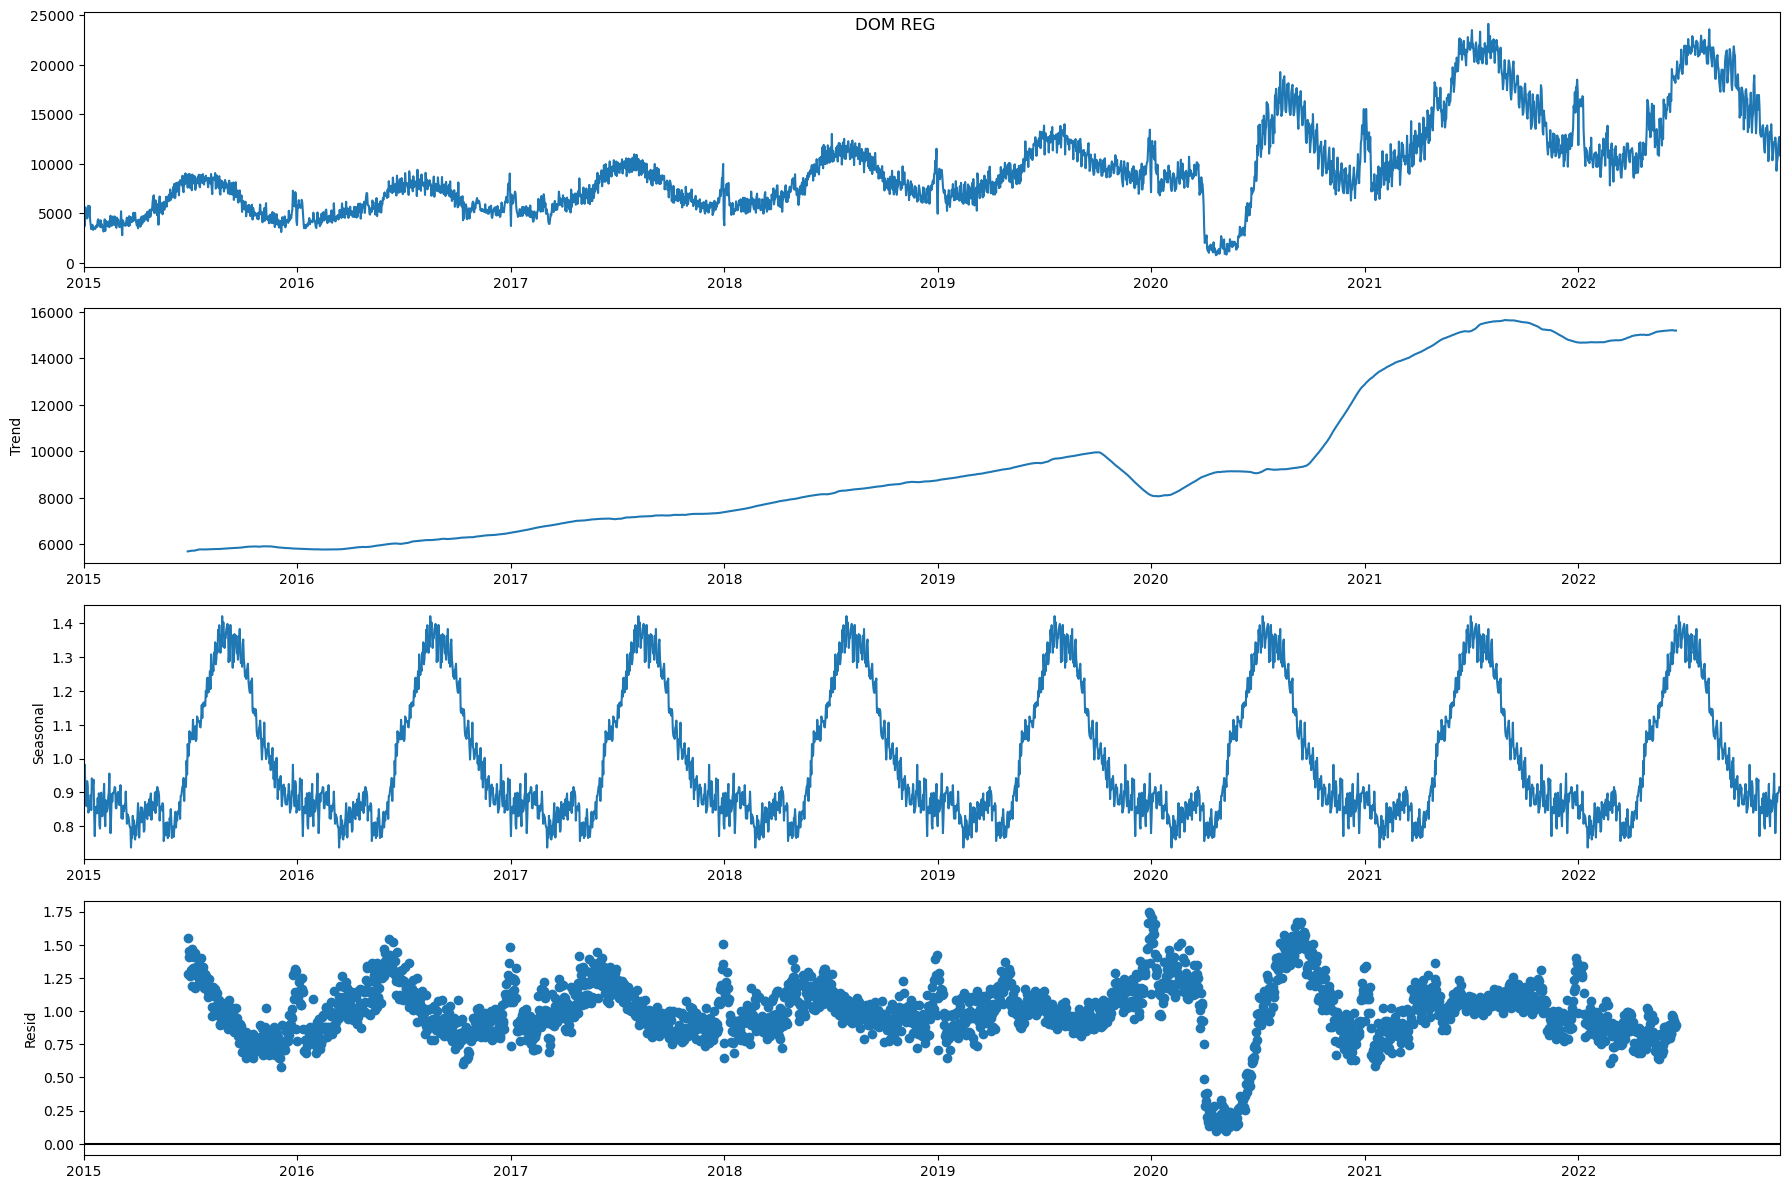

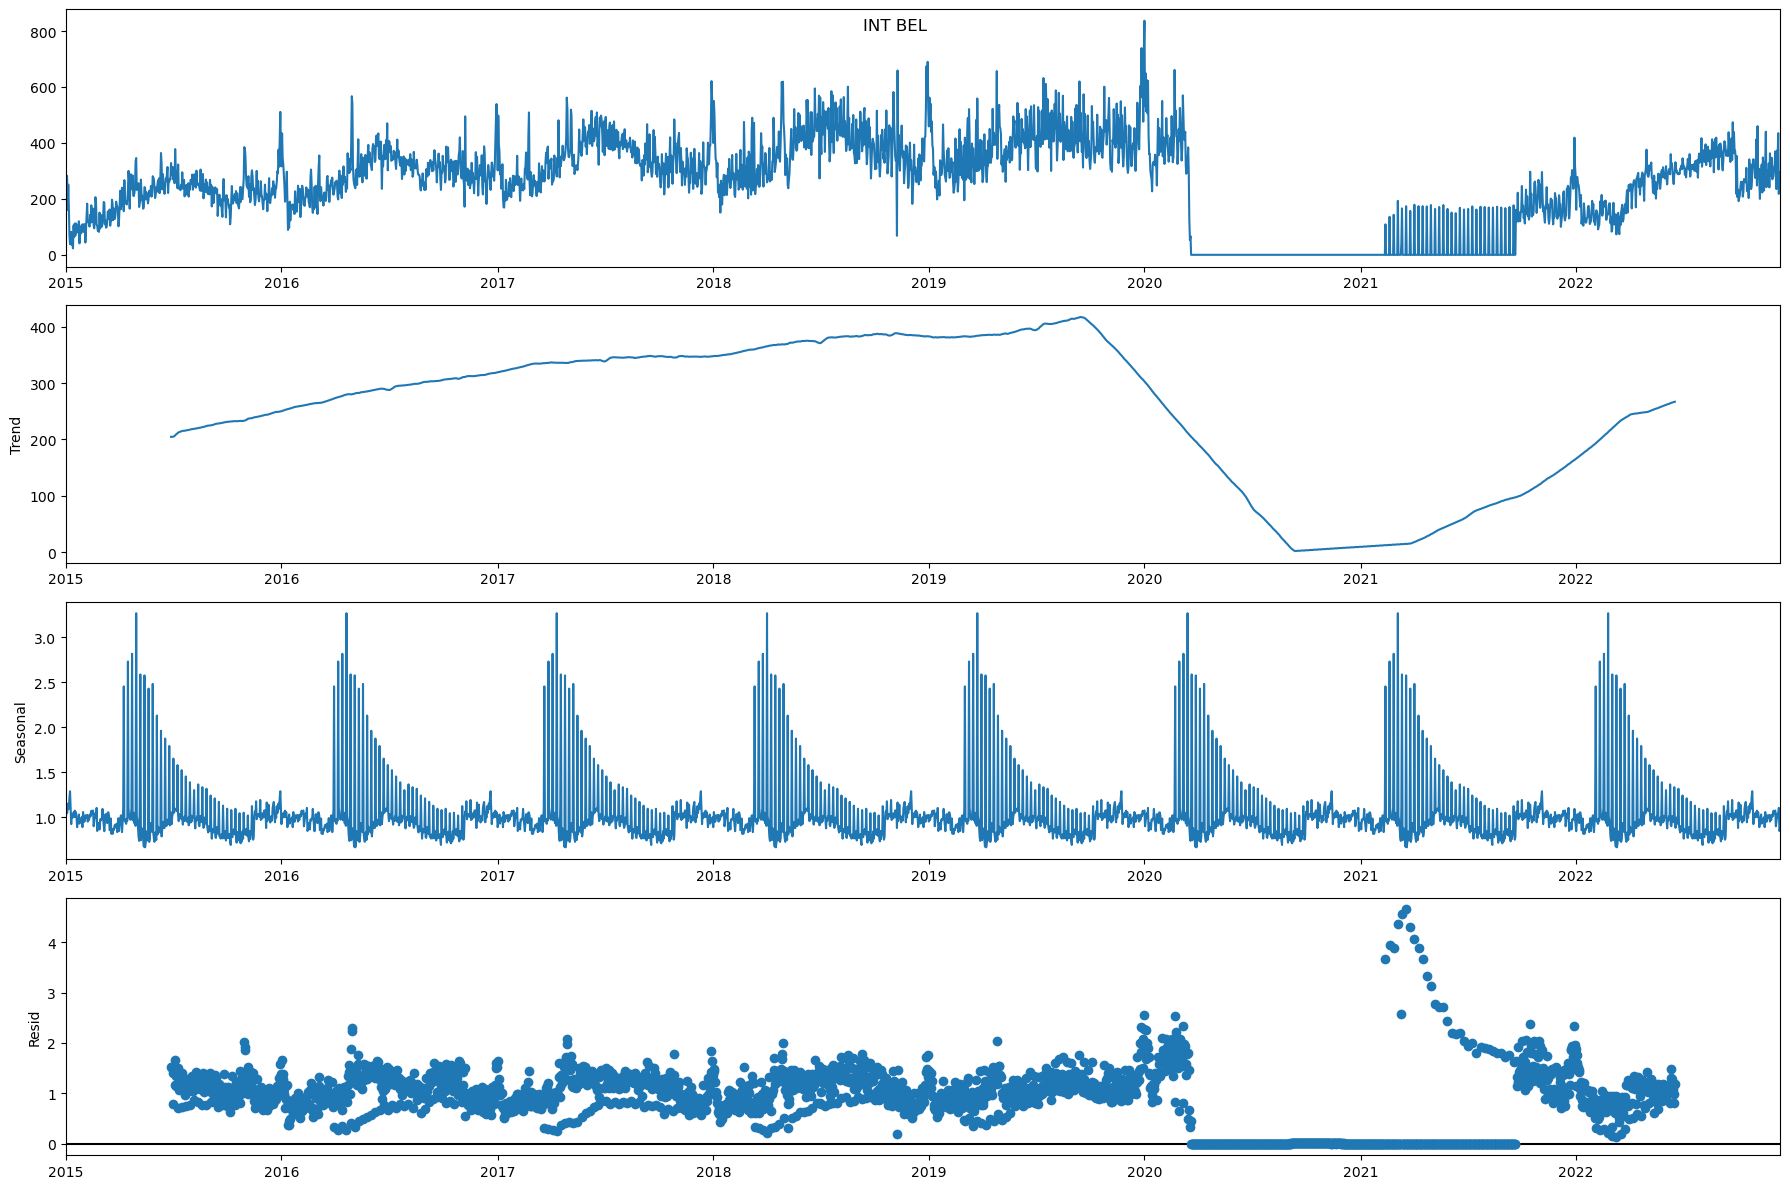

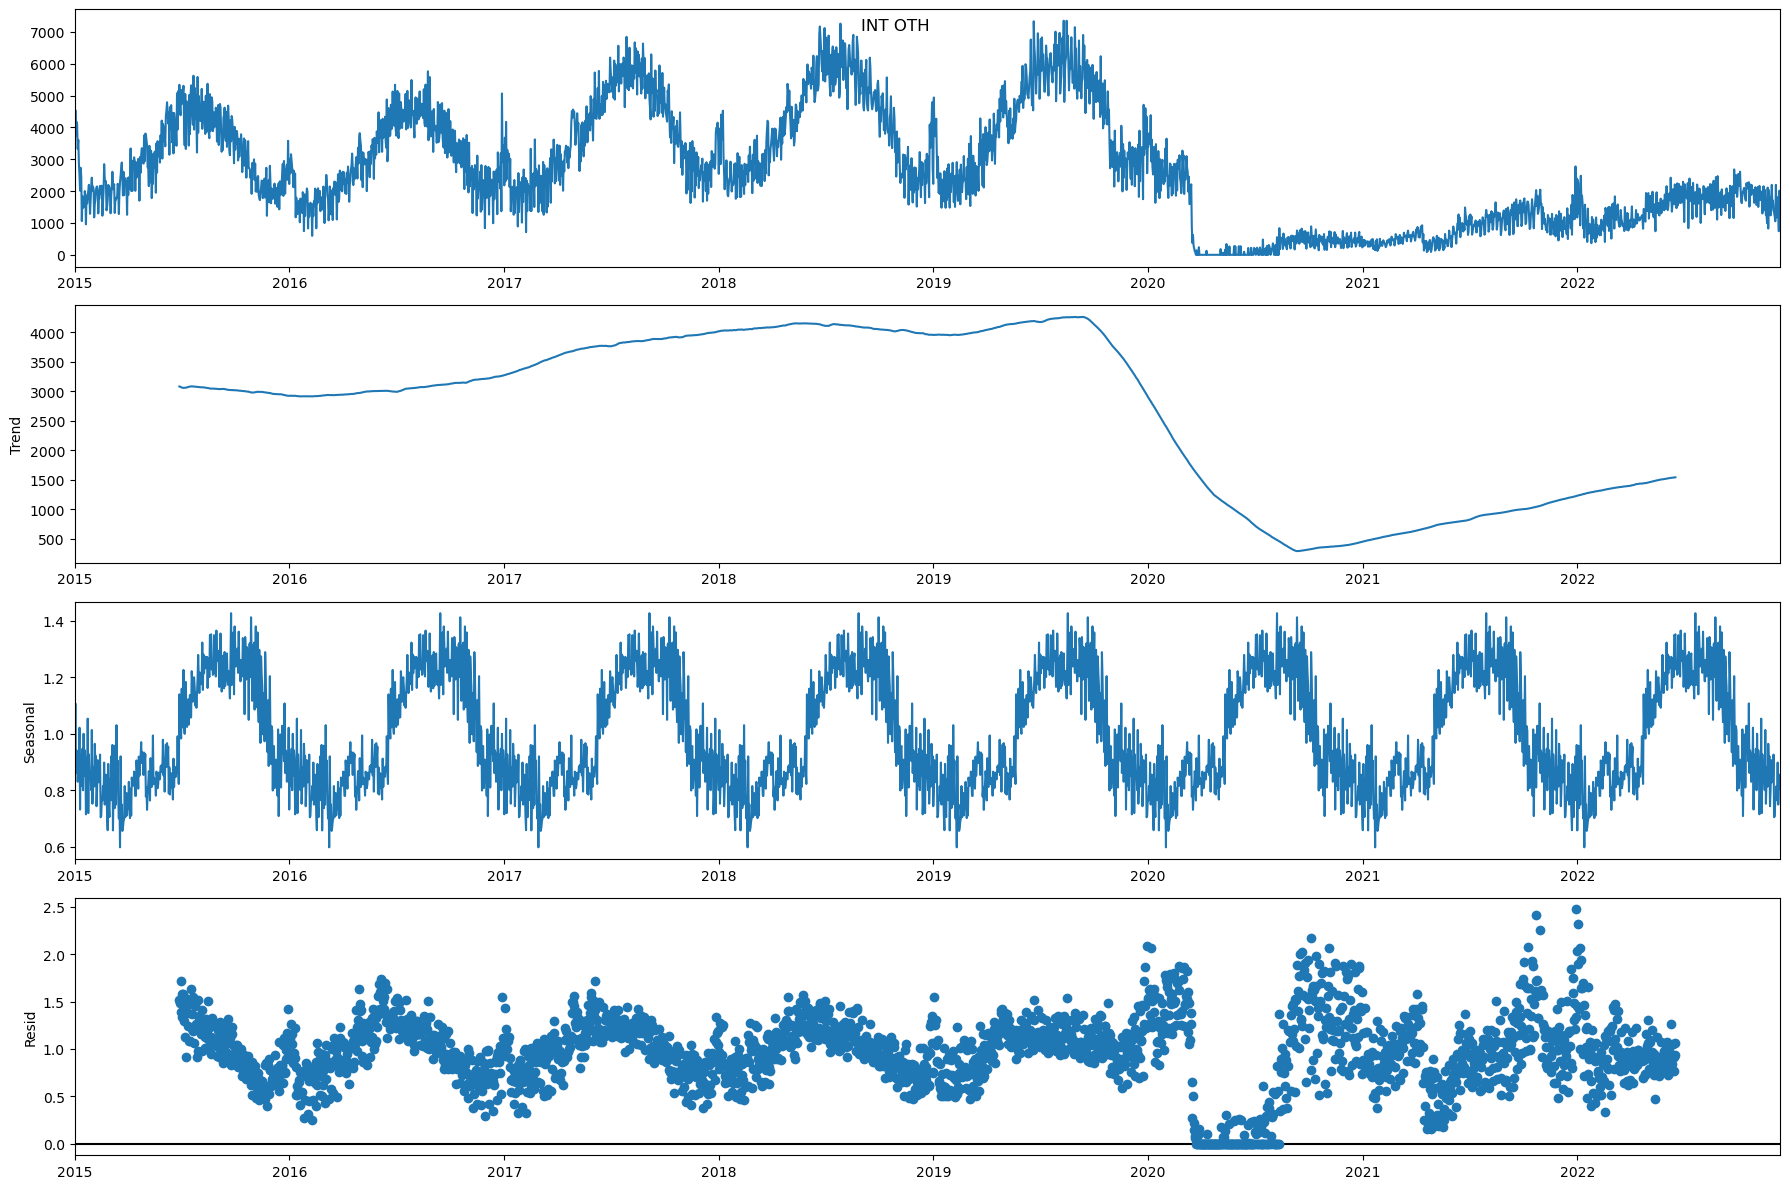

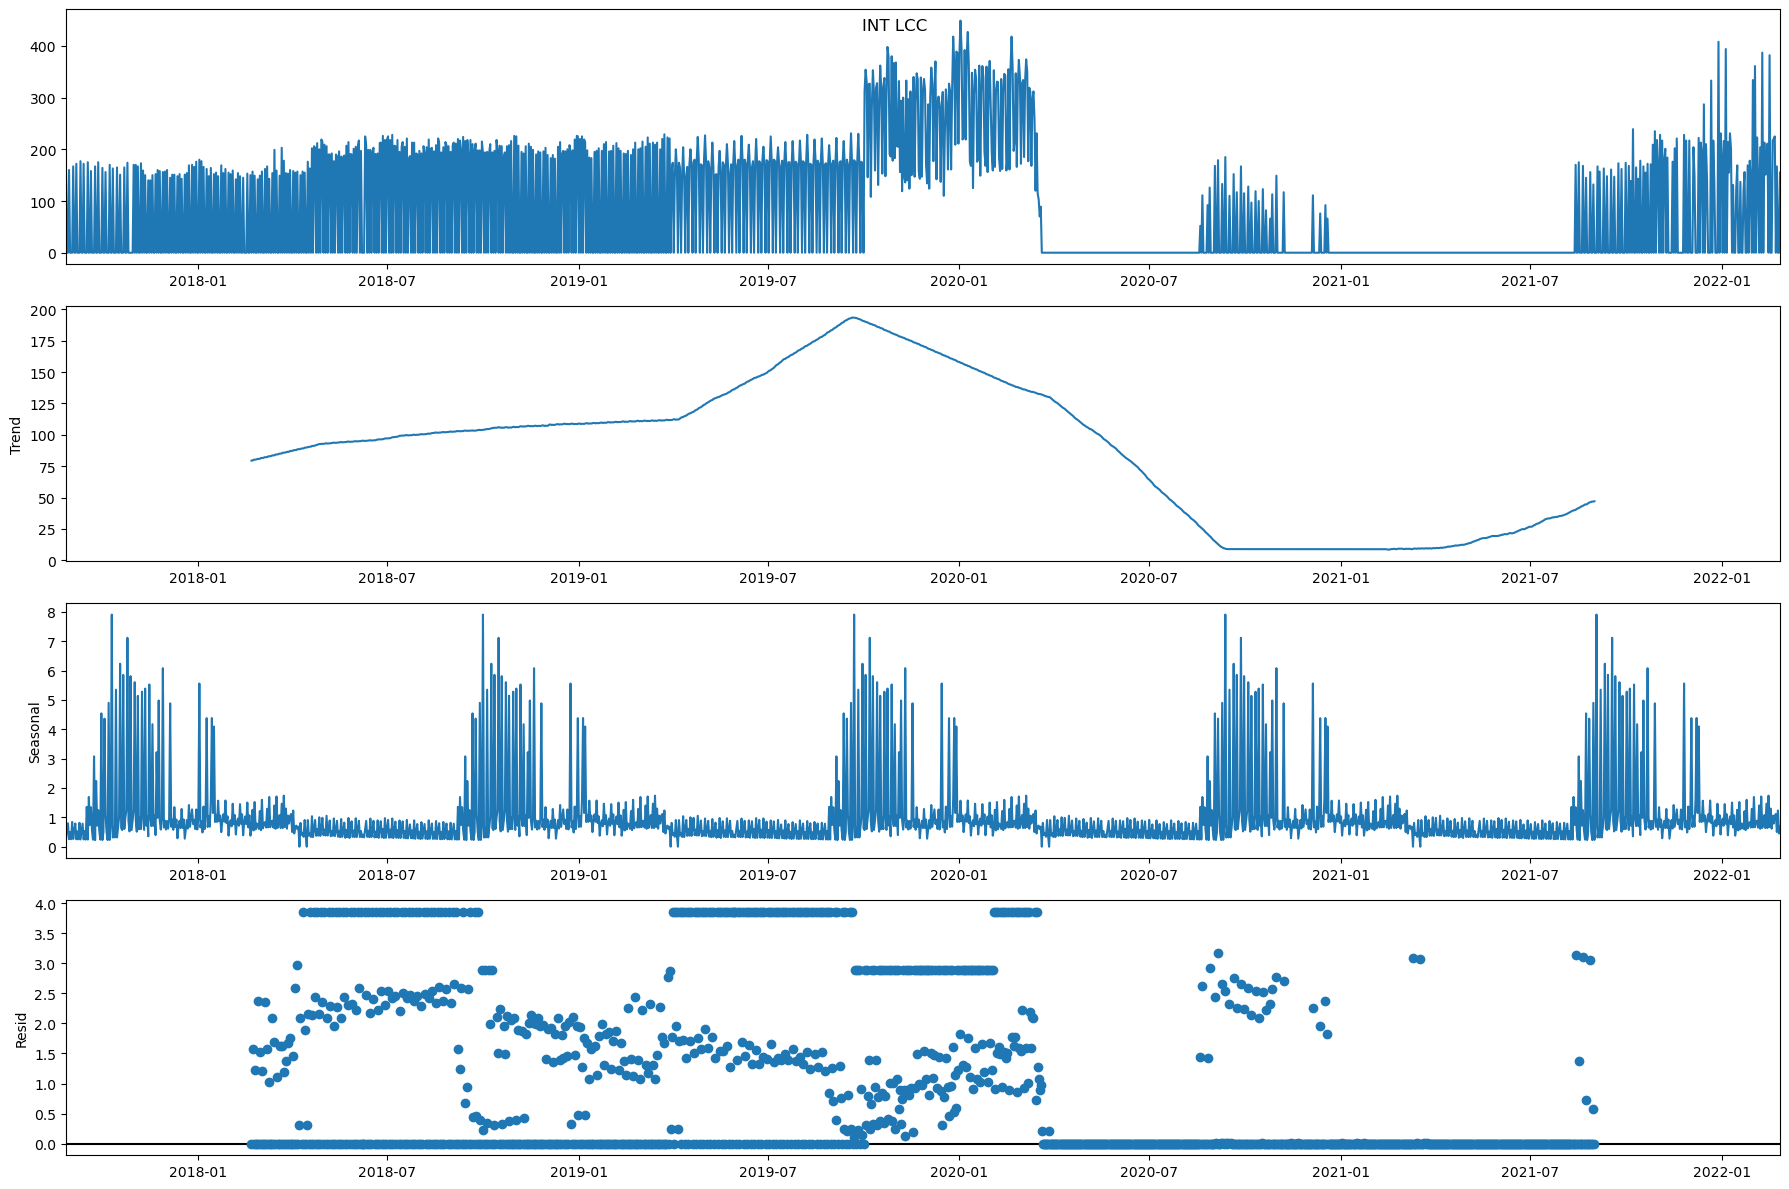

In [39]:
for i in range (0, 6):
    decomposition = sm.tsa.seasonal_decompose(dict_all[seg[i]]['PAX'].replace({np.nan: 0.01, 0: 0.01}).set_index('Time'), 
                                          model='multiplicative', period = 356)
    fig = decomposition.plot()
    fig.suptitle(seg[i])

На данных графиках заметно большое влияние ограничений в передвижении, связанных с пандемией, на авиационный трафик. Причем, меньше всего влияние было оказано на сегмент DOM REG - внутристрановых рейсов из СПб в регионы.

## Обучение моделей

### LSTM

#### Подготовка данных

In [66]:
lstm_all = {}
lstm_all = copy.deepcopy(dict_all)
lstm_all

{'DOM INT': {'PAX':            Time     PAX
  0    2015-01-01  4250.0
  1    2015-01-02  4118.0
  2    2015-01-03  4979.0
  3    2015-01-04  4847.0
  4    2015-01-05  3945.0
  ...         ...     ...
  2898 2022-12-08  1092.0
  2899 2022-12-09   796.0
  2900 2022-12-10  1316.0
  2901 2022-12-11  1190.0
  2902 2022-12-12   759.0
  
  [2903 rows x 2 columns],
  'MTOW':            Time      MTOW
  0    2015-01-01  2680.335
  1    2015-01-02  2370.556
  2    2015-01-03  2823.500
  3    2015-01-04  2945.733
  4    2015-01-05  2351.998
  ...         ...       ...
  2898 2022-12-08   498.500
  2899 2022-12-09   387.296
  2900 2022-12-10   604.700
  2901 2022-12-11   563.530
  2902 2022-12-12   405.000
  
  [2903 rows x 2 columns],
  'LF':            Time         LF
  0    2015-01-01  88.658526
  1    2015-01-02  90.871384
  2    2015-01-03  89.306322
  3    2015-01-04  86.493798
  4    2015-01-05  86.497978
  ...         ...        ...
  2898 2022-12-08  88.931731
  2899 2022-12-09  86.646210

In [67]:
# нормализация данных, замена пропусков нулевыми значениями
nns = 0
sc_dict = {}
for j in range (0, 6):
    sc_dict[seg[j]] = {}
    for i in range (0, 4):
        scaler = MinMaxScaler(feature_range=(0, 1))
        lstm_all[seg[j]][coll[i]] = lstm_all[seg[j]][coll[i]].set_index('Time')  
        lstm_all[seg[j]][coll[i]] = lstm_all[seg[j]][coll[i]].replace(np.nan, 0)
        lstm_all[seg[j]][coll[i]] = scaler.fit_transform(np.reshape(lstm_all[seg[j]][coll[i]],(-1, 1)))
        sc_dict[seg[j]][coll[i]] = scaler
        nns += np.isnan(lstm_all[seg[j]][coll[i]]).sum()
print(nns)

0


На всех метриках и сегментах пропущенные значения заменены на нули.

In [68]:
# разделение на обучающую и тестовую выборки
train_dict = {}
val_dict = {}
test_dict = {}
for j in range (0, 6):
    train_dict[seg[j]] = {}
    val_dict[seg[j]] = {}
    test_dict[seg[j]] = {}
    
    for i in range (0, 4):
        if j != 5:
            train_len = 0.934
            val_test_len = 0.033
        else:
            train_len = 0.886
            val_test_len = 0.0557
        thisdf = lstm_all[seg[j]][coll[i]]
        train_size = int(len(thisdf) * train_len)
        val_size = int(len(thisdf) * train_len) + int(len(thisdf) * val_test_len)

        train_dict[seg[j]][coll[i]] = \
        lstm_all[seg[j]][coll[i]][0:train_size,:]
        
        val_dict[seg[j]][coll[i]] = \
        lstm_all[seg[j]][coll[i]][train_size:val_size,:]
        
        test_dict[seg[j]][coll[i]] = \
        lstm_all[seg[j]][coll[i]][val_size:len(thisdf),:]
    # демонстрация размеров выборок
    print('\n', seg[j], coll[i])
    print('Train', 'Val', 'Test')
    print(len(train_dict[seg[j]][coll[i]]), len(val_dict[seg[j]][coll[i]]), len(test_dict[seg[j]][coll[i]]))



 DOM INT ATM
Train Val Test
2711 95 97

 DOM MOW ATM
Train Val Test
2711 95 97

 DOM REG ATM
Train Val Test
2711 95 97

 INT BEL ATM
Train Val Test
2711 95 97

 INT OTH ATM
Train Val Test
2711 95 97

 INT LCC ATM
Train Val Test
1457 91 97


In [69]:
# преобразование временного ряда в матрицу данных
def create_dataset(dataset, window_size):
    dataX, dataY = [], []
    for i in range(len(dataset)-window_size):
        x = dataset[i:(i+window_size), 0]
        y = dataset[i+window_size, 0]
        dataX.append(x)
        dataY.append(y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = {}, {}
valX, valY = {}, {}
testX, testY = {}, {}

window_size = 62

for j in range (0, 6):
    trainX[seg[j]], trainY[seg[j]] = {}, {}
    valX[seg[j]], valY[seg[j]] = {}, {}
    testX[seg[j]], testY[seg[j]] = {}, {}   

    for i in range (0, 4):
        
        trainX[seg[j]][coll[i]], trainY[seg[j]][coll[i]] = create_dataset(
                                                                   train_dict[seg[j]][coll[i]], window_size)
        trainX[seg[j]][coll[i]] = np.reshape(trainX[seg[j]][coll[i]], (
                                         trainX[seg[j]][coll[i]].shape[0], 1, trainX[seg[j]][coll[i]].shape[1]))
        
        valX[seg[j]][coll[i]], valY[seg[j]][coll[i]] = create_dataset(
                                                                   val_dict[seg[j]][coll[i]], window_size)
        valX[seg[j]][coll[i]] = np.reshape(valX[seg[j]][coll[i]], (
                                         valX[seg[j]][coll[i]].shape[0], 1, valX[seg[j]][coll[i]].shape[1]))
        
        testX[seg[j]][coll[i]], testY[seg[j]][coll[i]] = create_dataset(
                                                                   test_dict[seg[j]][coll[i]], window_size)
        testX[seg[j]][coll[i]] = np.reshape(testX[seg[j]][coll[i]], (
                                         testX[seg[j]][coll[i]].shape[0], 1, testX[seg[j]][coll[i]].shape[1]))


#### Подбор гиперпараметров

In [56]:
def create_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(8, input_shape=(1, window_size)))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [58]:
%%time

# нахождение наилучших параметров модели для PAX всех сегментов
lstm_fmod = {}

for j in range (0, 6):
    lstm_fmod[seg[j]] = {}    
    for i in range (0, 1):
        gsm = KerasRegressor(model=create_model, verbose=0)
        
        # определение параметров для поиска
        batch_size = [10, 15, 20]
        epochs = [25, 30, 35]
        param_grid = dict(batch_size=batch_size, epochs=epochs)

        grid = GridSearchCV(estimator=gsm, scoring = 'neg_root_mean_squared_error', param_grid=param_grid, n_jobs=-1, cv=5)
        grid_result = grid.fit(trainX[seg[j]][coll[i]], trainY[seg[j]][coll[i]],
                                validation_data=(valX[seg[j]][coll[i]], valY[seg[j]][coll[i]])
                                )
        
        # результаты поиска параметров
        print(seg[j], coll[i])
        print("Лучшая ошибка: %f с параметрами %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) с: %r" % (mean, stdev, param))

        lstm_fmod[seg[j]][coll[i]] = grid_result.best_params_

DOM INT PAX
Лучшая ошибка: -0.050695 с параметрами {'batch_size': 15, 'epochs': 25}
-0.053612 (0.010748) с: {'batch_size': 10, 'epochs': 25}
-0.054136 (0.007627) с: {'batch_size': 10, 'epochs': 30}
-0.052672 (0.005238) с: {'batch_size': 10, 'epochs': 35}
-0.050695 (0.005488) с: {'batch_size': 15, 'epochs': 25}
-0.051522 (0.005214) с: {'batch_size': 15, 'epochs': 30}
-0.050768 (0.005742) с: {'batch_size': 15, 'epochs': 35}
-0.054287 (0.004935) с: {'batch_size': 20, 'epochs': 25}
-0.052509 (0.006259) с: {'batch_size': 20, 'epochs': 30}
-0.052655 (0.007847) с: {'batch_size': 20, 'epochs': 35}
DOM MOW PAX
Лучшая ошибка: -0.045650 с параметрами {'batch_size': 10, 'epochs': 30}
-0.048021 (0.007443) с: {'batch_size': 10, 'epochs': 25}
-0.045650 (0.006929) с: {'batch_size': 10, 'epochs': 30}
-0.046373 (0.007212) с: {'batch_size': 10, 'epochs': 35}
-0.046373 (0.007881) с: {'batch_size': 15, 'epochs': 25}
-0.046654 (0.008052) с: {'batch_size': 15, 'epochs': 30}
-0.045782 (0.007357) с: {'batch_si

In [59]:
%%time

# нахождение наилучших параметров модели для MTOW всех сегментов

for j in range (0, 6):  
    for i in range (1, 2):
        gsm = KerasRegressor(model=create_model, verbose=0)
        
        # определение параметров для поиска
        batch_size = [10, 15, 20]
        epochs = [25, 30, 35]
        param_grid = dict(batch_size=batch_size, epochs=epochs)

        grid = GridSearchCV(estimator=gsm, scoring = 'neg_root_mean_squared_error', param_grid=param_grid, n_jobs=-1, cv=5)
        grid_result = grid.fit(trainX[seg[j]][coll[i]], trainY[seg[j]][coll[i]])
        
        # результаты поиска параметров
        print(seg[j], coll[i])
        print("Лучшая ошибка: %f с параметрами %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) с: %r" % (mean, stdev, param))

        lstm_fmod[seg[j]][coll[i]] = grid_result.best_params_

DOM INT MTOW
Лучшая ошибка: -0.052648 с параметрами {'batch_size': 10, 'epochs': 35}
-0.056349 (0.005020) с: {'batch_size': 10, 'epochs': 25}
-0.052699 (0.006670) с: {'batch_size': 10, 'epochs': 30}
-0.052648 (0.006048) с: {'batch_size': 10, 'epochs': 35}
-0.054202 (0.007395) с: {'batch_size': 15, 'epochs': 25}
-0.053582 (0.005917) с: {'batch_size': 15, 'epochs': 30}
-0.053490 (0.005768) с: {'batch_size': 15, 'epochs': 35}
-0.053635 (0.006318) с: {'batch_size': 20, 'epochs': 25}
-0.053980 (0.005589) с: {'batch_size': 20, 'epochs': 30}
-0.054452 (0.006270) с: {'batch_size': 20, 'epochs': 35}
DOM MOW MTOW
Лучшая ошибка: -0.038830 с параметрами {'batch_size': 10, 'epochs': 35}
-0.040973 (0.004758) с: {'batch_size': 10, 'epochs': 25}
-0.041044 (0.003900) с: {'batch_size': 10, 'epochs': 30}
-0.038830 (0.003602) с: {'batch_size': 10, 'epochs': 35}
-0.042744 (0.003501) с: {'batch_size': 15, 'epochs': 25}
-0.039539 (0.004682) с: {'batch_size': 15, 'epochs': 30}
-0.039702 (0.003415) с: {'batch_

In [60]:
%%time

# нахождение наилучших параметров модели для MTOW всех сегментов

for j in range (0, 6):  
    for i in range (2, 3):
        gsm = KerasRegressor(model=create_model, verbose=0)
        
        # определение параметров для поиска
        batch_size = [10, 15, 20]
        epochs = [20, 25, 30]
        param_grid = dict(batch_size=batch_size, epochs=epochs)

        grid = GridSearchCV(estimator=gsm, scoring = 'neg_root_mean_squared_error', param_grid=param_grid, n_jobs=-1, cv=5)
        grid_result = grid.fit(trainX[seg[j]][coll[i]], trainY[seg[j]][coll[i]])
        
        # результаты поиска параметров
        print(seg[j], coll[i])
        print("Лучшая ошибка: %f с параметрами %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) с: %r" % (mean, stdev, param))

        lstm_fmod[seg[j]][coll[i]] = grid_result.best_params_

DOM INT LF
Лучшая ошибка: -0.101980 с параметрами {'batch_size': 10, 'epochs': 30}
-0.102175 (0.056209) с: {'batch_size': 10, 'epochs': 20}
-0.111660 (0.060728) с: {'batch_size': 10, 'epochs': 25}
-0.101980 (0.057720) с: {'batch_size': 10, 'epochs': 30}
-0.104329 (0.053818) с: {'batch_size': 15, 'epochs': 20}
-0.105674 (0.065045) с: {'batch_size': 15, 'epochs': 25}
-0.104982 (0.057392) с: {'batch_size': 15, 'epochs': 30}
-0.105444 (0.054665) с: {'batch_size': 20, 'epochs': 20}
-0.102488 (0.058509) с: {'batch_size': 20, 'epochs': 25}
-0.104940 (0.060668) с: {'batch_size': 20, 'epochs': 30}
DOM MOW LF
Лучшая ошибка: -0.081447 с параметрами {'batch_size': 20, 'epochs': 30}
-0.084538 (0.007989) с: {'batch_size': 10, 'epochs': 20}
-0.083381 (0.009583) с: {'batch_size': 10, 'epochs': 25}
-0.081621 (0.009202) с: {'batch_size': 10, 'epochs': 30}
-0.084236 (0.006983) с: {'batch_size': 15, 'epochs': 20}
-0.081620 (0.009776) с: {'batch_size': 15, 'epochs': 25}
-0.084071 (0.009390) с: {'batch_size

In [61]:
%%time

# нахождение наилучших параметров модели для MTOW всех сегментов

for j in range (0, 6):  
    for i in range (3, 4):
        gsm = KerasRegressor(model=create_model, verbose=0)
        
        # определение параметров для поиска
        batch_size = [15, 20, 25]
        epochs = [20, 25, 30]
        param_grid = dict(batch_size=batch_size, epochs=epochs)

        grid = GridSearchCV(estimator=gsm, scoring = 'neg_root_mean_squared_error', param_grid=param_grid, n_jobs=-1, cv=5)
        grid_result = grid.fit(trainX[seg[j]][coll[i]], trainY[seg[j]][coll[i]])
        
        # результаты поиска параметров
        print(seg[j], coll[i])
        print("Лучшая ошибка: %f с параметрами %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) с: %r" % (mean, stdev, param))

        lstm_fmod[seg[j]][coll[i]] = grid_result.best_params_

DOM INT ATM
Лучшая ошибка: -0.044211 с параметрами {'batch_size': 15, 'epochs': 30}
-0.045935 (0.002376) с: {'batch_size': 15, 'epochs': 20}
-0.046625 (0.003617) с: {'batch_size': 15, 'epochs': 25}
-0.044211 (0.002663) с: {'batch_size': 15, 'epochs': 30}
-0.046083 (0.002204) с: {'batch_size': 20, 'epochs': 20}
-0.044742 (0.002160) с: {'batch_size': 20, 'epochs': 25}
-0.044503 (0.003549) с: {'batch_size': 20, 'epochs': 30}
-0.050574 (0.004914) с: {'batch_size': 25, 'epochs': 20}
-0.046140 (0.003885) с: {'batch_size': 25, 'epochs': 25}
-0.045199 (0.003307) с: {'batch_size': 25, 'epochs': 30}
DOM MOW ATM
Лучшая ошибка: -0.037796 с параметрами {'batch_size': 15, 'epochs': 25}
-0.040543 (0.006490) с: {'batch_size': 15, 'epochs': 20}
-0.037796 (0.005433) с: {'batch_size': 15, 'epochs': 25}
-0.041244 (0.007769) с: {'batch_size': 15, 'epochs': 30}
-0.038977 (0.006211) с: {'batch_size': 20, 'epochs': 20}
-0.041226 (0.006767) с: {'batch_size': 20, 'epochs': 25}
-0.038140 (0.005563) с: {'batch_si

#### Обучение моделей

In [70]:
# создание и обучение моделей с наилучшими гиперпараметрами
lstm_m = {}
for j in range (0, 6):
    lstm_m[seg[j]] = {}    
    for i in range (0, 4):
        model = create_model()
        epochs = lstm_fmod[seg[j]][coll[i]]['epochs']
        bs = lstm_fmod[seg[j]][coll[i]]['batch_size']

        model.fit((trainX[seg[j]][coll[i]]), (trainY[seg[j]][coll[i]]), epochs=epochs, batch_size=bs, verbose=0)
        lstm_m[seg[j]][coll[i]] = model

In [71]:
# прогнозирование на валидационных данных
train_pred = {}
test_pred = {}

for j in range (0, 6):
    train_pred[seg[j]] = {}    
    test_pred[seg[j]] = {}
    for i in range (0, 4):
        train_pred[seg[j]][coll[i]] = lstm_m[seg[j]][coll[i]].predict(trainX[seg[j]][coll[i]])
        test_pred[seg[j]][coll[i]] = lstm_m[seg[j]][coll[i]].predict(testX[seg[j]][coll[i]])


2/2 [==============================] - 7s 10ms/step


In [72]:
# обратная нормализация данных
for j in range (0, 6):
    for i in range (0, 4):
        train_pred[seg[j]][coll[i]] = sc_dict[seg[j]][coll[i]].inverse_transform(train_pred[seg[j]][coll[i]])
        trainY[seg[j]][coll[i]] = sc_dict[seg[j]][coll[i]].inverse_transform(trainY[seg[j]][coll[i]].reshape(-1, 1))
        test_pred[seg[j]][coll[i]] = sc_dict[seg[j]][coll[i]].inverse_transform(test_pred[seg[j]][coll[i]])
        testY[seg[j]][coll[i]] = sc_dict[seg[j]][coll[i]].inverse_transform(testY[seg[j]][coll[i]].reshape(-1, 1))



In [73]:
# оценка качества модели на валидационной выборке
for j in range (0, 6):
    for i in range (0, 4):
        print(seg[j], coll[i])
        trainScore = math.sqrt(mean_squared_error(trainY[seg[j]][coll[i]], train_pred[seg[j]][coll[i]]))
        testScore = math.sqrt(mean_squared_error(testY[seg[j]][coll[i]], test_pred[seg[j]][coll[i]]))
        print('Train Score: %.2f RMSE' % (trainScore))
        print('Test Score: %.2f RMSE' % (testScore))
        print('Test MAPE: %.2f ' % (mape(testY[seg[j]][coll[i]], test_pred[seg[j]][coll[i]])))



DOM INT PAX
Train Score: 535.68 RMSE
Test Score: 304.83 RMSE
Test MAPE: 0.25 
DOM INT MTOW
Train Score: 260.27 RMSE
Test Score: 142.93 RMSE
Test MAPE: 0.26 
DOM INT LF
Train Score: 9.08 RMSE
Test Score: 7.22 RMSE
Test MAPE: 0.07 
DOM INT ATM
Train Score: 2.12 RMSE
Test Score: 1.27 RMSE
Test MAPE: 0.18 
DOM MOW PAX
Train Score: 541.72 RMSE
Test Score: 440.71 RMSE
Test MAPE: 0.07 
DOM MOW MTOW
Train Score: 259.12 RMSE
Test Score: 236.60 RMSE
Test MAPE: 0.07 
DOM MOW LF
Train Score: 5.28 RMSE
Test Score: 2.99 RMSE
Test MAPE: 0.03 
DOM MOW ATM
Train Score: 2.94 RMSE
Test Score: 2.44 RMSE
Test MAPE: 0.05 
DOM REG PAX
Train Score: 816.67 RMSE
Test Score: 741.83 RMSE
Test MAPE: 0.05 
DOM REG MTOW
Train Score: 356.73 RMSE
Test Score: 345.29 RMSE
Test MAPE: 0.04 
DOM REG LF
Train Score: 3.47 RMSE
Test Score: 2.11 RMSE
Test MAPE: 0.02 
DOM REG ATM
Train Score: 5.58 RMSE
Test Score: 4.54 RMSE
Test MAPE: 0.04 
INT BEL PAX
Train Score: 44.60 RMSE
Test Score: 50.14 RMSE
Test MAPE: 0.15 
INT BEL MTOW

In [159]:
#склейка с datetime индексом 
pred_metr = {}
for j in range (0, 6):
    pred_metr[seg[j]] = {}
    for i in range (0, 4):
        train_size = int(len(dict_all[seg[j]][coll[i]]) * 0.95)
        test_size = int(len(dict_all[seg[j]][coll[i]]) * 0.05)
        ind = dict_all[seg[j]][coll[i]]['Time'][0:train_size + test_size+1:]
        #print (len(test_pred[seg[j]][coll[i]]))
        pred_metr[seg[j]][coll[i]] = pd.DataFrame(index = ind, columns=['metric'])
        pred_metr[seg[j]][coll[i]]['metric'][train_size+test_size-len(test_pred[seg[j]][coll[i]])+1::] = list(test_pred[seg[j]][coll[i]])

In [160]:
dict_all[seg[0]][coll[1]]

Time      MTOW
0    2015-01-01  2680.335
1    2015-01-02  2370.556
2    2015-01-03  2823.500
3    2015-01-04  2945.733
4    2015-01-05  2351.998
...         ...       ...
2898 2022-12-08   498.500
2899 2022-12-09   387.296
2900 2022-12-10   604.700
2901 2022-12-11   563.530
2902 2022-12-12   405.000

[2903 rows x 2 columns]

In [161]:
pred_metr[seg[0]][coll[1]]

metric
Time                   
2015-01-01          NaN
2015-01-02          NaN
2015-01-03          NaN
2015-01-04          NaN
2015-01-05          NaN
...                 ...
2022-12-08   [529.2198]
2022-12-09   [540.0342]
2022-12-10   [524.9182]
2022-12-11  [662.41583]
2022-12-12  [631.85156]

[2903 rows x 1 columns]

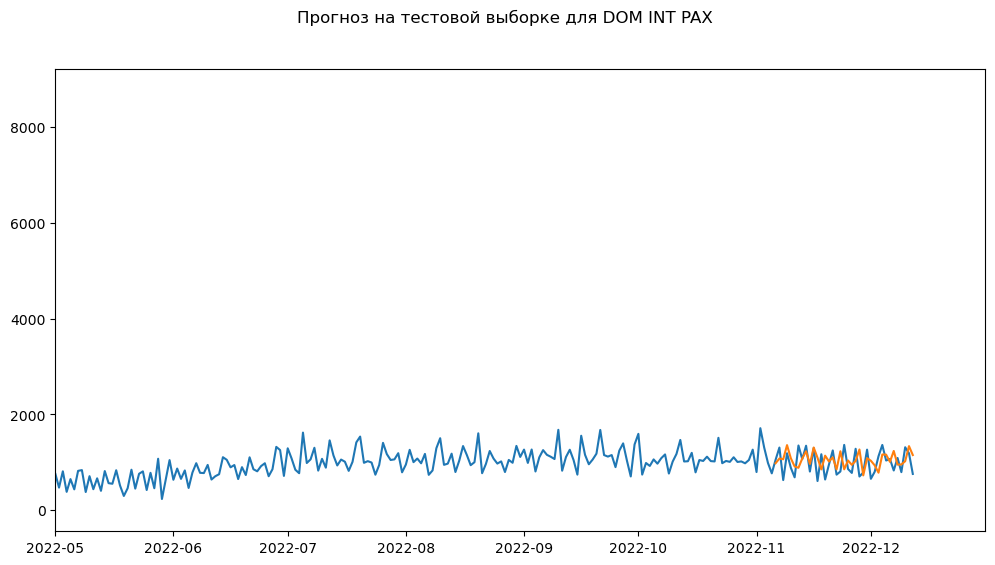

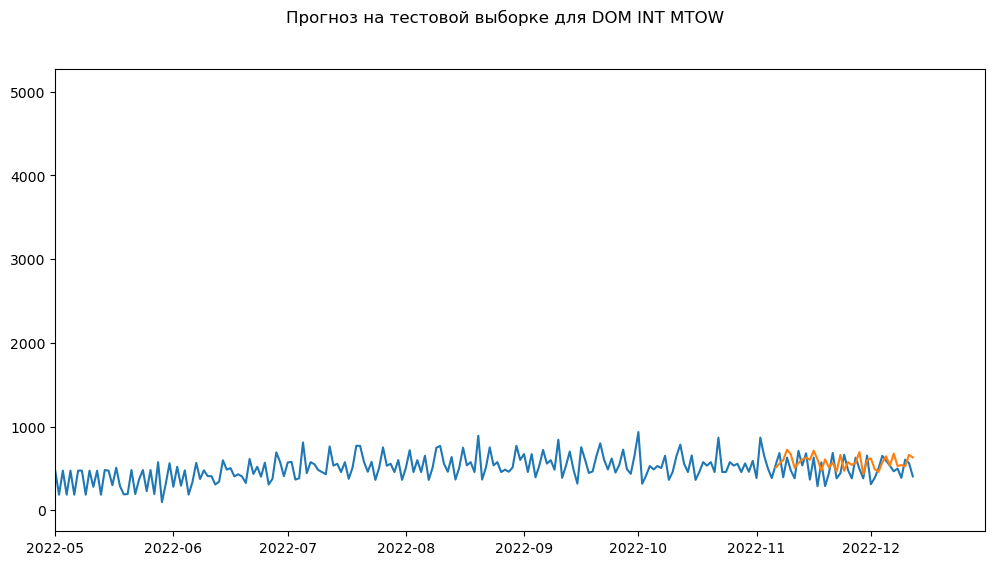

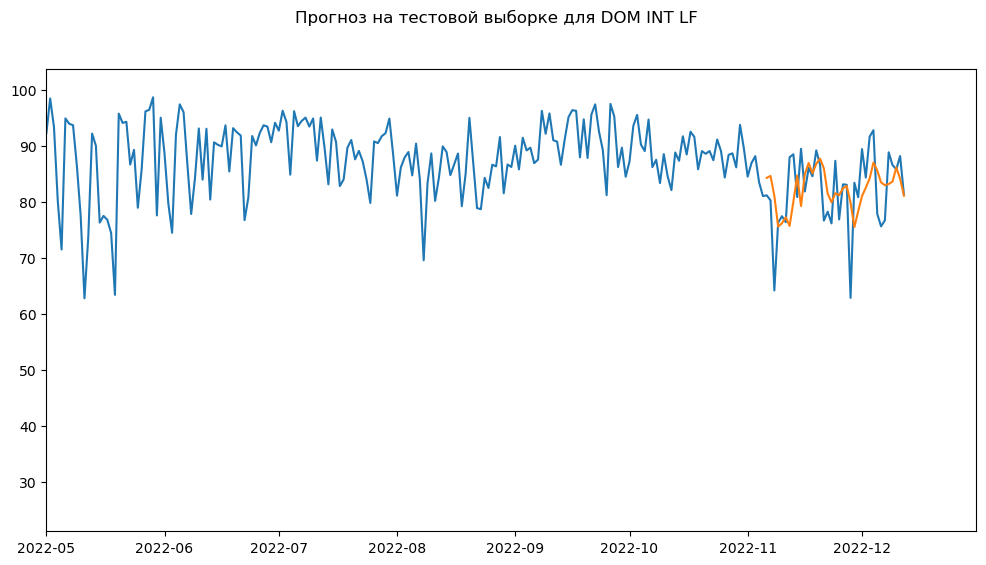

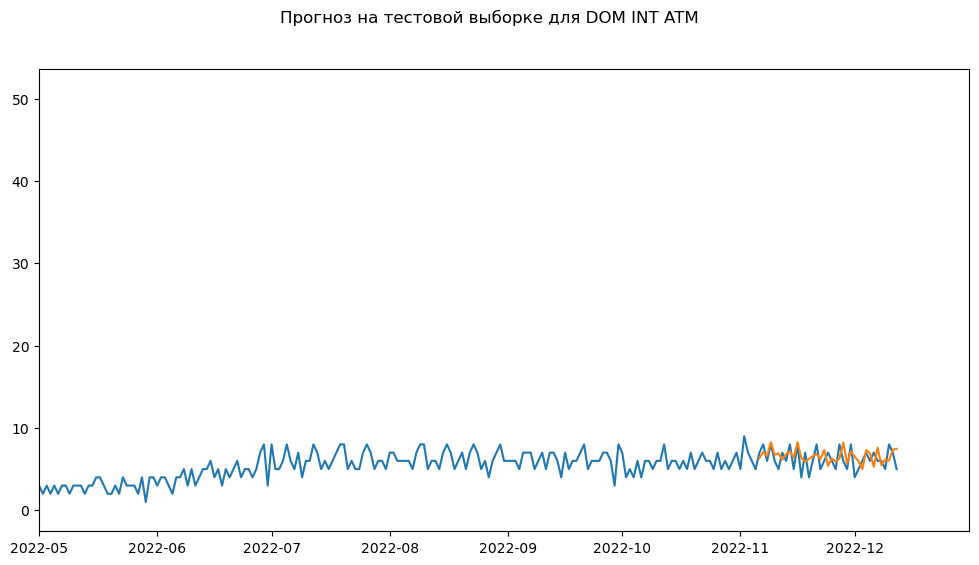

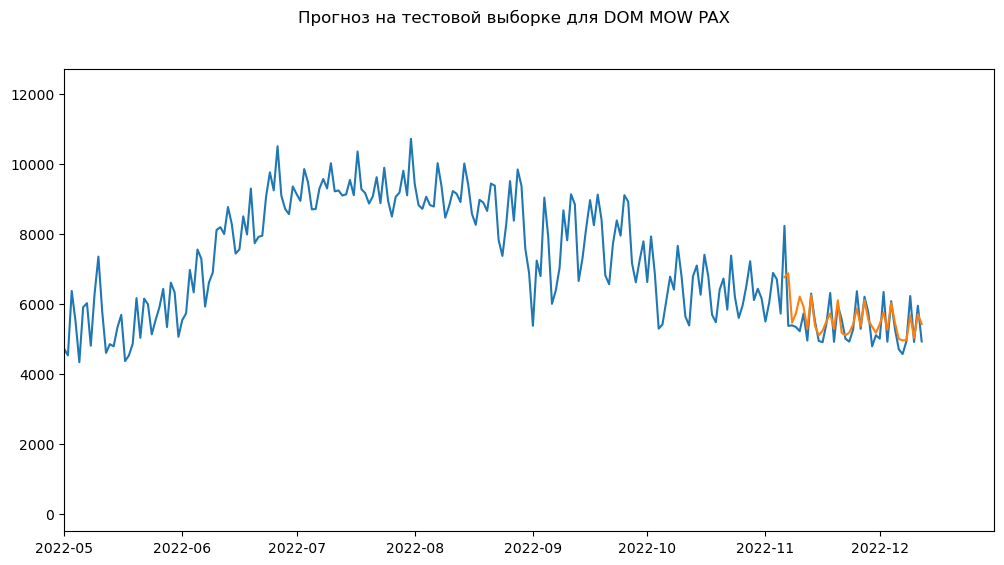

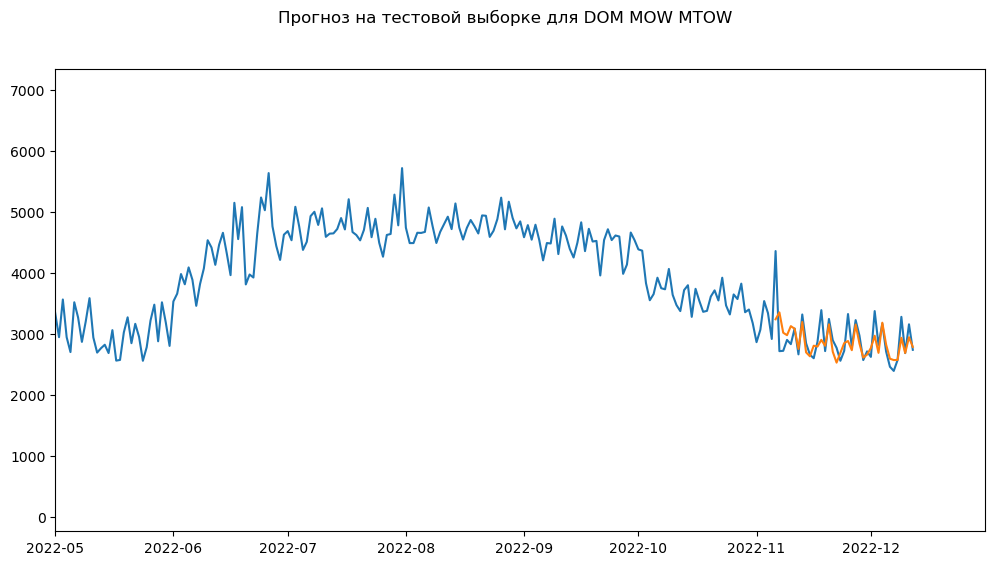

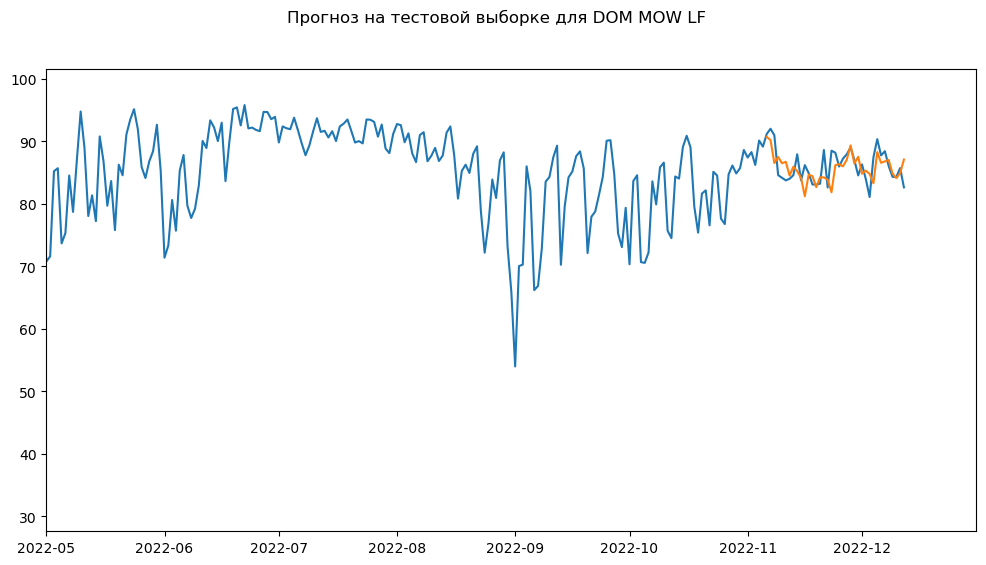

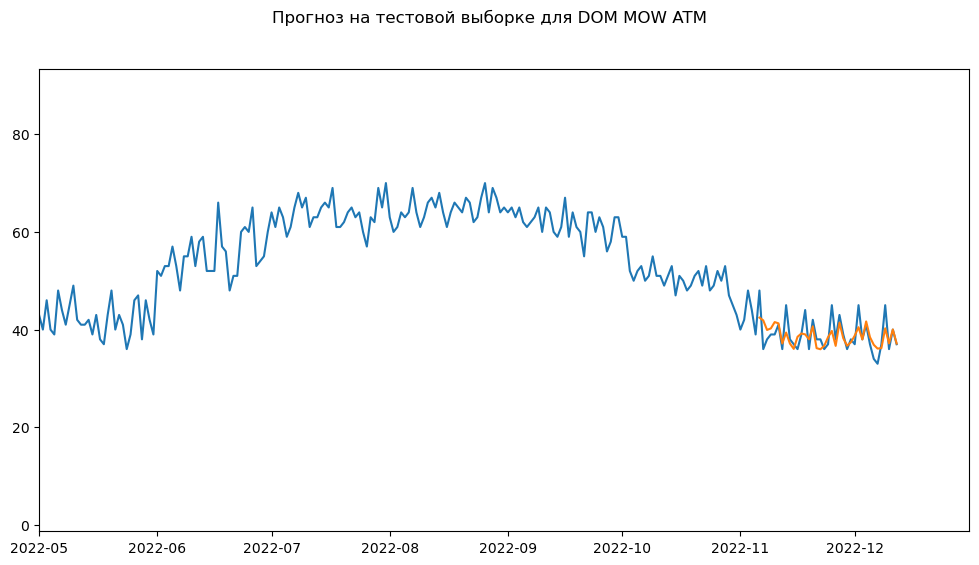

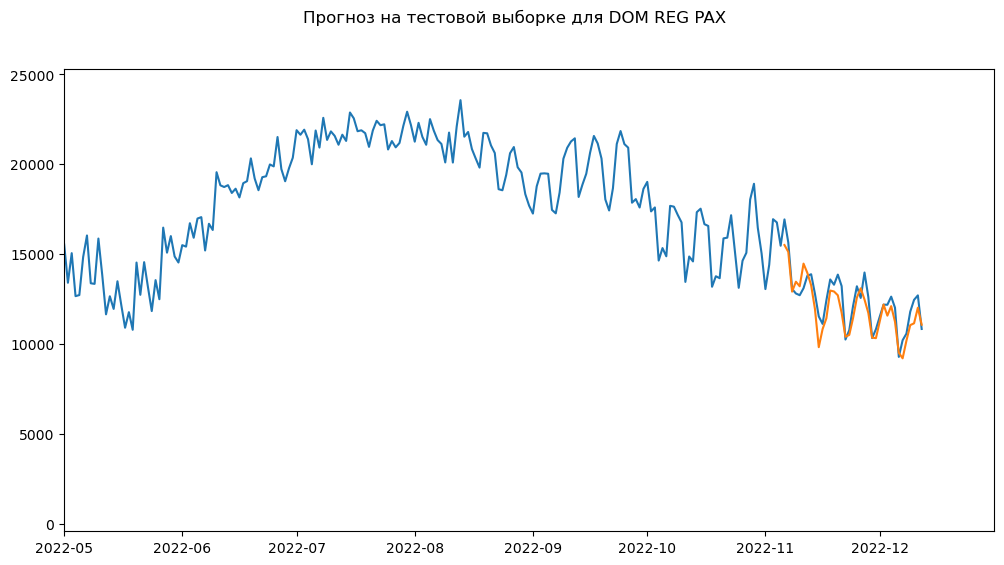

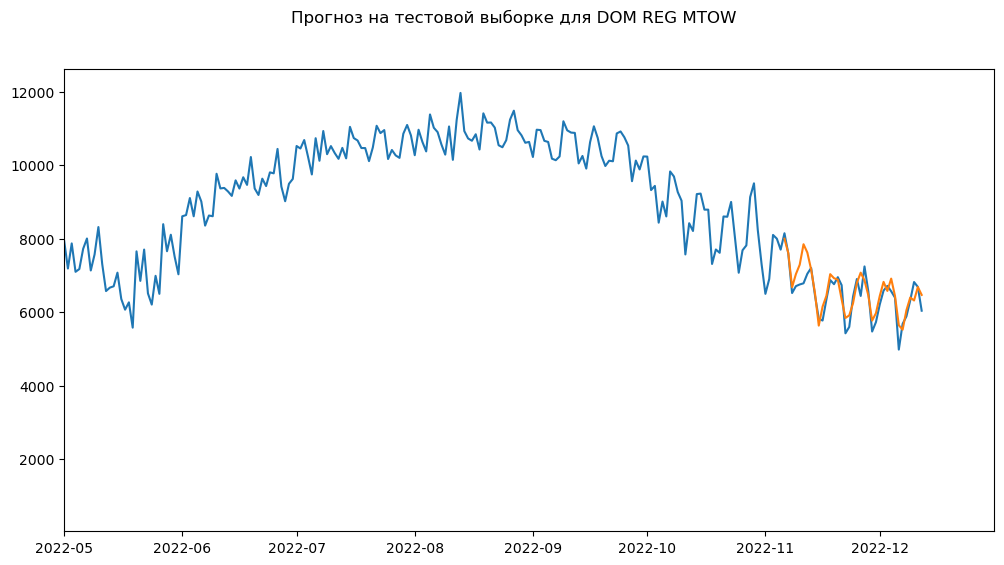

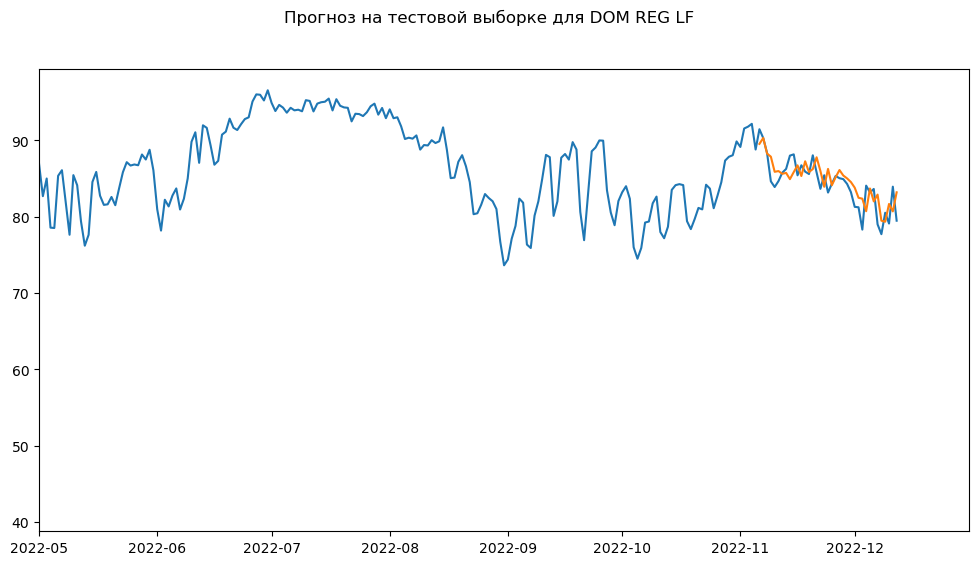

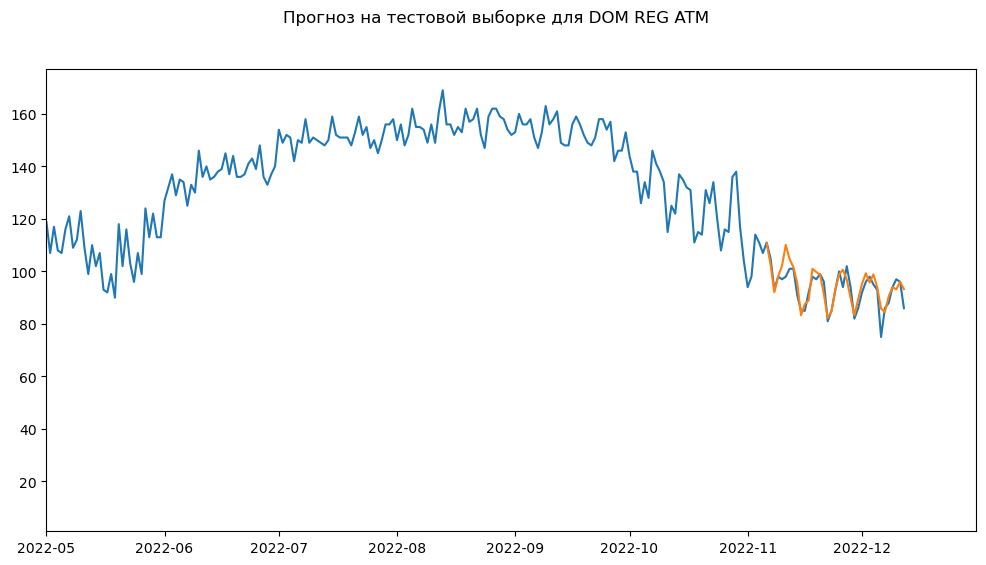

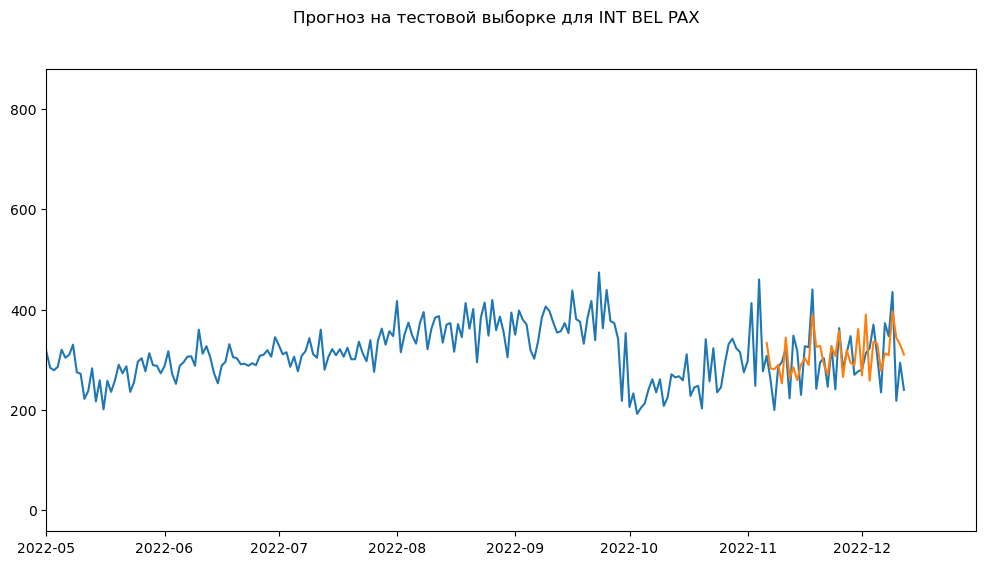

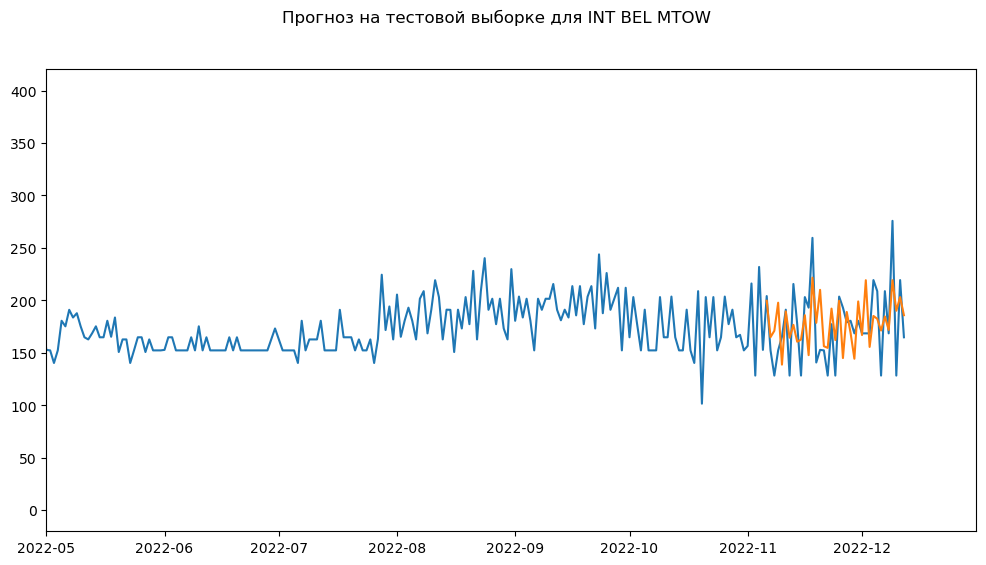

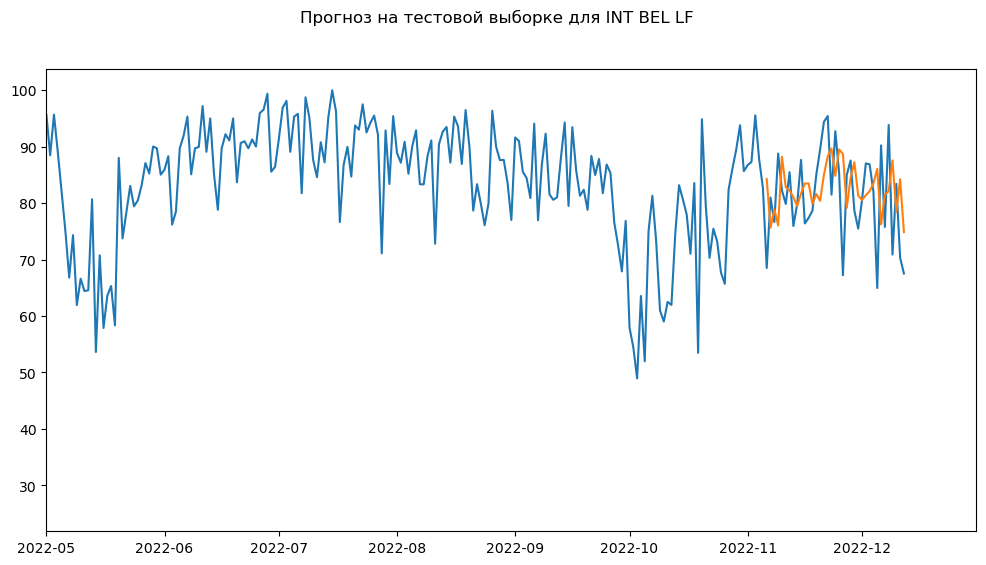

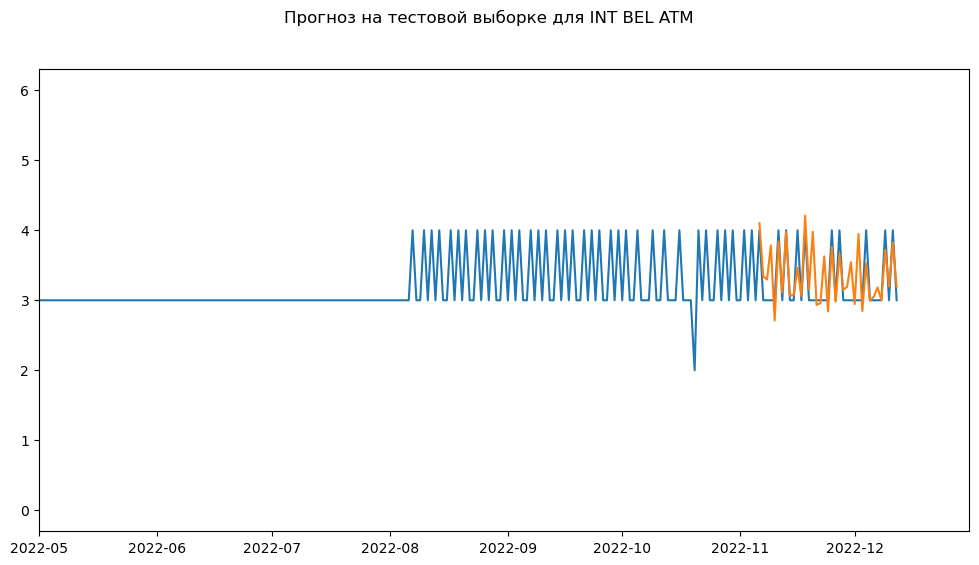

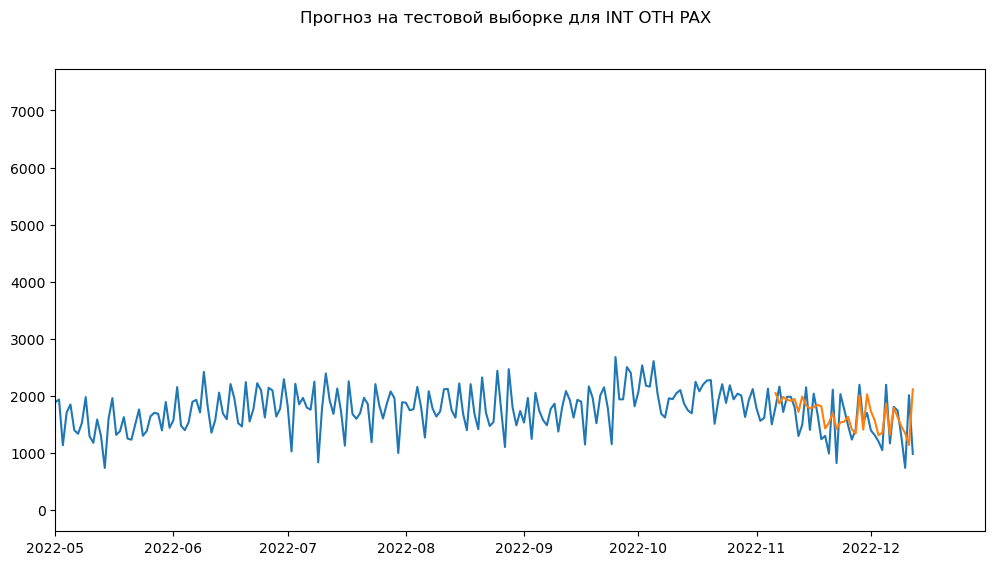

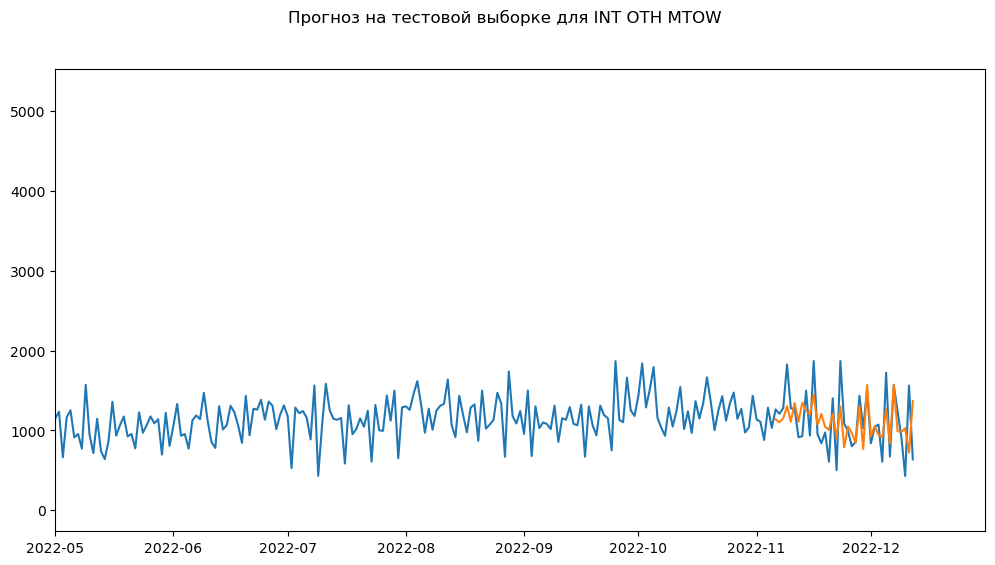

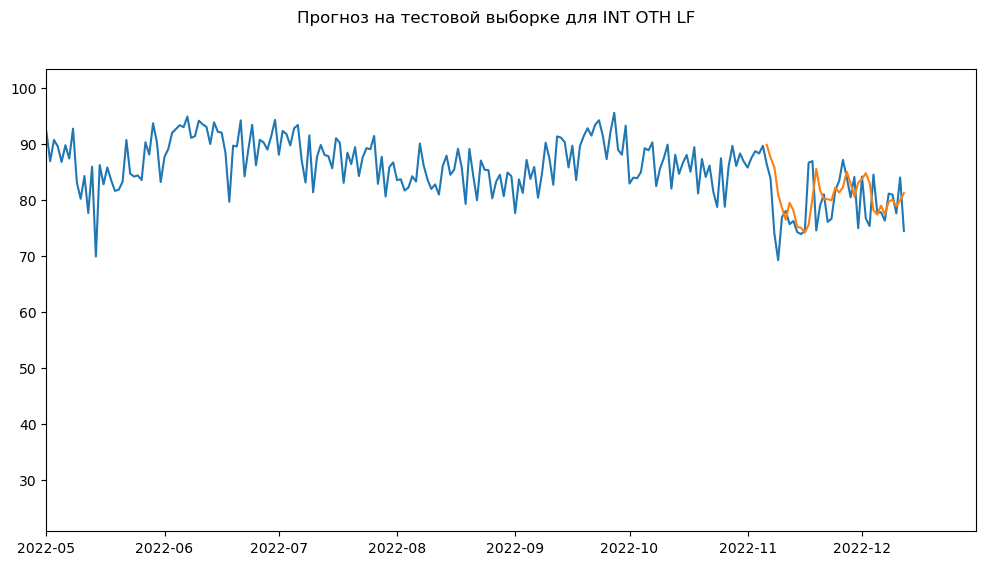

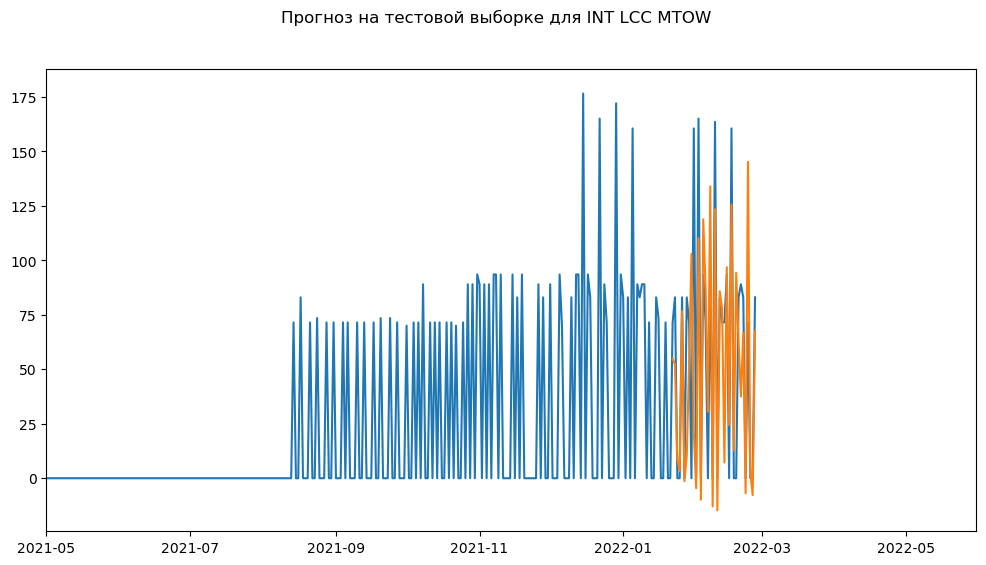

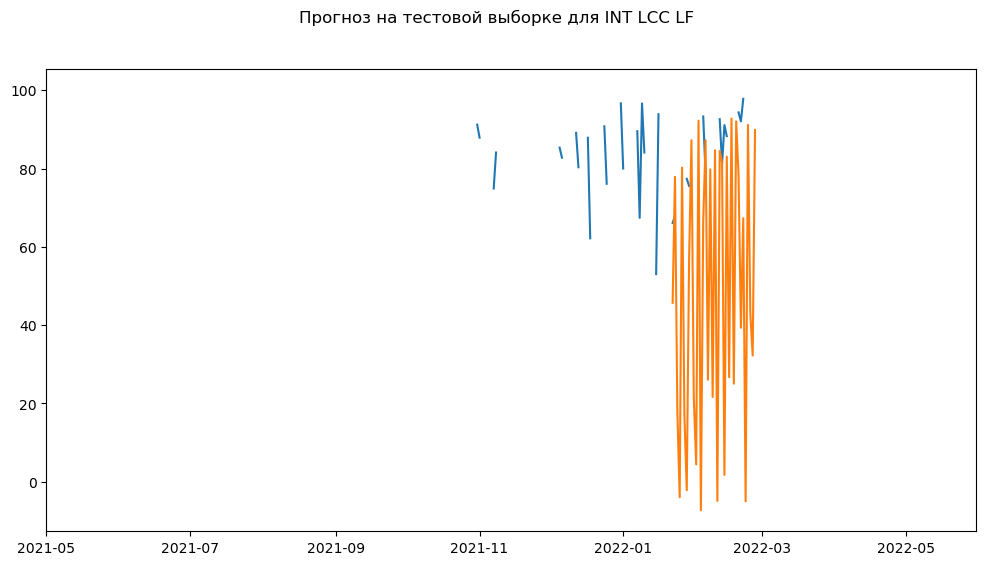

In [162]:
# визуализация результатов
for j in range (0, 6):
    for i in range (0, 4):
        x = dict_all[seg[j]][coll[i]].set_index('Time').index
        y = dict_all[seg[j]][coll[i]][coll[i]]

        fig, ax = plt.subplots(figsize = (12, 6))
        ax.plot(x, y)
        ax.plot(pred_metr[seg[j]][coll[i]].index, pred_metr[seg[j]][coll[i]]['metric'])
        if j !=5:
            ax.set_xlim([datetime.date(2022, 5, 1), datetime.date(2022, 12, 31)])
        else:
            ax.set_xlim([datetime.date(2021, 5, 1), datetime.date(2022, 5, 31)])
        fig.suptitle('Прогноз на тестовой выборке для ' + seg[j] + ' ' + coll[i])
        plt.show()

### XGBoost

https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt

#### Подготовка данных

In [103]:
xgb_all = {}
xgb_all = copy.deepcopy(dict_all)
xgb_all

{'DOM INT': {'PAX':            Time     PAX
  0    2015-01-01  4250.0
  1    2015-01-02  4118.0
  2    2015-01-03  4979.0
  3    2015-01-04  4847.0
  4    2015-01-05  3945.0
  ...         ...     ...
  2898 2022-12-08  1092.0
  2899 2022-12-09   796.0
  2900 2022-12-10  1316.0
  2901 2022-12-11  1190.0
  2902 2022-12-12   759.0
  
  [2903 rows x 2 columns],
  'MTOW':            Time      MTOW
  0    2015-01-01  2680.335
  1    2015-01-02  2370.556
  2    2015-01-03  2823.500
  3    2015-01-04  2945.733
  4    2015-01-05  2351.998
  ...         ...       ...
  2898 2022-12-08   498.500
  2899 2022-12-09   387.296
  2900 2022-12-10   604.700
  2901 2022-12-11   563.530
  2902 2022-12-12   405.000
  
  [2903 rows x 2 columns],
  'LF':            Time         LF
  0    2015-01-01  88.658526
  1    2015-01-02  90.871384
  2    2015-01-03  89.306322
  3    2015-01-04  86.493798
  4    2015-01-05  86.497978
  ...         ...        ...
  2898 2022-12-08  88.931731
  2899 2022-12-09  86.646210

In [104]:
for j in range (0, 6):
    for i in range (0, 4):
        xgb_all[seg[j]][coll[i]] = xgb_all[seg[j]][coll[i]].set_index('Time')  
        xgb_all[seg[j]][coll[i]] = xgb_all[seg[j]][coll[i]].replace(np.nan, 0)

In [105]:
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df


In [122]:
# разделение на обучающую, валидационную и тестовую выборки
x_train_dict = {}
x_val_dict = {}
x_test_dict = {}
for j in range (0, 6):
    x_train_dict[seg[j]] = {}
    x_val_dict[seg[j]] = {}
    x_test_dict[seg[j]] = {}
    
    for i in range (0, 4):
        if j != 5:
            train_len = 0.976
            val_test_len = 0.012
        else:
            train_len = 0.956
            val_test_len = 0.022
            
        thisdf = xgb_all[seg[j]][coll[i]]
        train_size = int(len(thisdf) * train_len)
        val_size = int(len(thisdf) * train_len) + int(len(thisdf) * val_test_len)

        x_train_dict[seg[j]][coll[i]] = xgb_all[seg[j]][coll[i]].iloc[0:train_size,:]
        x_train_dict[seg[j]][coll[i]] = create_features(x_train_dict[seg[j]][coll[i]])
        
        x_val_dict[seg[j]][coll[i]] = xgb_all[seg[j]][coll[i]].iloc[train_size:val_size,:]
        x_val_dict[seg[j]][coll[i]] = create_features(x_val_dict[seg[j]][coll[i]])
        
        x_test_dict[seg[j]][coll[i]] = xgb_all[seg[j]][coll[i]].iloc[val_size:len(thisdf),:]
        x_test_dict[seg[j]][coll[i]] = create_features(x_test_dict[seg[j]][coll[i]])
    # демонстрация размеров выборок
    print('\n', seg[j], coll[i])
    print('Train', 'Val', 'Test')
    print(len(x_train_dict[seg[j]][coll[i]]), len(x_val_dict[seg[j]][coll[i]]), len(x_test_dict[seg[j]][coll[i]]))
    



 DOM INT ATM
Train Val Test
2833 34 36

 DOM MOW ATM
Train Val Test
2833 34 36

 DOM REG ATM
Train Val Test
2833 34 36

 INT BEL ATM
Train Val Test
2833 34 36

 INT OTH ATM
Train Val Test
2833 34 36

 INT LCC ATM
Train Val Test
1572 36 37


In [130]:
x_train_dict[seg[3]][coll[0]]

PAX  dayofweek  month  year  dayofyear  dayofmonth
Time                                                            
2015-01-01  232.0          3      1  2015          1           1
2015-01-02  283.0          4      1  2015          2           2
2015-01-03  282.0          5      1  2015          3           3
2015-01-04  160.0          6      1  2015          4           4
2015-01-05  251.0          0      1  2015          5           5
...           ...        ...    ...   ...        ...         ...
2022-09-29  218.0          3      9  2022        272          29
2022-09-30  353.0          4      9  2022        273          30
2022-10-01  206.0          5     10  2022        274           1
2022-10-02  233.0          6     10  2022        275           2
2022-10-03  192.0          0     10  2022        276           3

[2833 rows x 6 columns]

In [124]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=x_train_dict[seg[0]][coll[0]], x='month', y='PAX', palette='Blues')
ax.set_title('PAX by Month')
plt.show()

In [125]:
# деление на зависимую переменную и признаки
FEATURES = ['dayofyear', 'dayofweek', 'dayofmonth', 'month', 'year']

x_trainX, x_trainY = {}, {}
x_valX, x_valY = {}, {}
x_testX, x_testY = {}, {}

for j in range (0, 6):
    x_trainX[seg[j]], x_trainY[seg[j]] = {}, {}
    x_valX[seg[j]], x_valY[seg[j]] = {}, {}
    x_testX[seg[j]], x_testY[seg[j]] = {}, {}
    
    for i in range (0, 4):
        x_trainX[seg[j]][coll[i]], x_trainY[seg[j]][coll[i]] = \
        x_train_dict[seg[j]][coll[i]][FEATURES], x_train_dict[seg[j]][coll[i]][coll[i]]
        
        x_valX[seg[j]][coll[i]], x_valY[seg[j]][coll[i]] = \
        x_val_dict[seg[j]][coll[i]][FEATURES], x_val_dict[seg[j]][coll[i]][coll[i]]
            
        x_testX[seg[j]][coll[i]], x_testY[seg[j]][coll[i]] = \
        x_test_dict[seg[j]][coll[i]][FEATURES], x_test_dict[seg[j]][coll[i]][coll[i]]
        
        

In [129]:
x_valX[seg[3]][coll[0]]

dayofyear  dayofweek  dayofmonth  month  year
Time                                                     
2022-10-04        277          1           4     10  2022
2022-10-05        278          2           5     10  2022
2022-10-06        279          3           6     10  2022
2022-10-07        280          4           7     10  2022
2022-10-08        281          5           8     10  2022
2022-10-09        282          6           9     10  2022
2022-10-10        283          0          10     10  2022
2022-10-11        284          1          11     10  2022
2022-10-12        285          2          12     10  2022
2022-10-13        286          3          13     10  2022
2022-10-14        287          4          14     10  2022
2022-10-15        288          5          15     10  2022
2022-10-16        289          6          16     10  2022
2022-10-17        290          0          17     10  2022
2022-10-18        291          1          18     10  2022
2022-10-19        292          2          19     10  2022
2022-10-20        293          3          20     10  2022
2022-10-21        294          4          21     10  2022
2022-10-22        295          5          22     10  2022
2022-10-23        296          6          23     10  2022
2022-10-24        297          0          24     10  2022
2022-10-25        298          1          25     10  2022
2022-10-26        299          2          26     10  2022
2022-10-27        300          3          27     10  2022
2022-10-28        301          4          28     10  2022
2022-10-29        302          5          29     10  2022
2022-10-30        303          6          30     10  2022
2022-10-31        304          0          31     10  2022
2022-11-01        305          1           1     11  2022
2022-11-02        306          2           2     11  2022
2022-11-03        307          3           3     11  2022
2022-11-04        308          4           4     11  2022
2022-11-05        309          5           5     11  2022
2022-11-06        310          6           6     11  2022

#### Подбор гиперпараметров

In [131]:
%%time

# нахождение наилучших параметров моделей XGBoost для всех сегментов
xgb_params = {}

for j in range (0, 6):
    xgb_params[seg[j]] = {} 

    for i in range (0, 4):
        params = {
        'min_child_weight': [10],
        'subsample': [0.4, 0.6, 0.8],
        'colsample_bytree': [0.5],
        'learning_rate': [0.051, 0.052, 0.053, 0.054, 0.055],
        'gamma': [0.1, 1, 3, 5, 7]
        }


        
        reg = xgb.XGBRegressor(seed=111, 
                                booster='gbtree',
                                objective='reg:squarederror',
                                n_estimators=1000,
                                max_depth = 4
                                )


        grid = GridSearchCV(reg, param_grid=params, scoring='neg_root_mean_squared_error', 
                                  n_jobs=4, verbose=0, cv = 5)
        grid_result = grid.fit(x_trainX[seg[j]][coll[i]], x_trainY[seg[j]][coll[i]], 
                                eval_set=[   (x_valX[seg[j]][coll[i]], x_valY[seg[j]][coll[i]])],
                               eval_metric = ['rmse'],
                                early_stopping_rounds=20)
        
        # результаты поиска параметров
        print(seg[j], coll[i])
        print("Лучшая ошибка: %f с параметрами %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) с: %r" % (mean, stdev, param))

        xgb_params[seg[j]][coll[i]] = grid_result.best_params_

[0]	validation_0-rmse:920.61399
[1]	validation_0-rmse:870.44352
[2]	validation_0-rmse:707.71190
[3]	validation_0-rmse:668.46412
[4]	validation_0-rmse:641.66191
[5]	validation_0-rmse:607.98520
[6]	validation_0-rmse:485.37822
[7]	validation_0-rmse:383.85344
[8]	validation_0-rmse:304.26440
[9]	validation_0-rmse:251.61736
[10]	validation_0-rmse:249.82431
[11]	validation_0-rmse:246.25122
[12]	validation_0-rmse:250.62615
[13]	validation_0-rmse:284.48791
[14]	validation_0-rmse:327.49367
[15]	validation_0-rmse:387.11267
[16]	validation_0-rmse:461.23284
[17]	validation_0-rmse:527.61065
[18]	validation_0-rmse:590.82265
[19]	validation_0-rmse:652.54241
[20]	validation_0-rmse:709.89174
[21]	validation_0-rmse:687.30228
[22]	validation_0-rmse:637.87073
[23]	validation_0-rmse:592.91282
[24]	validation_0-rmse:639.68220
[25]	validation_0-rmse:690.55230
[26]	validation_0-rmse:738.01489
[27]	validation_0-rmse:781.68584
[28]	validation_0-rmse:826.98461
[29]	validation_0-rmse:863.65769
[30]	validation_0-rm

[0]	validation_0-rmse:458.74432
[1]	validation_0-rmse:435.54088
[2]	validation_0-rmse:350.35598
[3]	validation_0-rmse:331.46244
[4]	validation_0-rmse:320.37520
[5]	validation_0-rmse:302.43701
[6]	validation_0-rmse:236.33615
[7]	validation_0-rmse:186.73472
[8]	validation_0-rmse:149.43202
[9]	validation_0-rmse:141.96304
[10]	validation_0-rmse:144.07995
[11]	validation_0-rmse:145.05764
[12]	validation_0-rmse:171.13685
[13]	validation_0-rmse:202.00101
[14]	validation_0-rmse:235.21747
[15]	validation_0-rmse:276.37265
[16]	validation_0-rmse:317.30944
[17]	validation_0-rmse:362.93812
[18]	validation_0-rmse:400.56229
[19]	validation_0-rmse:441.21322
[20]	validation_0-rmse:475.06204
[21]	validation_0-rmse:463.14944
[22]	validation_0-rmse:526.81283
[23]	validation_0-rmse:572.47947
[24]	validation_0-rmse:600.43162
[25]	validation_0-rmse:633.41937
[26]	validation_0-rmse:660.90880
[27]	validation_0-rmse:687.99106
[28]	validation_0-rmse:721.05065
[29]	validation_0-rmse:742.08570
DOM INT MTOW
Лучшая 

[0]	validation_0-rmse:83.43997
[1]	validation_0-rmse:79.38998
[2]	validation_0-rmse:75.85299
[3]	validation_0-rmse:72.38367
[4]	validation_0-rmse:68.68006
[5]	validation_0-rmse:65.58794
[6]	validation_0-rmse:62.59114
[7]	validation_0-rmse:59.85205
[8]	validation_0-rmse:57.27418
[9]	validation_0-rmse:54.50445
[10]	validation_0-rmse:51.95329
[11]	validation_0-rmse:49.52428
[12]	validation_0-rmse:47.30497
[13]	validation_0-rmse:45.14926
[14]	validation_0-rmse:43.27535
[15]	validation_0-rmse:41.44159
[16]	validation_0-rmse:39.68827
[17]	validation_0-rmse:38.02603
[18]	validation_0-rmse:36.60973
[19]	validation_0-rmse:35.09159
[20]	validation_0-rmse:33.72747
[21]	validation_0-rmse:32.28508
[22]	validation_0-rmse:31.00875
[23]	validation_0-rmse:29.55981
[24]	validation_0-rmse:28.51513
[25]	validation_0-rmse:27.44094
[26]	validation_0-rmse:26.49853
[27]	validation_0-rmse:25.42232
[28]	validation_0-rmse:24.59988
[29]	validation_0-rmse:23.82755
[30]	validation_0-rmse:22.86141
[31]	validation_0-

[0]	validation_0-rmse:4.45956
[1]	validation_0-rmse:4.16232
[2]	validation_0-rmse:3.19675
[3]	validation_0-rmse:2.96694
[4]	validation_0-rmse:2.84708
[5]	validation_0-rmse:2.65198
[6]	validation_0-rmse:1.94227
[7]	validation_0-rmse:1.42317
[8]	validation_0-rmse:1.18280
[9]	validation_0-rmse:1.34345
[10]	validation_0-rmse:1.38021
[11]	validation_0-rmse:1.40725
[12]	validation_0-rmse:1.80929
[13]	validation_0-rmse:2.26616
[14]	validation_0-rmse:2.69297
[15]	validation_0-rmse:3.17027
[16]	validation_0-rmse:3.68108
[17]	validation_0-rmse:4.12926
[18]	validation_0-rmse:4.55326
[19]	validation_0-rmse:4.99830
[20]	validation_0-rmse:5.37630
[21]	validation_0-rmse:5.23248
[22]	validation_0-rmse:5.55033
[23]	validation_0-rmse:5.85036
[24]	validation_0-rmse:6.16614
[25]	validation_0-rmse:6.49181
[26]	validation_0-rmse:6.81567
[27]	validation_0-rmse:7.09821
[28]	validation_0-rmse:7.39671
DOM INT ATM
Лучшая ошибка: -13.955836 с параметрами {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.

[0]	validation_0-rmse:6128.86269
[1]	validation_0-rmse:5830.42586
[2]	validation_0-rmse:5574.96584
[3]	validation_0-rmse:5306.51286
[4]	validation_0-rmse:4946.31279
[5]	validation_0-rmse:4701.34636
[6]	validation_0-rmse:4501.93817
[7]	validation_0-rmse:4312.19660
[8]	validation_0-rmse:4131.71524
[9]	validation_0-rmse:3955.38830
[10]	validation_0-rmse:3762.32028
[11]	validation_0-rmse:3580.75151
[12]	validation_0-rmse:3429.40853
[13]	validation_0-rmse:3292.79778
[14]	validation_0-rmse:3162.69616
[15]	validation_0-rmse:3033.12441
[16]	validation_0-rmse:2911.63630
[17]	validation_0-rmse:2800.80190
[18]	validation_0-rmse:2695.33799
[19]	validation_0-rmse:2589.91890
[20]	validation_0-rmse:2496.78363
[21]	validation_0-rmse:2379.86562
[22]	validation_0-rmse:2221.60511
[23]	validation_0-rmse:2042.74206
[24]	validation_0-rmse:1965.04464
[25]	validation_0-rmse:1891.77273
[26]	validation_0-rmse:1821.73905
[27]	validation_0-rmse:1757.43407
[28]	validation_0-rmse:1696.76067
[29]	validation_0-rmse:1

[0]	validation_0-rmse:3382.53346
[1]	validation_0-rmse:3210.29834
[2]	validation_0-rmse:3047.91756
[3]	validation_0-rmse:2899.47655
[4]	validation_0-rmse:2766.54425
[5]	validation_0-rmse:2637.77437
[6]	validation_0-rmse:2515.65425
[7]	validation_0-rmse:2392.19723
[8]	validation_0-rmse:2280.83878
[9]	validation_0-rmse:2174.86835
[10]	validation_0-rmse:2073.64030
[11]	validation_0-rmse:1969.82925
[12]	validation_0-rmse:1881.61845
[13]	validation_0-rmse:1796.16659
[14]	validation_0-rmse:1714.00422
[15]	validation_0-rmse:1636.44110
[16]	validation_0-rmse:1563.10652
[17]	validation_0-rmse:1493.21687
[18]	validation_0-rmse:1424.49614
[19]	validation_0-rmse:1361.42381
[20]	validation_0-rmse:1301.66977
[21]	validation_0-rmse:1246.04227
[22]	validation_0-rmse:1200.62130
[23]	validation_0-rmse:1116.46813
[24]	validation_0-rmse:1070.43089
[25]	validation_0-rmse:1021.87044
[26]	validation_0-rmse:980.81282
[27]	validation_0-rmse:940.01508
[28]	validation_0-rmse:901.18835
[29]	validation_0-rmse:866.

[0]	validation_0-rmse:78.38059
[1]	validation_0-rmse:74.23043
[2]	validation_0-rmse:70.45879
[3]	validation_0-rmse:66.75681
[4]	validation_0-rmse:63.43523
[5]	validation_0-rmse:60.12197
[6]	validation_0-rmse:57.10946
[7]	validation_0-rmse:54.30215
[8]	validation_0-rmse:51.61608
[9]	validation_0-rmse:49.08443
[10]	validation_0-rmse:46.56093
[11]	validation_0-rmse:44.18534
[12]	validation_0-rmse:42.12952
[13]	validation_0-rmse:40.11244
[14]	validation_0-rmse:38.22385
[15]	validation_0-rmse:36.37617
[16]	validation_0-rmse:34.66840
[17]	validation_0-rmse:33.12566
[18]	validation_0-rmse:31.61588
[19]	validation_0-rmse:30.18325
[20]	validation_0-rmse:28.91605
[21]	validation_0-rmse:27.56200
[22]	validation_0-rmse:26.17670
[23]	validation_0-rmse:24.81557
[24]	validation_0-rmse:23.73822
[25]	validation_0-rmse:22.73717
[26]	validation_0-rmse:21.77206
[27]	validation_0-rmse:20.87780
[28]	validation_0-rmse:20.02752
[29]	validation_0-rmse:19.23644
[30]	validation_0-rmse:18.40674
[31]	validation_0-

[0]	validation_0-rmse:46.32761
[1]	validation_0-rmse:44.06476
[2]	validation_0-rmse:41.95259
[3]	validation_0-rmse:39.91712
[4]	validation_0-rmse:37.50006
[5]	validation_0-rmse:35.64375
[6]	validation_0-rmse:33.97059
[7]	validation_0-rmse:32.40905
[8]	validation_0-rmse:30.94190
[9]	validation_0-rmse:29.53138
[10]	validation_0-rmse:28.08095
[11]	validation_0-rmse:26.69825
[12]	validation_0-rmse:25.50704
[13]	validation_0-rmse:24.36477
[14]	validation_0-rmse:23.29568
[15]	validation_0-rmse:22.26322
[16]	validation_0-rmse:21.26235
[17]	validation_0-rmse:20.33316
[18]	validation_0-rmse:19.46500
[19]	validation_0-rmse:18.64101
[20]	validation_0-rmse:17.85152
[21]	validation_0-rmse:16.98611
[22]	validation_0-rmse:15.77126
[23]	validation_0-rmse:14.65806
[24]	validation_0-rmse:13.96643
[25]	validation_0-rmse:13.37890
[26]	validation_0-rmse:12.81820
[27]	validation_0-rmse:12.28888
[28]	validation_0-rmse:11.73629
[29]	validation_0-rmse:11.25601
[30]	validation_0-rmse:10.71734
[31]	validation_0-

[0]	validation_0-rmse:15370.66901
[1]	validation_0-rmse:14605.09932
[2]	validation_0-rmse:14193.45953
[3]	validation_0-rmse:13476.66998
[4]	validation_0-rmse:12890.36087
[5]	validation_0-rmse:12268.58127
[6]	validation_0-rmse:11930.06155
[7]	validation_0-rmse:11624.53722
[8]	validation_0-rmse:11312.49068
[9]	validation_0-rmse:11029.62538
[10]	validation_0-rmse:10495.18770
[11]	validation_0-rmse:10000.49703
[12]	validation_0-rmse:9779.92889
[13]	validation_0-rmse:9570.74087
[14]	validation_0-rmse:9339.46483
[15]	validation_0-rmse:9106.93824
[16]	validation_0-rmse:8940.94367
[17]	validation_0-rmse:8751.35272
[18]	validation_0-rmse:8594.65248
[19]	validation_0-rmse:8411.61991
[20]	validation_0-rmse:8265.19635
[21]	validation_0-rmse:7885.75216
[22]	validation_0-rmse:7435.58476
[23]	validation_0-rmse:7127.50945
[24]	validation_0-rmse:7016.36115
[25]	validation_0-rmse:6894.83030
[26]	validation_0-rmse:6781.07716
[27]	validation_0-rmse:6666.35445
[28]	validation_0-rmse:6542.84029
[29]	validat

[0]	validation_0-rmse:8094.11738
[1]	validation_0-rmse:7686.16109
[2]	validation_0-rmse:7446.06503
[3]	validation_0-rmse:7072.76797
[4]	validation_0-rmse:6749.36119
[5]	validation_0-rmse:6414.02777
[6]	validation_0-rmse:6218.18812
[7]	validation_0-rmse:6027.23705
[8]	validation_0-rmse:5841.86323
[9]	validation_0-rmse:5674.08616
[10]	validation_0-rmse:5395.21661
[11]	validation_0-rmse:5133.38103
[12]	validation_0-rmse:4990.07336
[13]	validation_0-rmse:4853.89068
[14]	validation_0-rmse:4718.88895
[15]	validation_0-rmse:4592.84592
[16]	validation_0-rmse:4477.14117
[17]	validation_0-rmse:4369.14176
[18]	validation_0-rmse:4265.13296
[19]	validation_0-rmse:4167.17319
[20]	validation_0-rmse:4076.55845
[21]	validation_0-rmse:3886.77364
[22]	validation_0-rmse:3655.61741
[23]	validation_0-rmse:3488.93794
[24]	validation_0-rmse:3411.27904
[25]	validation_0-rmse:3338.09855
[26]	validation_0-rmse:3272.90828
[27]	validation_0-rmse:3210.52824
[28]	validation_0-rmse:3154.12900
[29]	validation_0-rmse:3

[0]	validation_0-rmse:79.00382
[1]	validation_0-rmse:74.83410
[2]	validation_0-rmse:71.33312
[3]	validation_0-rmse:67.56266
[4]	validation_0-rmse:64.23003
[5]	validation_0-rmse:60.85647
[6]	validation_0-rmse:58.10252
[7]	validation_0-rmse:55.40671
[8]	validation_0-rmse:52.78996
[9]	validation_0-rmse:50.34402
[10]	validation_0-rmse:47.71837
[11]	validation_0-rmse:45.23884
[12]	validation_0-rmse:43.27303
[13]	validation_0-rmse:41.34261
[14]	validation_0-rmse:39.46474
[15]	validation_0-rmse:37.76433
[16]	validation_0-rmse:36.19371
[17]	validation_0-rmse:34.73244
[18]	validation_0-rmse:33.26154
[19]	validation_0-rmse:31.88336
[20]	validation_0-rmse:30.64576
[21]	validation_0-rmse:29.12224
[22]	validation_0-rmse:27.63399
[23]	validation_0-rmse:26.22351
[24]	validation_0-rmse:25.15628
[25]	validation_0-rmse:24.23542
[26]	validation_0-rmse:23.35998
[27]	validation_0-rmse:22.51153
[28]	validation_0-rmse:21.74076
[29]	validation_0-rmse:21.00256
[30]	validation_0-rmse:20.01224
[31]	validation_0-

[258]	validation_0-rmse:3.29457
[259]	validation_0-rmse:3.29415
[260]	validation_0-rmse:3.29168
[261]	validation_0-rmse:3.29097
[262]	validation_0-rmse:3.28685
[263]	validation_0-rmse:3.29442
[264]	validation_0-rmse:3.29814
[265]	validation_0-rmse:3.29756
[266]	validation_0-rmse:3.30768
[267]	validation_0-rmse:3.30459
[268]	validation_0-rmse:3.30292
[269]	validation_0-rmse:3.30857
[270]	validation_0-rmse:3.30006
[271]	validation_0-rmse:3.30115
[272]	validation_0-rmse:3.30260
[273]	validation_0-rmse:3.30238
[274]	validation_0-rmse:3.30452
[275]	validation_0-rmse:3.30650
[276]	validation_0-rmse:3.30739
[277]	validation_0-rmse:3.32729
[278]	validation_0-rmse:3.32842
[279]	validation_0-rmse:3.32883
[280]	validation_0-rmse:3.32317
[281]	validation_0-rmse:3.32323
[282]	validation_0-rmse:3.31230
DOM REG LF
Лучшая ошибка: -7.422252 с параметрами {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.053, 'min_child_weight': 10, 'subsample': 0.8}
-7.479243 (2.577670) с: {'colsample_bytree':

[0]	validation_0-rmse:118.67617
[1]	validation_0-rmse:112.75739
[2]	validation_0-rmse:108.98782
[3]	validation_0-rmse:103.47977
[4]	validation_0-rmse:98.70617
[5]	validation_0-rmse:93.91499
[6]	validation_0-rmse:90.88159
[7]	validation_0-rmse:87.96666
[8]	validation_0-rmse:85.21327
[9]	validation_0-rmse:82.74813
[10]	validation_0-rmse:78.70625
[11]	validation_0-rmse:74.91679
[12]	validation_0-rmse:72.79609
[13]	validation_0-rmse:70.74142
[14]	validation_0-rmse:68.74386
[15]	validation_0-rmse:66.67395
[16]	validation_0-rmse:64.97529
[17]	validation_0-rmse:63.23746
[18]	validation_0-rmse:61.61702
[19]	validation_0-rmse:59.99767
[20]	validation_0-rmse:58.61480
[21]	validation_0-rmse:55.86461
[22]	validation_0-rmse:52.55609
[23]	validation_0-rmse:49.43138
[24]	validation_0-rmse:48.33734
[25]	validation_0-rmse:47.21459
[26]	validation_0-rmse:46.08736
[27]	validation_0-rmse:45.04322
[28]	validation_0-rmse:44.04178
[29]	validation_0-rmse:43.19302
[30]	validation_0-rmse:41.20366
[31]	validatio

[0]	validation_0-rmse:267.56795
[1]	validation_0-rmse:254.06183
[2]	validation_0-rmse:241.15433
[3]	validation_0-rmse:229.02346
[4]	validation_0-rmse:213.25929
[5]	validation_0-rmse:203.20563
[6]	validation_0-rmse:193.85566
[7]	validation_0-rmse:184.56636
[8]	validation_0-rmse:176.00136
[9]	validation_0-rmse:167.34659
[10]	validation_0-rmse:159.62185
[11]	validation_0-rmse:152.21966
[12]	validation_0-rmse:146.00570
[13]	validation_0-rmse:139.31285
[14]	validation_0-rmse:133.33190
[15]	validation_0-rmse:128.16196
[16]	validation_0-rmse:122.32818
[17]	validation_0-rmse:117.16885
[18]	validation_0-rmse:112.43530
[19]	validation_0-rmse:108.70995
[20]	validation_0-rmse:104.81969
[21]	validation_0-rmse:101.39332
[22]	validation_0-rmse:93.88037
[23]	validation_0-rmse:87.11261
[24]	validation_0-rmse:84.04010
[25]	validation_0-rmse:81.47772
[26]	validation_0-rmse:78.87967
[27]	validation_0-rmse:76.54326
[28]	validation_0-rmse:73.82076
[29]	validation_0-rmse:71.93513
[30]	validation_0-rmse:70.26

[0]	validation_0-rmse:163.42143
[1]	validation_0-rmse:155.63272
[2]	validation_0-rmse:146.77057
[3]	validation_0-rmse:139.88297
[4]	validation_0-rmse:131.29444
[5]	validation_0-rmse:125.26938
[6]	validation_0-rmse:118.20948
[7]	validation_0-rmse:111.77746
[8]	validation_0-rmse:106.07225
[9]	validation_0-rmse:100.01763
[10]	validation_0-rmse:95.57650
[11]	validation_0-rmse:91.30458
[12]	validation_0-rmse:86.28881
[13]	validation_0-rmse:81.73277
[14]	validation_0-rmse:77.89543
[15]	validation_0-rmse:74.22569
[16]	validation_0-rmse:70.07480
[17]	validation_0-rmse:66.37886
[18]	validation_0-rmse:62.92970
[19]	validation_0-rmse:59.59515
[20]	validation_0-rmse:56.70052
[21]	validation_0-rmse:54.59598
[22]	validation_0-rmse:51.18228
[23]	validation_0-rmse:47.87070
[24]	validation_0-rmse:45.64471
[25]	validation_0-rmse:43.44986
[26]	validation_0-rmse:41.32397
[27]	validation_0-rmse:39.77251
[28]	validation_0-rmse:38.01100
[29]	validation_0-rmse:36.63895
[30]	validation_0-rmse:35.76228
[31]	val

[0]	validation_0-rmse:73.50750
[1]	validation_0-rmse:69.64842
[2]	validation_0-rmse:66.88713
[3]	validation_0-rmse:63.44184
[4]	validation_0-rmse:59.81837
[5]	validation_0-rmse:56.77902
[6]	validation_0-rmse:54.63311
[7]	validation_0-rmse:52.58265
[8]	validation_0-rmse:50.61410
[9]	validation_0-rmse:48.67096
[10]	validation_0-rmse:46.19598
[11]	validation_0-rmse:43.88391
[12]	validation_0-rmse:42.29161
[13]	validation_0-rmse:40.96827
[14]	validation_0-rmse:39.54903
[15]	validation_0-rmse:38.28790
[16]	validation_0-rmse:36.98920
[17]	validation_0-rmse:35.58312
[18]	validation_0-rmse:34.46447
[19]	validation_0-rmse:33.44983
[20]	validation_0-rmse:32.56670
[21]	validation_0-rmse:31.04185
[22]	validation_0-rmse:29.26173
[23]	validation_0-rmse:27.61798
[24]	validation_0-rmse:26.86983
[25]	validation_0-rmse:26.10349
[26]	validation_0-rmse:25.33522
[27]	validation_0-rmse:24.66114
[28]	validation_0-rmse:23.93795
[29]	validation_0-rmse:23.34718
[30]	validation_0-rmse:22.31173
[31]	validation_0-

[0]	validation_0-rmse:2.72819
[1]	validation_0-rmse:2.61151
[2]	validation_0-rmse:2.48513
[3]	validation_0-rmse:2.38003
[4]	validation_0-rmse:2.26920
[5]	validation_0-rmse:2.17577
[6]	validation_0-rmse:2.07054
[7]	validation_0-rmse:1.97436
[8]	validation_0-rmse:1.88873
[9]	validation_0-rmse:1.79863
[10]	validation_0-rmse:1.72913
[11]	validation_0-rmse:1.66411
[12]	validation_0-rmse:1.58761
[13]	validation_0-rmse:1.51948
[14]	validation_0-rmse:1.45985
[15]	validation_0-rmse:1.39666
[16]	validation_0-rmse:1.33212
[17]	validation_0-rmse:1.27208
[18]	validation_0-rmse:1.21871
[19]	validation_0-rmse:1.16765
[20]	validation_0-rmse:1.12419
[21]	validation_0-rmse:1.08861
[22]	validation_0-rmse:1.03890
[23]	validation_0-rmse:0.98871
[24]	validation_0-rmse:0.95283
[25]	validation_0-rmse:0.91669
[26]	validation_0-rmse:0.88031
[27]	validation_0-rmse:0.84876
[28]	validation_0-rmse:0.81792
[29]	validation_0-rmse:0.79359
[30]	validation_0-rmse:0.77550
[31]	validation_0-rmse:0.75240
[32]	validation_0-

[0]	validation_0-rmse:1808.66052
[1]	validation_0-rmse:1736.28413
[2]	validation_0-rmse:1600.87624
[3]	validation_0-rmse:1538.66187
[4]	validation_0-rmse:1468.63370
[5]	validation_0-rmse:1414.36838
[6]	validation_0-rmse:1314.22543
[7]	validation_0-rmse:1219.10688
[8]	validation_0-rmse:1130.32994
[9]	validation_0-rmse:1032.68656
[10]	validation_0-rmse:1003.42700
[11]	validation_0-rmse:974.65709
[12]	validation_0-rmse:898.12500
[13]	validation_0-rmse:826.94122
[14]	validation_0-rmse:762.67364
[15]	validation_0-rmse:707.76372
[16]	validation_0-rmse:648.22763
[17]	validation_0-rmse:591.44472
[18]	validation_0-rmse:529.38860
[19]	validation_0-rmse:487.05831
[20]	validation_0-rmse:448.95824
[21]	validation_0-rmse:450.98967
[22]	validation_0-rmse:454.60367
[23]	validation_0-rmse:449.62394
[24]	validation_0-rmse:418.87314
[25]	validation_0-rmse:389.79141
[26]	validation_0-rmse:369.82837
[27]	validation_0-rmse:353.73299
[28]	validation_0-rmse:339.73373
[29]	validation_0-rmse:325.57265
[30]	vali

[0]	validation_0-rmse:1141.13274
[1]	validation_0-rmse:1090.59814
[2]	validation_0-rmse:995.81800
[3]	validation_0-rmse:953.14499
[4]	validation_0-rmse:909.41671
[5]	validation_0-rmse:870.93888
[6]	validation_0-rmse:801.39508
[7]	validation_0-rmse:736.50969
[8]	validation_0-rmse:675.26753
[9]	validation_0-rmse:609.91711
[10]	validation_0-rmse:589.14522
[11]	validation_0-rmse:569.58410
[12]	validation_0-rmse:517.82556
[13]	validation_0-rmse:473.50147
[14]	validation_0-rmse:430.92841
[15]	validation_0-rmse:395.38116
[16]	validation_0-rmse:360.37049
[17]	validation_0-rmse:330.31253
[18]	validation_0-rmse:302.36228
[19]	validation_0-rmse:281.42876
[20]	validation_0-rmse:262.71529
[21]	validation_0-rmse:263.37999
[22]	validation_0-rmse:258.57302
[23]	validation_0-rmse:253.32974
[24]	validation_0-rmse:241.70896
[25]	validation_0-rmse:233.24430
[26]	validation_0-rmse:227.42363
[27]	validation_0-rmse:225.87214
[28]	validation_0-rmse:226.49126
[29]	validation_0-rmse:229.50637
[30]	validation_0-

[0]	validation_0-rmse:81.69463
[1]	validation_0-rmse:77.49384
[2]	validation_0-rmse:73.70484
[3]	validation_0-rmse:69.92536
[4]	validation_0-rmse:66.10741
[5]	validation_0-rmse:62.77590
[6]	validation_0-rmse:59.76540
[7]	validation_0-rmse:56.98211
[8]	validation_0-rmse:54.53598
[9]	validation_0-rmse:51.92305
[10]	validation_0-rmse:49.39028
[11]	validation_0-rmse:46.95147
[12]	validation_0-rmse:44.79114
[13]	validation_0-rmse:42.72393
[14]	validation_0-rmse:40.96295
[15]	validation_0-rmse:39.12637
[16]	validation_0-rmse:37.35276
[17]	validation_0-rmse:35.65970
[18]	validation_0-rmse:34.17357
[19]	validation_0-rmse:32.60271
[20]	validation_0-rmse:31.32463
[21]	validation_0-rmse:29.82006
[22]	validation_0-rmse:28.14398
[23]	validation_0-rmse:26.54279
[24]	validation_0-rmse:25.40038
[25]	validation_0-rmse:24.30646
[26]	validation_0-rmse:23.33132
[27]	validation_0-rmse:22.41626
[28]	validation_0-rmse:21.49120
[29]	validation_0-rmse:20.74510
[30]	validation_0-rmse:19.77906
[31]	validation_0-

[0]	validation_0-rmse:9.84775
[1]	validation_0-rmse:9.45916
[2]	validation_0-rmse:8.42215
[3]	validation_0-rmse:8.13488
[4]	validation_0-rmse:7.74792
[5]	validation_0-rmse:7.45070
[6]	validation_0-rmse:6.57868
[7]	validation_0-rmse:5.80958
[8]	validation_0-rmse:5.10080
[9]	validation_0-rmse:4.34032
[10]	validation_0-rmse:4.21183
[11]	validation_0-rmse:4.07902
[12]	validation_0-rmse:3.50519
[13]	validation_0-rmse:2.97939
[14]	validation_0-rmse:2.53408
[15]	validation_0-rmse:2.22673
[16]	validation_0-rmse:1.91912
[17]	validation_0-rmse:1.79080
[18]	validation_0-rmse:1.71963
[19]	validation_0-rmse:1.85561
[20]	validation_0-rmse:2.06280
[21]	validation_0-rmse:2.01584
[22]	validation_0-rmse:2.05279
[23]	validation_0-rmse:2.09602
[24]	validation_0-rmse:2.32991
[25]	validation_0-rmse:2.58645
[26]	validation_0-rmse:2.76830
[27]	validation_0-rmse:2.93749
[28]	validation_0-rmse:3.16874
[29]	validation_0-rmse:3.32343
[30]	validation_0-rmse:3.19789
[31]	validation_0-rmse:3.37910
[32]	validation_0-

[0]	validation_0-rmse:157.25254
[1]	validation_0-rmse:154.71378
[2]	validation_0-rmse:150.92400
[3]	validation_0-rmse:147.67814
[4]	validation_0-rmse:147.29965
[5]	validation_0-rmse:144.82614
[6]	validation_0-rmse:142.61210
[7]	validation_0-rmse:140.60034
[8]	validation_0-rmse:138.81578
[9]	validation_0-rmse:137.18950
[10]	validation_0-rmse:137.16145
[11]	validation_0-rmse:137.38469
[12]	validation_0-rmse:135.54108
[13]	validation_0-rmse:134.60485
[14]	validation_0-rmse:133.14573
[15]	validation_0-rmse:131.58081
[16]	validation_0-rmse:130.32623
[17]	validation_0-rmse:129.29956
[18]	validation_0-rmse:129.65801
[19]	validation_0-rmse:130.03671
[20]	validation_0-rmse:130.49806
[21]	validation_0-rmse:129.81210
[22]	validation_0-rmse:129.01451
[23]	validation_0-rmse:128.39556
[24]	validation_0-rmse:127.52950
[25]	validation_0-rmse:127.13195
[26]	validation_0-rmse:127.39711
[27]	validation_0-rmse:127.71093
[28]	validation_0-rmse:128.12746
[29]	validation_0-rmse:128.41180
[30]	validation_0-rm

[0]	validation_0-rmse:69.71014
[1]	validation_0-rmse:68.29596
[2]	validation_0-rmse:66.62183
[3]	validation_0-rmse:65.13159
[4]	validation_0-rmse:64.66374
[5]	validation_0-rmse:63.51174
[6]	validation_0-rmse:62.48462
[7]	validation_0-rmse:61.55264
[8]	validation_0-rmse:60.64129
[9]	validation_0-rmse:59.95406
[10]	validation_0-rmse:59.99874
[11]	validation_0-rmse:60.16421
[12]	validation_0-rmse:59.46348
[13]	validation_0-rmse:58.89973
[14]	validation_0-rmse:58.26370
[15]	validation_0-rmse:57.79615
[16]	validation_0-rmse:57.40113
[17]	validation_0-rmse:57.08595
[18]	validation_0-rmse:57.28213
[19]	validation_0-rmse:57.51147
[20]	validation_0-rmse:57.85209
[21]	validation_0-rmse:57.60428
[22]	validation_0-rmse:57.30786
[23]	validation_0-rmse:57.00929
[24]	validation_0-rmse:56.65126
[25]	validation_0-rmse:56.50348
[26]	validation_0-rmse:56.63861
[27]	validation_0-rmse:56.79792
[28]	validation_0-rmse:57.03803
[29]	validation_0-rmse:57.19305
[30]	validation_0-rmse:56.86933
[31]	validation_0-

[0]	validation_0-rmse:56.94468
[1]	validation_0-rmse:55.60672
[2]	validation_0-rmse:54.26312
[3]	validation_0-rmse:53.14832
[4]	validation_0-rmse:52.98490
[5]	validation_0-rmse:51.98032
[6]	validation_0-rmse:51.04872
[7]	validation_0-rmse:50.31847
[8]	validation_0-rmse:49.79477
[9]	validation_0-rmse:49.19117
[10]	validation_0-rmse:49.12691
[11]	validation_0-rmse:49.23584
[12]	validation_0-rmse:48.68680
[13]	validation_0-rmse:48.08741
[14]	validation_0-rmse:47.50739
[15]	validation_0-rmse:46.94093
[16]	validation_0-rmse:46.46361
[17]	validation_0-rmse:46.06755
[18]	validation_0-rmse:46.28677
[19]	validation_0-rmse:46.52726
[20]	validation_0-rmse:46.74292
[21]	validation_0-rmse:46.33746
[22]	validation_0-rmse:45.96959
[23]	validation_0-rmse:45.69868
[24]	validation_0-rmse:45.40492
[25]	validation_0-rmse:45.12808
[26]	validation_0-rmse:45.26645
[27]	validation_0-rmse:45.38999
[28]	validation_0-rmse:45.64582
[29]	validation_0-rmse:45.79594
[30]	validation_0-rmse:45.52879
[31]	validation_0-

[0]	validation_0-rmse:0.64570
[1]	validation_0-rmse:0.64587
[2]	validation_0-rmse:0.64629
[3]	validation_0-rmse:0.64517
[4]	validation_0-rmse:0.64755
[5]	validation_0-rmse:0.64752
[6]	validation_0-rmse:0.64788
[7]	validation_0-rmse:0.64793
[8]	validation_0-rmse:0.64758
[9]	validation_0-rmse:0.64753
[10]	validation_0-rmse:0.65053
[11]	validation_0-rmse:0.65393
[12]	validation_0-rmse:0.65435
[13]	validation_0-rmse:0.65450
[14]	validation_0-rmse:0.65481
[15]	validation_0-rmse:0.65312
[16]	validation_0-rmse:0.65326
[17]	validation_0-rmse:0.65333
[18]	validation_0-rmse:0.65704
[19]	validation_0-rmse:0.66069
[20]	validation_0-rmse:0.66423
[21]	validation_0-rmse:0.66431
[22]	validation_0-rmse:0.66506
[23]	validation_0-rmse:0.66467
INT LCC ATM
Лучшая ошибка: -0.609887 с параметрами {'colsample_bytree': 0.5, 'gamma': 7, 'learning_rate': 0.051, 'min_child_weight': 10, 'subsample': 0.4}
-0.669847 (0.200271) с: {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.051, 'min_child_weight': 10,

#### Обучение моделей

Модели с параметрами из гридсерча

In [136]:
# создание словаря с обученными моделями XGBoost 
xgb_fmod = {}

for j in range (0, 6):
    xgb_fmod[seg[j]] = {}    
    for i in range (0, 4):
        
        reg = xgb.XGBRegressor(seed=111, 
                                booster='gbtree',    
                                n_estimators=1000,
                                objective='reg:squarederror',
                                max_depth=4,
                                min_child_weight = 10,
                                colsample_bytree = 0.5,
                                subsample = xgb_params[seg[j]][coll[i]]['subsample'],
                                learning_rate = xgb_params[seg[j]][coll[i]]['learning_rate'],
                                gamma = xgb_params[seg[j]][coll[i]]['gamma']
                                )
        
        reg.fit(x_trainX[seg[j]][coll[i]], x_trainY[seg[j]][coll[i]],
                eval_set=[(x_trainX[seg[j]][coll[i]], x_trainY[seg[j]][coll[i]]),
                          (x_valX[seg[j]][coll[i]], x_valY[seg[j]][coll[i]])],
                eval_metric = ['rmse'], 
                early_stopping_rounds=20,
                verbose=1)
        
        xgb_fmod[seg[j]][coll[i]] = reg

[0]	validation_0-rmse:3515.38714	validation_1-rmse:920.61399
[1]	validation_0-rmse:3366.03837	validation_1-rmse:870.44352
[2]	validation_0-rmse:3231.12029	validation_1-rmse:707.71190
[3]	validation_0-rmse:3098.09946	validation_1-rmse:668.46412
[4]	validation_0-rmse:2946.15874	validation_1-rmse:641.66191
[5]	validation_0-rmse:2828.18230	validation_1-rmse:607.98520
[6]	validation_0-rmse:2721.57924	validation_1-rmse:485.37822
[7]	validation_0-rmse:2622.18127	validation_1-rmse:383.85344
[8]	validation_0-rmse:2544.08751	validation_1-rmse:304.26440
[9]	validation_0-rmse:2455.79622	validation_1-rmse:251.61736
[10]	validation_0-rmse:2366.80366	validation_1-rmse:249.82431
[11]	validation_0-rmse:2285.26592	validation_1-rmse:246.25122
[12]	validation_0-rmse:2213.93700	validation_1-rmse:250.62615
[13]	validation_0-rmse:2146.02373	validation_1-rmse:284.48791
[14]	validation_0-rmse:2097.54010	validation_1-rmse:327.49367
[15]	validation_0-rmse:2038.84796	validation_1-rmse:387.11267
[16]	validation_0-

[76]	validation_0-rmse:12.72525	validation_1-rmse:8.47069
[77]	validation_0-rmse:12.71159	validation_1-rmse:8.45093
[78]	validation_0-rmse:12.70086	validation_1-rmse:8.41327
[79]	validation_0-rmse:12.65943	validation_1-rmse:8.24277
[80]	validation_0-rmse:12.62090	validation_1-rmse:8.09438
[81]	validation_0-rmse:12.58531	validation_1-rmse:7.94228
[82]	validation_0-rmse:12.57490	validation_1-rmse:7.87853
[83]	validation_0-rmse:12.54373	validation_1-rmse:7.70686
[84]	validation_0-rmse:12.53491	validation_1-rmse:7.57399
[85]	validation_0-rmse:12.52206	validation_1-rmse:7.53443
[86]	validation_0-rmse:12.49879	validation_1-rmse:7.39473
[87]	validation_0-rmse:12.35250	validation_1-rmse:7.28870
[88]	validation_0-rmse:12.34335	validation_1-rmse:7.28054
[89]	validation_0-rmse:12.33565	validation_1-rmse:7.33681
[90]	validation_0-rmse:12.32879	validation_1-rmse:7.27868
[91]	validation_0-rmse:12.30681	validation_1-rmse:7.15236
[92]	validation_0-rmse:12.16483	validation_1-rmse:7.07947
[93]	validatio

[18]	validation_0-rmse:2382.58578	validation_1-rmse:2695.33799
[19]	validation_0-rmse:2292.91209	validation_1-rmse:2589.91890
[20]	validation_0-rmse:2207.96316	validation_1-rmse:2496.78363
[21]	validation_0-rmse:2121.38012	validation_1-rmse:2379.86562
[22]	validation_0-rmse:2027.61120	validation_1-rmse:2221.60511
[23]	validation_0-rmse:1940.50757	validation_1-rmse:2042.74206
[24]	validation_0-rmse:1875.17108	validation_1-rmse:1965.04464
[25]	validation_0-rmse:1813.20591	validation_1-rmse:1891.77273
[26]	validation_0-rmse:1756.01313	validation_1-rmse:1821.73905
[27]	validation_0-rmse:1702.36748	validation_1-rmse:1757.43407
[28]	validation_0-rmse:1652.43767	validation_1-rmse:1696.76067
[29]	validation_0-rmse:1606.42600	validation_1-rmse:1641.96652
[30]	validation_0-rmse:1555.01600	validation_1-rmse:1566.68913
[31]	validation_0-rmse:1514.87850	validation_1-rmse:1517.22013
[32]	validation_0-rmse:1477.99246	validation_1-rmse:1465.39022
[33]	validation_0-rmse:1444.02674	validation_1-rmse:141

[45]	validation_0-rmse:636.71399	validation_1-rmse:462.12087
[46]	validation_0-rmse:629.26451	validation_1-rmse:449.25805
[47]	validation_0-rmse:617.54891	validation_1-rmse:431.80347
[48]	validation_0-rmse:595.72445	validation_1-rmse:399.58517
[49]	validation_0-rmse:589.52475	validation_1-rmse:389.20124
[50]	validation_0-rmse:584.28408	validation_1-rmse:380.10538
[51]	validation_0-rmse:579.29096	validation_1-rmse:371.87722
[52]	validation_0-rmse:561.58094	validation_1-rmse:368.99648
[53]	validation_0-rmse:557.29357	validation_1-rmse:362.09665
[54]	validation_0-rmse:553.81000	validation_1-rmse:357.95664
[55]	validation_0-rmse:547.05360	validation_1-rmse:351.55710
[56]	validation_0-rmse:531.46690	validation_1-rmse:334.07974
[57]	validation_0-rmse:528.48736	validation_1-rmse:330.18341
[58]	validation_0-rmse:523.11417	validation_1-rmse:327.86359
[59]	validation_0-rmse:520.70128	validation_1-rmse:325.48058
[60]	validation_0-rmse:518.22662	validation_1-rmse:323.11023
[61]	validation_0-rmse:5

[91]	validation_0-rmse:6.47303	validation_1-rmse:6.80730
[92]	validation_0-rmse:6.42927	validation_1-rmse:6.84576
[93]	validation_0-rmse:6.42307	validation_1-rmse:6.84387
[94]	validation_0-rmse:6.41582	validation_1-rmse:6.84328
[95]	validation_0-rmse:6.37145	validation_1-rmse:6.87965
[96]	validation_0-rmse:6.36147	validation_1-rmse:6.86022
[97]	validation_0-rmse:6.34762	validation_1-rmse:6.81882
[98]	validation_0-rmse:6.30990	validation_1-rmse:6.85543
[99]	validation_0-rmse:6.29696	validation_1-rmse:6.81885
[100]	validation_0-rmse:6.29204	validation_1-rmse:6.83279
[101]	validation_0-rmse:6.27996	validation_1-rmse:6.79826
[102]	validation_0-rmse:6.27402	validation_1-rmse:6.80931
[103]	validation_0-rmse:6.24064	validation_1-rmse:6.84263
[104]	validation_0-rmse:6.18310	validation_1-rmse:6.78653
[105]	validation_0-rmse:6.17335	validation_1-rmse:6.76694
[106]	validation_0-rmse:6.15185	validation_1-rmse:6.74752
[107]	validation_0-rmse:6.14681	validation_1-rmse:6.71783
[108]	validation_0-rmse

[6]	validation_0-rmse:7529.12649	validation_1-rmse:11930.06155
[7]	validation_0-rmse:7227.97079	validation_1-rmse:11624.53722
[8]	validation_0-rmse:6962.27858	validation_1-rmse:11312.49068
[9]	validation_0-rmse:6697.13664	validation_1-rmse:11029.62538
[10]	validation_0-rmse:6403.25894	validation_1-rmse:10495.18770
[11]	validation_0-rmse:6127.93768	validation_1-rmse:10000.49703
[12]	validation_0-rmse:5893.35255	validation_1-rmse:9779.92889
[13]	validation_0-rmse:5680.32989	validation_1-rmse:9570.74087
[14]	validation_0-rmse:5501.12295	validation_1-rmse:9339.46483
[15]	validation_0-rmse:5307.97918	validation_1-rmse:9106.93824
[16]	validation_0-rmse:5123.91255	validation_1-rmse:8940.94367
[17]	validation_0-rmse:4960.39198	validation_1-rmse:8751.35272
[18]	validation_0-rmse:4811.30219	validation_1-rmse:8594.65248
[19]	validation_0-rmse:4673.74061	validation_1-rmse:8411.61991
[20]	validation_0-rmse:4543.72541	validation_1-rmse:8265.19635
[21]	validation_0-rmse:4364.40172	validation_1-rmse:7

[18]	validation_0-rmse:2558.15089	validation_1-rmse:4265.13296
[19]	validation_0-rmse:2470.06927	validation_1-rmse:4167.17319
[20]	validation_0-rmse:2386.76592	validation_1-rmse:4076.55845
[21]	validation_0-rmse:2289.92022	validation_1-rmse:3886.77364
[22]	validation_0-rmse:2185.42378	validation_1-rmse:3655.61741
[23]	validation_0-rmse:2086.99016	validation_1-rmse:3488.93794
[24]	validation_0-rmse:2023.34253	validation_1-rmse:3411.27904
[25]	validation_0-rmse:1963.48191	validation_1-rmse:3338.09855
[26]	validation_0-rmse:1907.81376	validation_1-rmse:3272.90828
[27]	validation_0-rmse:1855.52611	validation_1-rmse:3210.52824
[28]	validation_0-rmse:1808.70270	validation_1-rmse:3154.12900
[29]	validation_0-rmse:1764.85260	validation_1-rmse:3095.11436
[30]	validation_0-rmse:1701.53991	validation_1-rmse:2955.09839
[31]	validation_0-rmse:1663.66780	validation_1-rmse:2901.06275
[32]	validation_0-rmse:1629.18898	validation_1-rmse:2855.21831
[33]	validation_0-rmse:1598.24399	validation_1-rmse:281

[150]	validation_0-rmse:579.92093	validation_1-rmse:500.04995
[151]	validation_0-rmse:579.80748	validation_1-rmse:499.51819
[152]	validation_0-rmse:579.73033	validation_1-rmse:499.38920
[153]	validation_0-rmse:579.64078	validation_1-rmse:499.51231
[154]	validation_0-rmse:567.02008	validation_1-rmse:494.57952
[155]	validation_0-rmse:566.87685	validation_1-rmse:494.08821
[156]	validation_0-rmse:554.83362	validation_1-rmse:489.80672
[157]	validation_0-rmse:553.67226	validation_1-rmse:486.14235
[158]	validation_0-rmse:552.53698	validation_1-rmse:483.04621
[159]	validation_0-rmse:552.43824	validation_1-rmse:482.60618
[160]	validation_0-rmse:552.32219	validation_1-rmse:481.12847
[161]	validation_0-rmse:552.22836	validation_1-rmse:481.16041
[162]	validation_0-rmse:546.48998	validation_1-rmse:477.95068
[163]	validation_0-rmse:546.41463	validation_1-rmse:477.76324
[164]	validation_0-rmse:546.19200	validation_1-rmse:476.98507
[165]	validation_0-rmse:540.60376	validation_1-rmse:474.69927
[166]	va

[50]	validation_0-rmse:7.54950	validation_1-rmse:10.76393
[51]	validation_0-rmse:7.38257	validation_1-rmse:10.53284
[52]	validation_0-rmse:7.16443	validation_1-rmse:10.21422
[53]	validation_0-rmse:7.01886	validation_1-rmse:10.07642
[54]	validation_0-rmse:6.89016	validation_1-rmse:9.89828
[55]	validation_0-rmse:6.73682	validation_1-rmse:9.58587
[56]	validation_0-rmse:6.55654	validation_1-rmse:9.32753
[57]	validation_0-rmse:6.44937	validation_1-rmse:9.15087
[58]	validation_0-rmse:6.32725	validation_1-rmse:8.87215
[59]	validation_0-rmse:6.23842	validation_1-rmse:8.72241
[60]	validation_0-rmse:6.15729	validation_1-rmse:8.58242
[61]	validation_0-rmse:6.05771	validation_1-rmse:8.35431
[62]	validation_0-rmse:5.99200	validation_1-rmse:8.23605
[63]	validation_0-rmse:5.92693	validation_1-rmse:8.13468
[64]	validation_0-rmse:5.86399	validation_1-rmse:8.03755
[65]	validation_0-rmse:5.81306	validation_1-rmse:7.93256
[66]	validation_0-rmse:5.71520	validation_1-rmse:7.68103
[67]	validation_0-rmse:5.67

[50]	validation_0-rmse:16.60995	validation_1-rmse:25.67862
[51]	validation_0-rmse:16.48451	validation_1-rmse:25.33175
[52]	validation_0-rmse:15.94460	validation_1-rmse:23.86373
[53]	validation_0-rmse:15.83982	validation_1-rmse:23.60414
[54]	validation_0-rmse:15.75259	validation_1-rmse:23.33142
[55]	validation_0-rmse:15.41677	validation_1-rmse:22.39408
[56]	validation_0-rmse:14.97674	validation_1-rmse:21.13971
[57]	validation_0-rmse:14.90057	validation_1-rmse:20.92890
[58]	validation_0-rmse:14.62471	validation_1-rmse:20.16161
[59]	validation_0-rmse:14.55673	validation_1-rmse:20.01074
[60]	validation_0-rmse:14.50491	validation_1-rmse:19.83608
[61]	validation_0-rmse:14.24055	validation_1-rmse:19.05351
[62]	validation_0-rmse:14.19391	validation_1-rmse:18.89317
[63]	validation_0-rmse:14.15240	validation_1-rmse:18.73316
[64]	validation_0-rmse:14.10721	validation_1-rmse:18.60543
[65]	validation_0-rmse:14.07438	validation_1-rmse:18.47010
[66]	validation_0-rmse:13.70106	validation_1-rmse:17.554

[26]	validation_0-rmse:74.89071	validation_1-rmse:41.32397
[27]	validation_0-rmse:73.89883	validation_1-rmse:39.77251
[28]	validation_0-rmse:72.96490	validation_1-rmse:38.01100
[29]	validation_0-rmse:72.17572	validation_1-rmse:36.63895
[30]	validation_0-rmse:69.86680	validation_1-rmse:35.76228
[31]	validation_0-rmse:69.17722	validation_1-rmse:34.55924
[32]	validation_0-rmse:68.52689	validation_1-rmse:33.22727
[33]	validation_0-rmse:67.97701	validation_1-rmse:32.20666
[34]	validation_0-rmse:67.49984	validation_1-rmse:31.50666
[35]	validation_0-rmse:67.00633	validation_1-rmse:30.70584
[36]	validation_0-rmse:66.55248	validation_1-rmse:29.84050
[37]	validation_0-rmse:66.21182	validation_1-rmse:29.19510
[38]	validation_0-rmse:65.87533	validation_1-rmse:28.62620
[39]	validation_0-rmse:65.57716	validation_1-rmse:28.09615
[40]	validation_0-rmse:62.69026	validation_1-rmse:27.29787
[41]	validation_0-rmse:62.39986	validation_1-rmse:27.06981
[42]	validation_0-rmse:62.12492	validation_1-rmse:26.802

[97]	validation_0-rmse:15.13325	validation_1-rmse:10.02941
[98]	validation_0-rmse:14.85960	validation_1-rmse:10.02814
[99]	validation_0-rmse:14.78687	validation_1-rmse:10.06049
[100]	validation_0-rmse:14.77960	validation_1-rmse:10.06089
[101]	validation_0-rmse:14.71357	validation_1-rmse:10.09644
[102]	validation_0-rmse:14.70804	validation_1-rmse:10.09638
[103]	validation_0-rmse:14.51182	validation_1-rmse:10.08982
[104]	validation_0-rmse:14.31683	validation_1-rmse:10.09075
[105]	validation_0-rmse:14.26897	validation_1-rmse:10.10230
[106]	validation_0-rmse:14.04754	validation_1-rmse:10.09989
[107]	validation_0-rmse:14.03793	validation_1-rmse:10.10019
[108]	validation_0-rmse:14.03180	validation_1-rmse:10.10038
[109]	validation_0-rmse:14.02862	validation_1-rmse:10.10060
[110]	validation_0-rmse:14.02549	validation_1-rmse:10.07288
[111]	validation_0-rmse:13.86286	validation_1-rmse:10.08241
[112]	validation_0-rmse:13.85973	validation_1-rmse:10.05533
[113]	validation_0-rmse:13.83525	validation

[16]	validation_0-rmse:1686.75983	validation_1-rmse:648.22763
[17]	validation_0-rmse:1647.67069	validation_1-rmse:591.44472
[18]	validation_0-rmse:1611.86286	validation_1-rmse:529.38860
[19]	validation_0-rmse:1577.78716	validation_1-rmse:487.05831
[20]	validation_0-rmse:1546.80147	validation_1-rmse:448.95824
[21]	validation_0-rmse:1491.19946	validation_1-rmse:450.98967
[22]	validation_0-rmse:1422.52057	validation_1-rmse:454.60367
[23]	validation_0-rmse:1357.73908	validation_1-rmse:449.62394
[24]	validation_0-rmse:1335.06105	validation_1-rmse:418.87314
[25]	validation_0-rmse:1314.90944	validation_1-rmse:389.79141
[26]	validation_0-rmse:1296.42299	validation_1-rmse:369.82837
[27]	validation_0-rmse:1278.45216	validation_1-rmse:353.73299
[28]	validation_0-rmse:1260.98638	validation_1-rmse:339.73373
[29]	validation_0-rmse:1246.88708	validation_1-rmse:325.57265
[30]	validation_0-rmse:1207.12752	validation_1-rmse:333.11051
[31]	validation_0-rmse:1194.52554	validation_1-rmse:320.64446
[32]	val

[43]	validation_0-rmse:15.23039	validation_1-rmse:12.46606
[44]	validation_0-rmse:15.08197	validation_1-rmse:12.18054
[45]	validation_0-rmse:14.82003	validation_1-rmse:11.53742
[46]	validation_0-rmse:14.72153	validation_1-rmse:11.22957
[47]	validation_0-rmse:14.56505	validation_1-rmse:10.68012
[48]	validation_0-rmse:14.29760	validation_1-rmse:10.16547
[49]	validation_0-rmse:14.19856	validation_1-rmse:9.91199
[50]	validation_0-rmse:14.12398	validation_1-rmse:9.63843
[51]	validation_0-rmse:14.05183	validation_1-rmse:9.46099
[52]	validation_0-rmse:13.74834	validation_1-rmse:9.23382
[53]	validation_0-rmse:13.68949	validation_1-rmse:9.02676
[54]	validation_0-rmse:13.64238	validation_1-rmse:8.86057
[55]	validation_0-rmse:13.56023	validation_1-rmse:8.42437
[56]	validation_0-rmse:13.37848	validation_1-rmse:8.13442
[57]	validation_0-rmse:13.33702	validation_1-rmse:7.98534
[58]	validation_0-rmse:13.25911	validation_1-rmse:7.67401
[59]	validation_0-rmse:13.22649	validation_1-rmse:7.53856
[60]	val

[11]	validation_0-rmse:109.02670	validation_1-rmse:137.38469
[12]	validation_0-rmse:108.10399	validation_1-rmse:135.54108
[13]	validation_0-rmse:107.24554	validation_1-rmse:134.60485
[14]	validation_0-rmse:106.45037	validation_1-rmse:133.14573
[15]	validation_0-rmse:105.47745	validation_1-rmse:131.58081
[16]	validation_0-rmse:104.79906	validation_1-rmse:130.32623
[17]	validation_0-rmse:104.14706	validation_1-rmse:129.29956
[18]	validation_0-rmse:101.57035	validation_1-rmse:129.65801
[19]	validation_0-rmse:99.21582	validation_1-rmse:130.03671
[20]	validation_0-rmse:97.04061	validation_1-rmse:130.49806
[21]	validation_0-rmse:96.49269	validation_1-rmse:129.81210
[22]	validation_0-rmse:96.12954	validation_1-rmse:129.01451
[23]	validation_0-rmse:95.67001	validation_1-rmse:128.39556
[24]	validation_0-rmse:95.31405	validation_1-rmse:127.52950
[25]	validation_0-rmse:94.69706	validation_1-rmse:127.13195
[26]	validation_0-rmse:93.82545	validation_1-rmse:127.39711
[27]	validation_0-rmse:93.08001	

[38]	validation_0-rmse:35.16460	validation_1-rmse:45.23286
[39]	validation_0-rmse:34.76761	validation_1-rmse:45.48927
[40]	validation_0-rmse:34.73125	validation_1-rmse:45.34514
[41]	validation_0-rmse:34.70013	validation_1-rmse:45.14549
[42]	validation_0-rmse:34.66729	validation_1-rmse:45.05680
[43]	validation_0-rmse:34.63579	validation_1-rmse:44.95061
[44]	validation_0-rmse:34.38040	validation_1-rmse:45.08282
[45]	validation_0-rmse:34.35845	validation_1-rmse:45.01235
[46]	validation_0-rmse:34.20100	validation_1-rmse:44.99373
[47]	validation_0-rmse:34.06928	validation_1-rmse:45.16193
[48]	validation_0-rmse:33.83345	validation_1-rmse:45.31628
[49]	validation_0-rmse:33.72170	validation_1-rmse:45.11166
[50]	validation_0-rmse:33.40081	validation_1-rmse:45.36490
[51]	validation_0-rmse:33.20277	validation_1-rmse:45.49008
[52]	validation_0-rmse:33.00756	validation_1-rmse:45.60447
[53]	validation_0-rmse:32.94931	validation_1-rmse:45.49019
[54]	validation_0-rmse:32.93005	validation_1-rmse:45.450

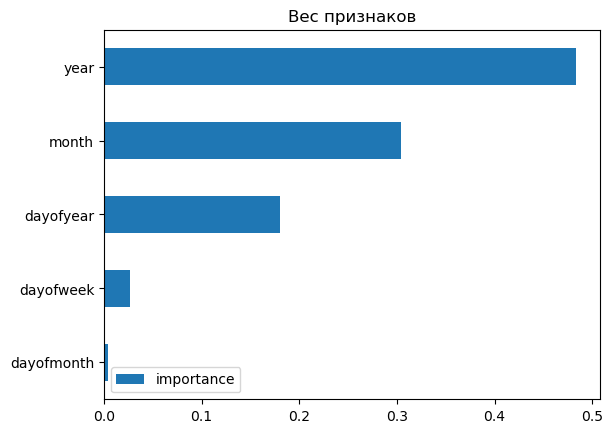

In [137]:
fi = pd.DataFrame(data=xgb_fmod[seg[0]][coll[0]].feature_importances_,
             index=xgb_fmod[seg[0]][coll[0]].feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Вес признаков')
plt.show()

In [138]:
# прогнозирование на тестовых данных
x_train_pred = {}
x_test_pred = {}

for j in range (0, 6):
    x_train_pred[seg[j]] = {}    
    x_test_pred[seg[j]] = {}
    for i in range (0, 4):
        x_train_pred[seg[j]][coll[i]] = pd.Series(data = xgb_fmod[seg[j]][coll[i]].predict(x_trainX[seg[j]][coll[i]]), 
                                                  index=x_trainY[seg[j]][coll[i]].index)
        x_test_pred[seg[j]][coll[i]] = pd.Series(data = xgb_fmod[seg[j]][coll[i]].predict(x_testX[seg[j]][coll[i]]), 
                                                index=x_testY[seg[j]][coll[i]].index)
        print(seg[j], coll[i])
        trainScore = math.sqrt(mean_squared_error(x_trainY[seg[j]][coll[i]], x_train_pred[seg[j]][coll[i]]))
        testScore = math.sqrt(mean_squared_error(x_testY[seg[j]][coll[i]], x_test_pred[seg[j]][coll[i]]))
        print('Train Score: %.2f RMSE' % (trainScore))
        print('Test Score: %.2f RMSE' % (testScore))
        print('Test MAPE: %.2f' % (mape(x_testY[seg[j]][coll[i]], x_test_pred[seg[j]][coll[i]])))


DOM INT PAX
Train Score: 2285.27 RMSE
Test Score: 397.14 RMSE
Test MAPE: 0.29
DOM INT MTOW
Train Score: 1502.95 RMSE
Test Score: 166.57 RMSE
Test MAPE: 0.24
DOM INT LF
Train Score: 10.71 RMSE
Test Score: 11.78 RMSE
Test MAPE: 0.13
DOM INT ATM
Train Score: 15.93 RMSE
Test Score: 1.90 RMSE
Test MAPE: 0.23
DOM MOW PAX
Train Score: 830.62 RMSE
Test Score: 889.81 RMSE
Test MAPE: 0.15
DOM MOW MTOW
Train Score: 476.07 RMSE
Test Score: 693.62 RMSE
Test MAPE: 0.23
DOM MOW LF
Train Score: 6.01 RMSE
Test Score: 8.95 RMSE
Test MAPE: 0.10
DOM MOW ATM
Train Score: 6.10 RMSE
Test Score: 9.95 RMSE
Test MAPE: 0.25
DOM REG PAX
Train Score: 983.38 RMSE
Test Score: 1007.90 RMSE
Test MAPE: 0.07
DOM REG MTOW
Train Score: 486.96 RMSE
Test Score: 830.99 RMSE
Test MAPE: 0.12
DOM REG LF
Train Score: 3.69 RMSE
Test Score: 4.55 RMSE
Test MAPE: 0.05
DOM REG ATM
Train Score: 7.23 RMSE
Test Score: 13.03 RMSE
Test MAPE: 0.13
INT BEL PAX
Train Score: 93.32 RMSE
Test Score: 59.03 RMSE
Test MAPE: 0.15
INT BEL MTOW
Train

range(0, 32)


range(0, 107)


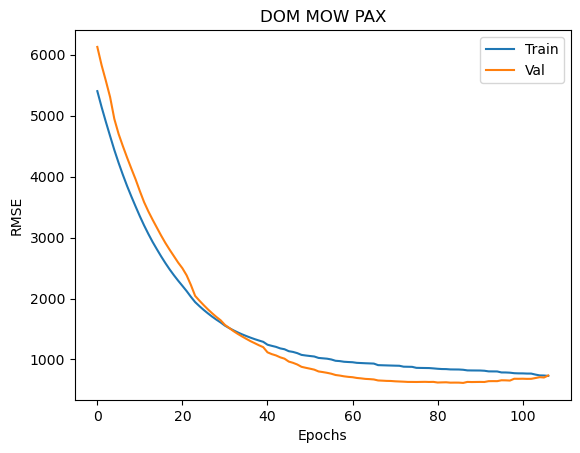

range(0, 247)


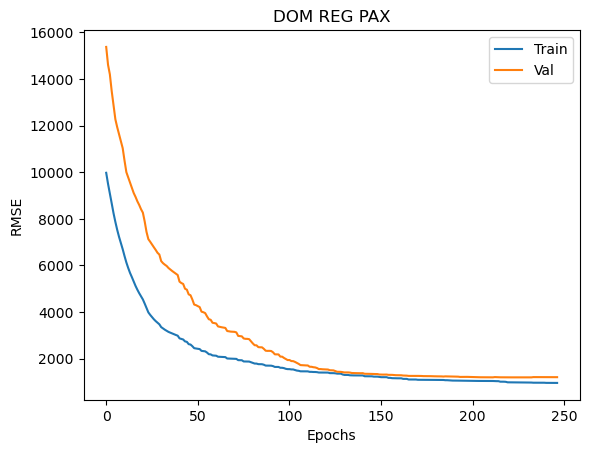

range(0, 72)


range(0, 61)


range(0, 67)


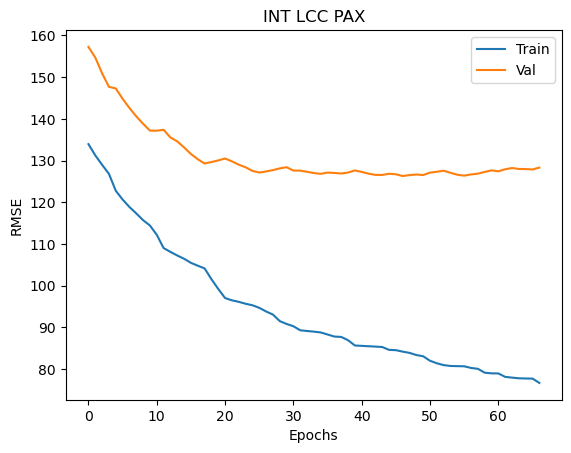

In [139]:
per_pred = {}

for j in range (0, 6):
    per_pred[seg[j]] = {}    
    for i in range (0, 1):
        # retrieve performance metrics
        per_pred[seg[j]][coll[i]] = xgb_fmod[seg[j]][coll[i]].evals_result()
        epochs = len(per_pred[seg[j]][coll[i]]['validation_0']['rmse'])
        x_axis = range(0, epochs)
        print (x_axis)
        fig, ax = plt.subplots()
        ax.plot(x_axis, per_pred[seg[j]][coll[i]]['validation_0']['rmse'], label='Train')
        ax.plot(x_axis, per_pred[seg[j]][coll[i]]['validation_1']['rmse'], label='Val')
        ax.legend()
        plt.ylabel('RMSE')
        plt.xlabel('Epochs')
        plt.title(seg[j] + ' ' + coll[i])
        plt.show()

In [140]:
xgb_all2 = copy.deepcopy(xgb_all)
for j in range (0, 6):   
    for i in range (0, 4):
        xgb_all2[seg[j]][coll[i]] = xgb_all2[seg[j]][coll[i]].merge(pd.DataFrame(x_test_pred[seg[j]][coll[i]]), 
                                                          how='left', left_index=True, right_index=True)



In [141]:
xgb_all2[seg[0]]

{'PAX':                PAX           0
 Time                          
 2015-01-01  4250.0         NaN
 2015-01-02  4118.0         NaN
 2015-01-03  4979.0         NaN
 2015-01-04  4847.0         NaN
 2015-01-05  3945.0         NaN
 ...            ...         ...
 2022-12-08  1092.0  695.299744
 2022-12-09   796.0  682.899597
 2022-12-10  1316.0  767.845703
 2022-12-11  1190.0  767.845703
 2022-12-12   759.0  604.364197
 
 [2903 rows x 2 columns],
 'MTOW':                 MTOW           0
 Time                            
 2015-01-01  2680.335         NaN
 2015-01-02  2370.556         NaN
 2015-01-03  2823.500         NaN
 2015-01-04  2945.733         NaN
 2015-01-05  2351.998         NaN
 ...              ...         ...
 2022-12-08   498.500  387.674988
 2022-12-09   387.296  378.750061
 2022-12-10   604.700  446.169250
 2022-12-11   563.530  417.089539
 2022-12-12   405.000  366.884918
 
 [2903 rows x 2 columns],
 'LF':                    LF          0
 Time                          

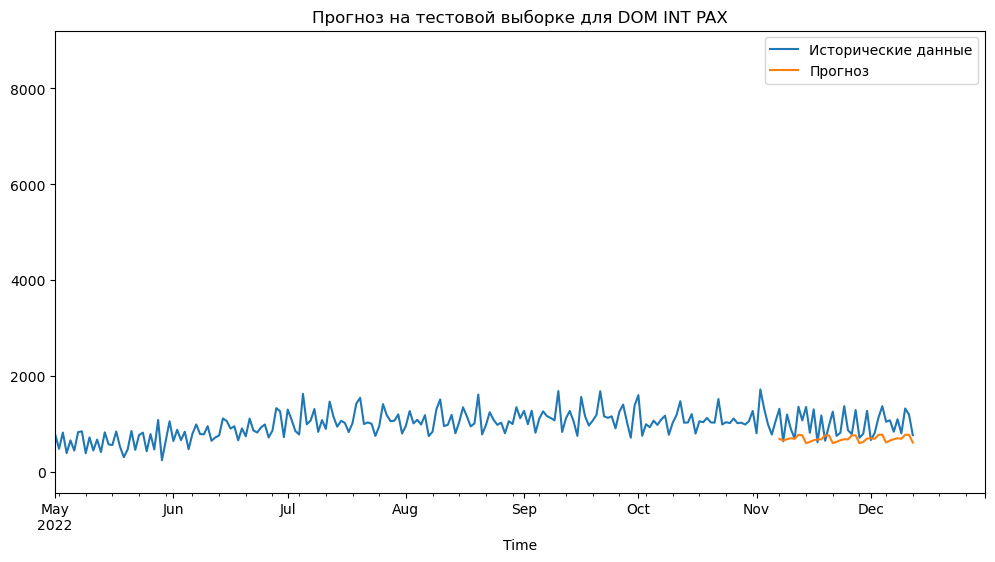

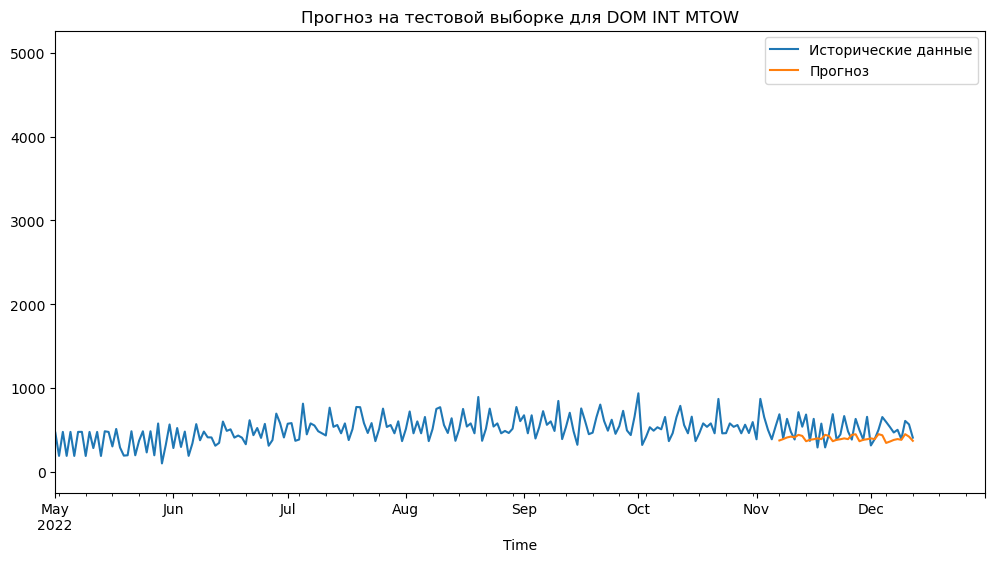

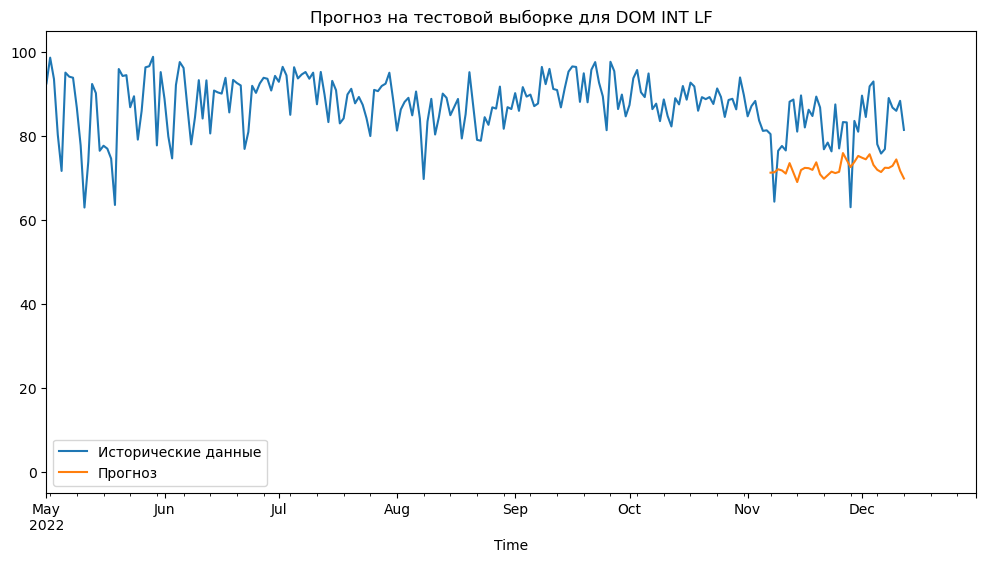

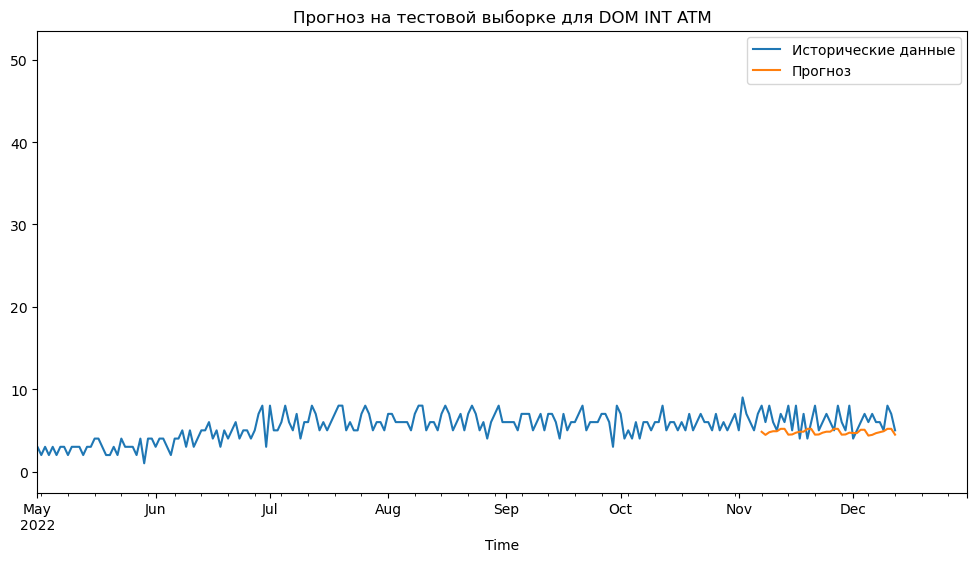

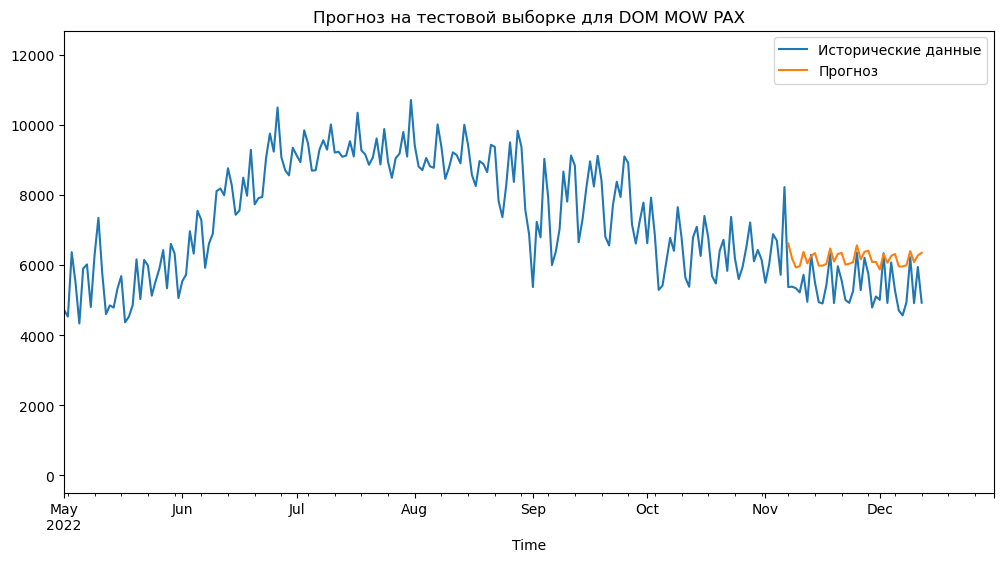

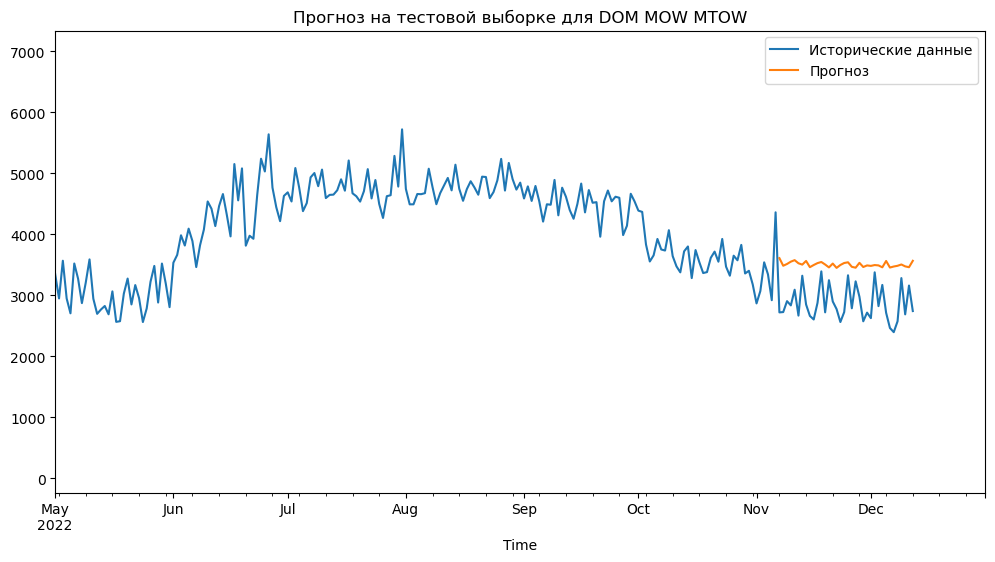

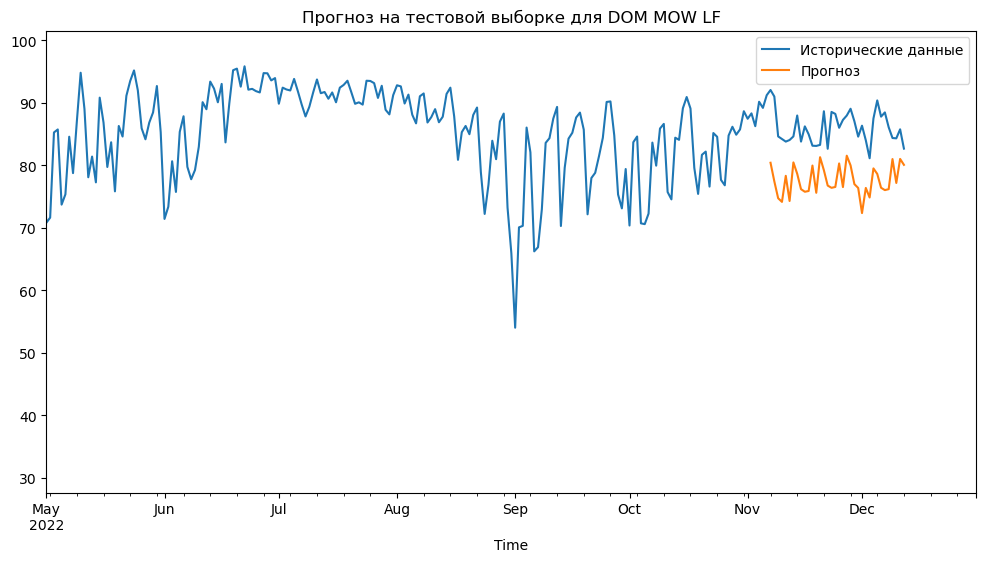

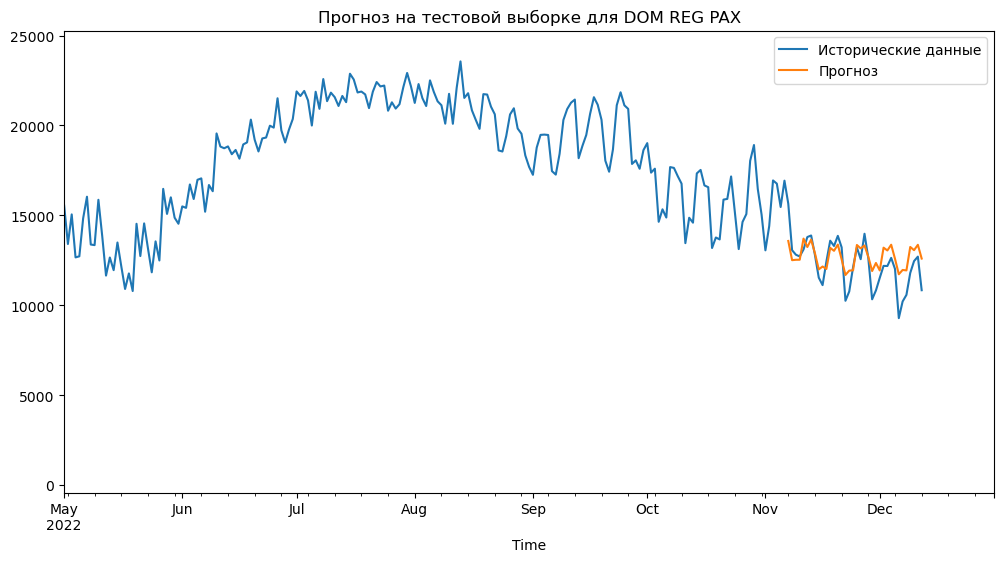

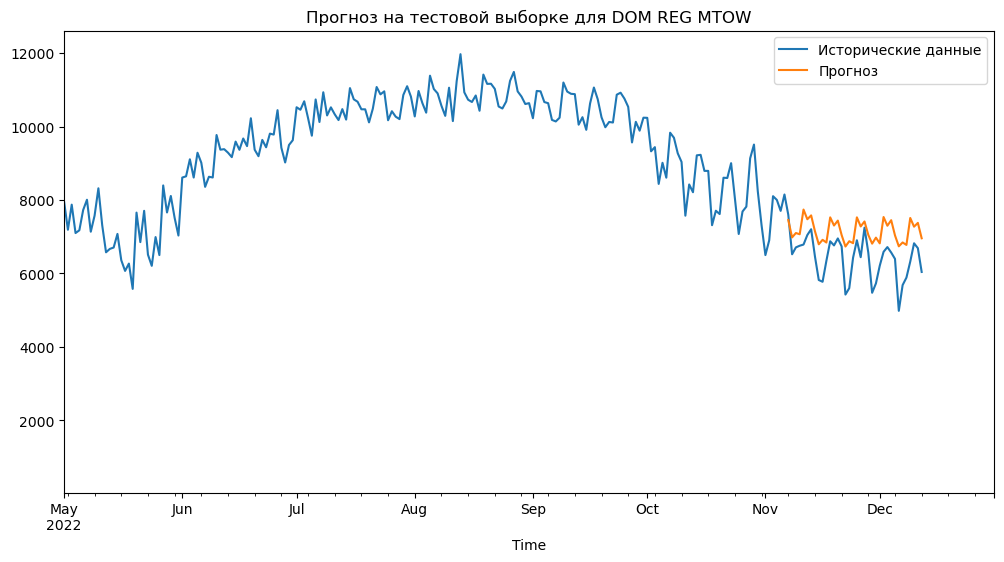

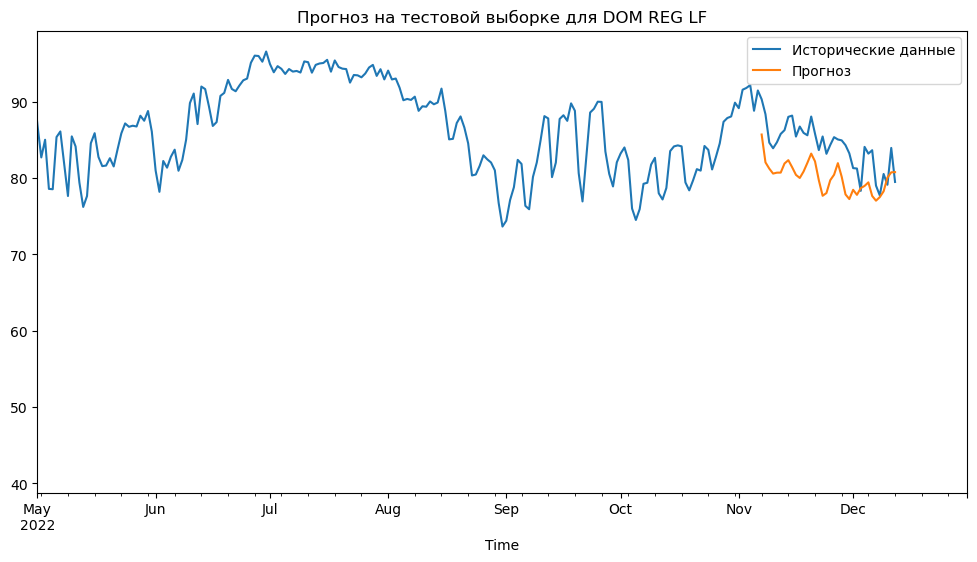

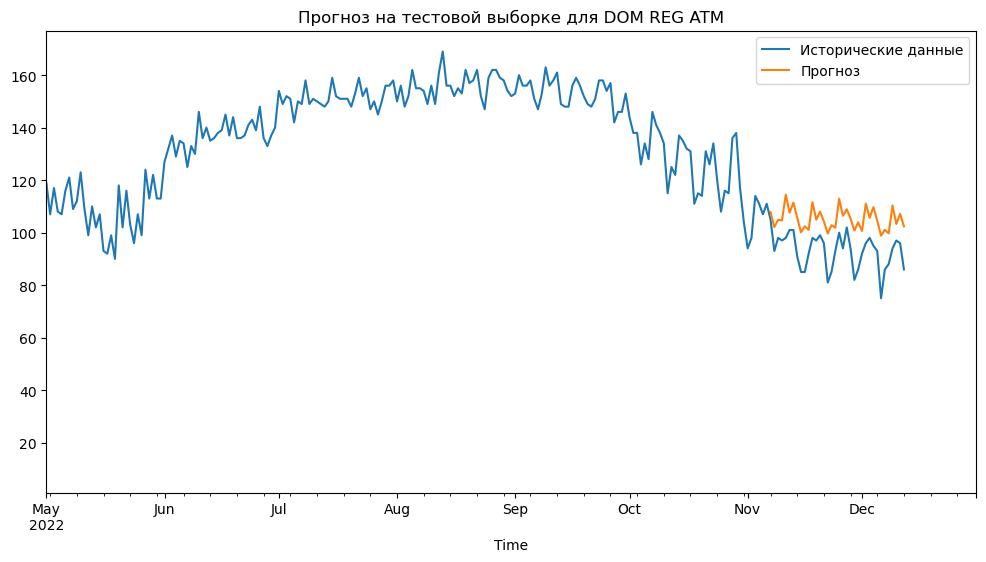

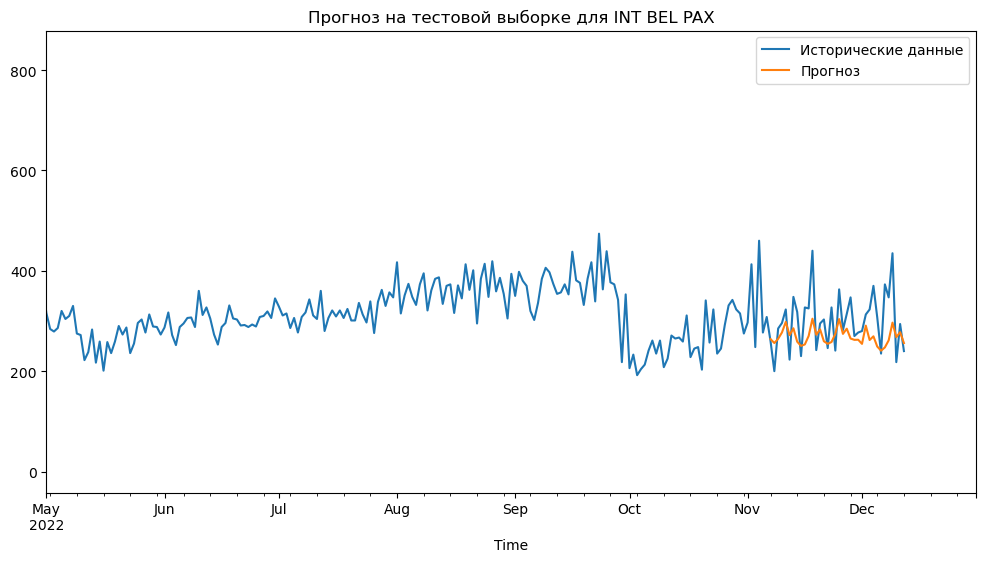

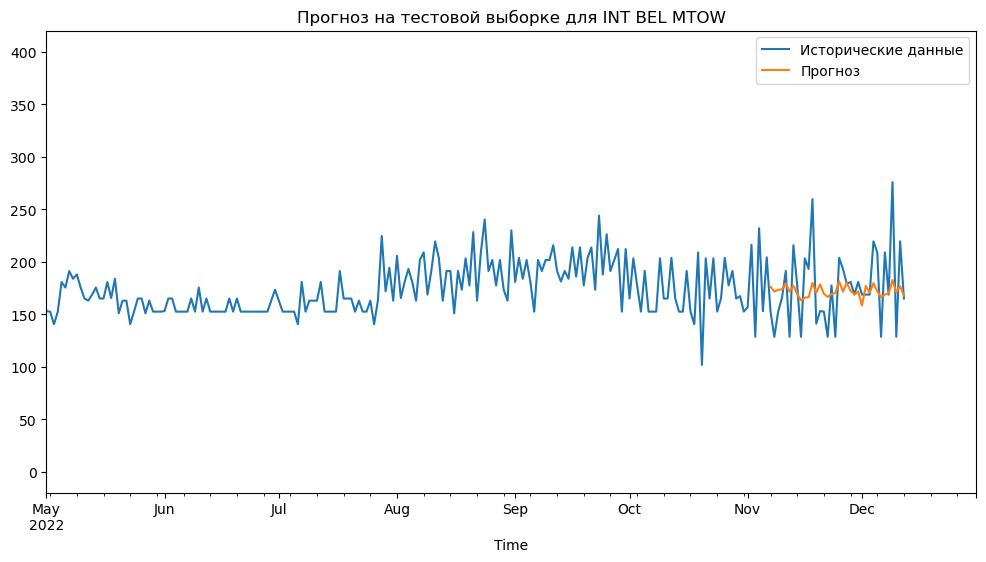

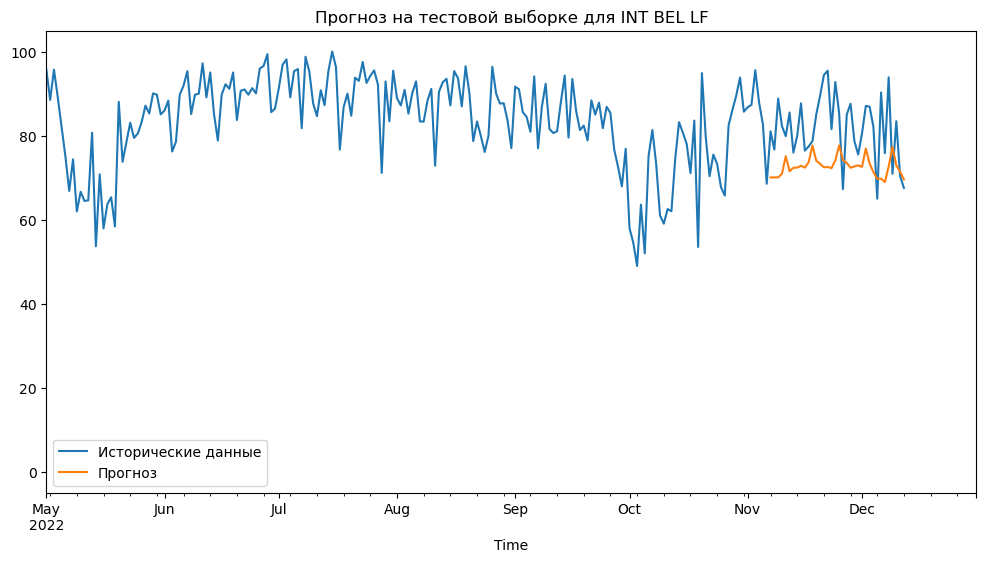

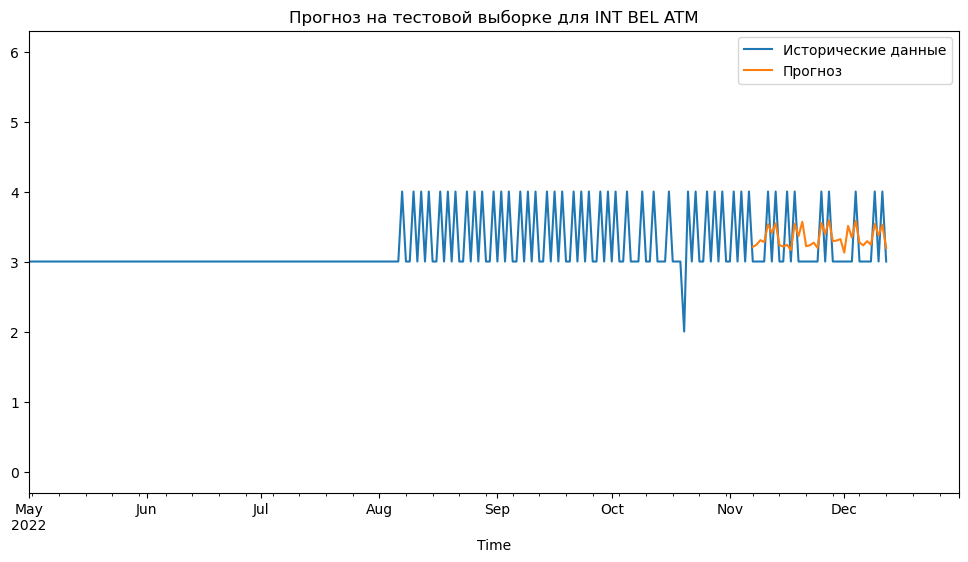

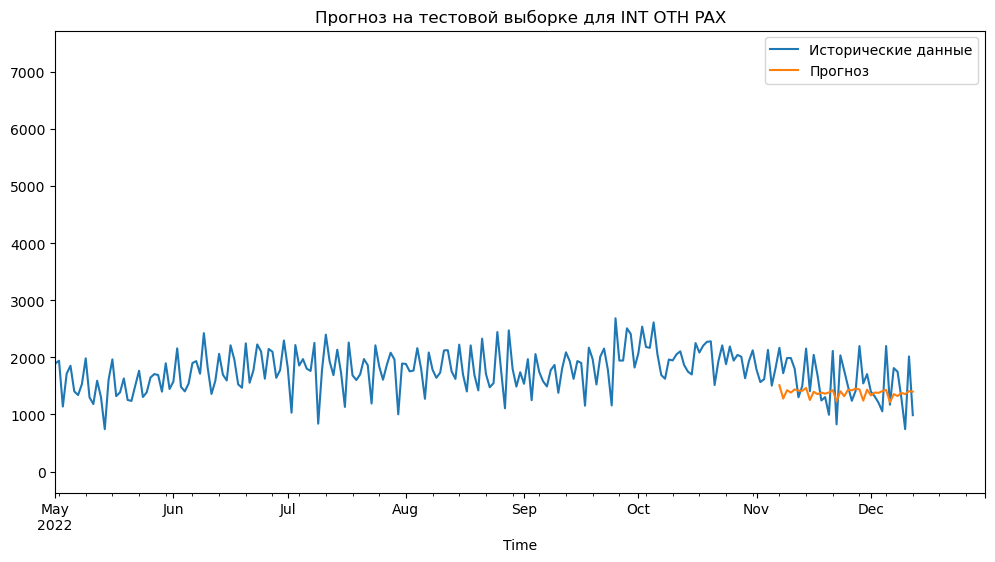

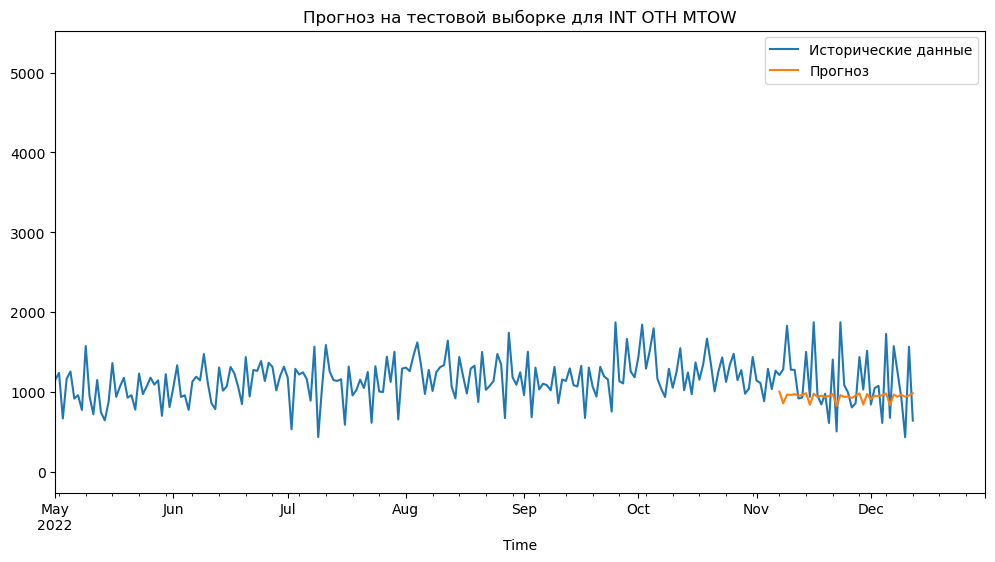

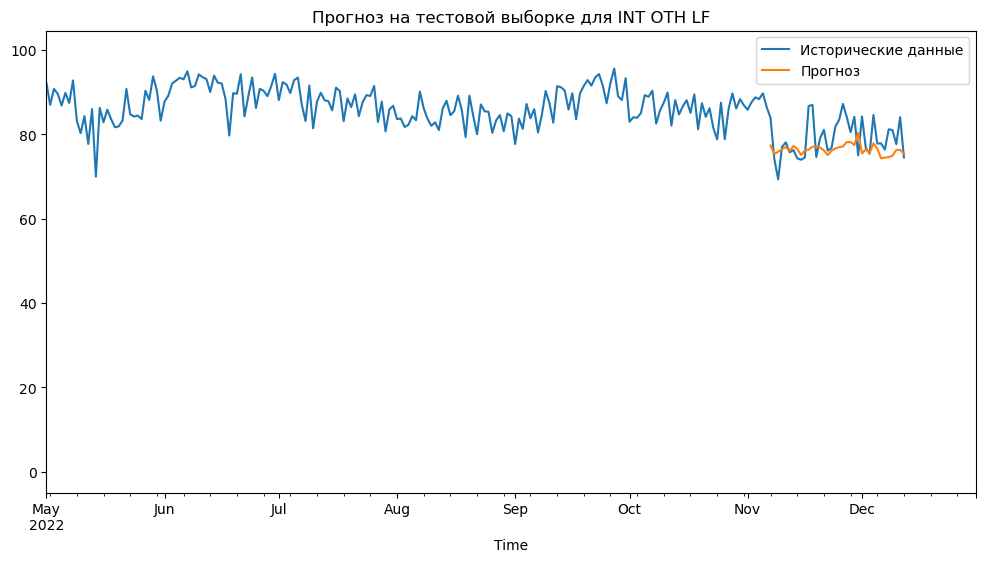

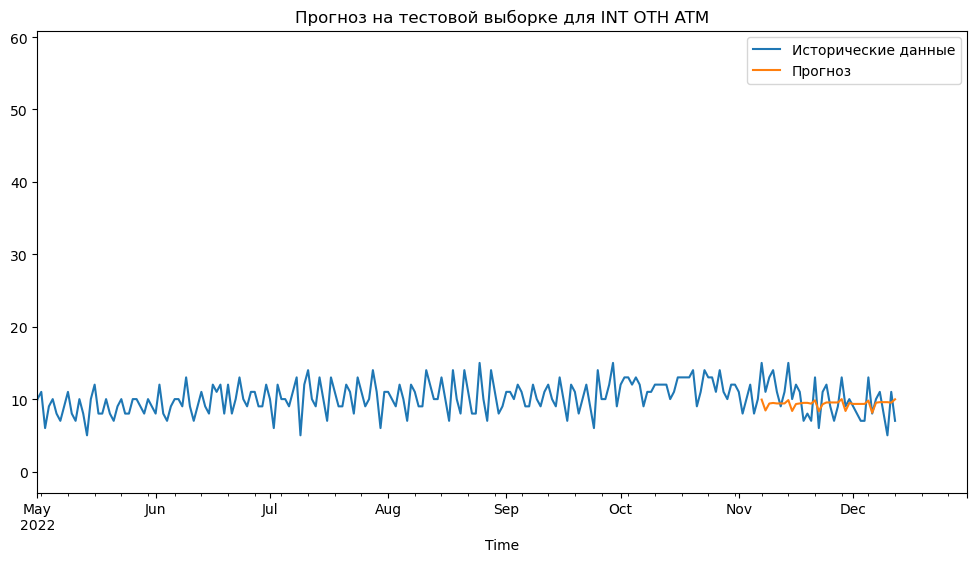

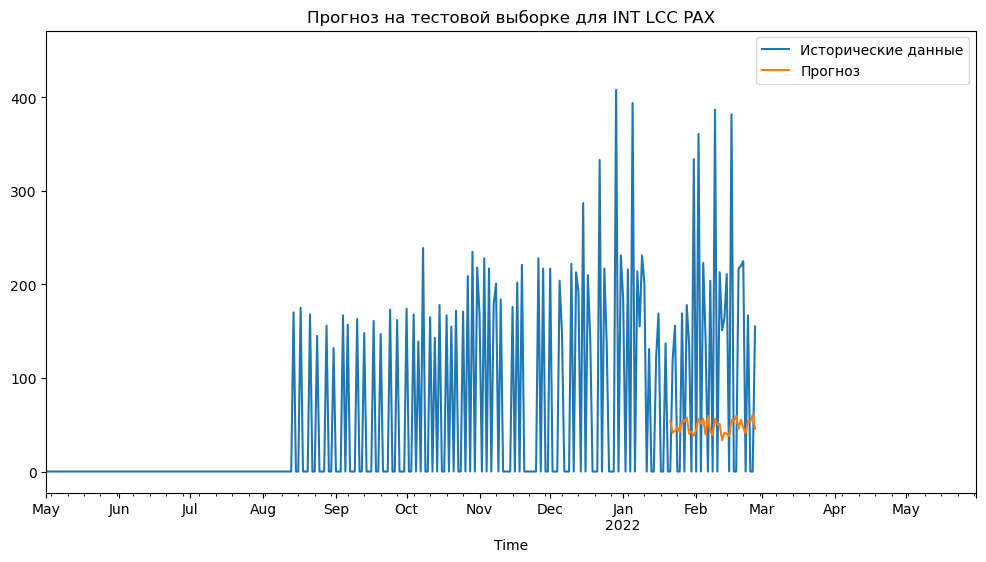

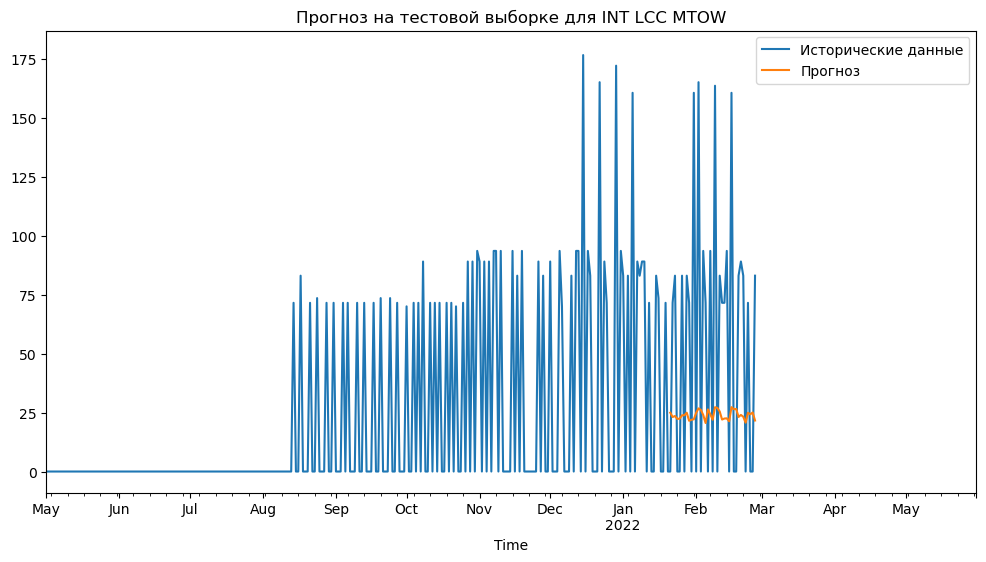

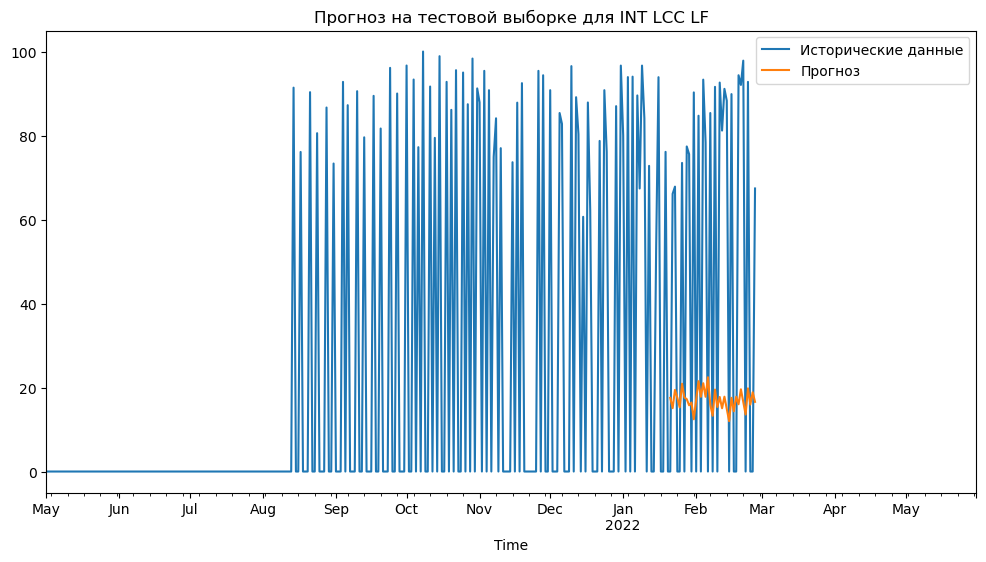

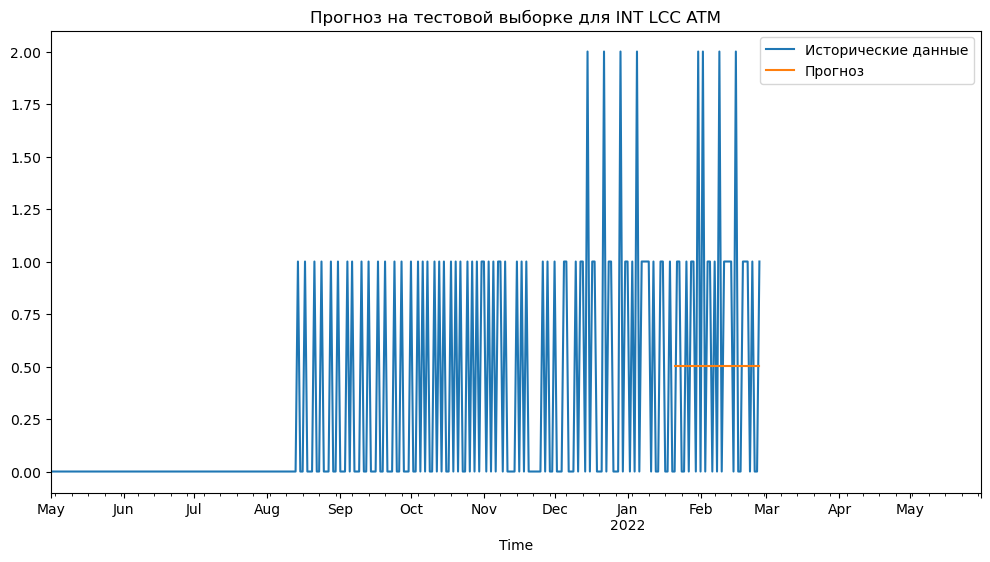

In [147]:
for j in range (0, 6):   
    for i in range (0, 4): 
        
        ax = xgb_all2[seg[j]][coll[i]][coll[i]].plot(figsize=(12, 6))
        xgb_all2[seg[j]][coll[i]][0].plot(ax=ax)
        plt.legend(['Исторические данные', 'Прогноз'])
        if j !=5:
            ax.set_xlim([datetime.date(2022, 5, 1), datetime.date(2022, 12, 31)])
        else:
            ax.set_xlim([datetime.date(2021, 5, 1), datetime.date(2022, 5, 31)])
        ax.set_title('Прогноз на тестовой выборке для ' + seg[j] + ' ' + coll[i])
        
        plt.show()

## Оценка наивной модели

In [103]:
%store -r dict_all1
import datetime as dt

In [86]:
print('DOM INT')
print(round(mape(dict_all['DOM INT']['LF'][(dict_all['DOM INT']['LF']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM INT']['LF']['Time'].dt.date < dt.date(2022, 10, 30))]['LF'], dict_all1['DOM-INT']['LF']['LF']), 2))
print(round(mape(dict_all['DOM INT']['PAX'][(dict_all['DOM INT']['PAX']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM INT']['PAX']['Time'].dt.date < dt.date(2022, 10, 30))]['PAX'], dict_all1['DOM-INT']['PAX']['PAX']), 2))
print('DOM MOW')
print(round(mape(dict_all['DOM MOW']['LF'][(dict_all['DOM MOW']['LF']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM MOW']['LF']['Time'].dt.date < dt.date(2022, 10, 30))]['LF'], dict_all1['DOM-MSC']['LF']['LF']), 2))
print(round(mape(dict_all['DOM MOW']['PAX'][(dict_all['DOM MOW']['PAX']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM MOW']['PAX']['Time'].dt.date < dt.date(2022, 10, 30))]['PAX'], dict_all1['DOM-MSC']['PAX']['PAX']), 2))
print('DOM REG')
print(round(mape(dict_all['DOM REG']['LF'][(dict_all['DOM REG']['LF']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM REG']['LF']['Time'].dt.date < dt.date(2022, 10, 30))]['LF'], dict_all1['DOM-REG']['LF']['LF']), 2))
print(round(mape(dict_all['DOM REG']['PAX'][(dict_all['DOM REG']['PAX']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM REG']['PAX']['Time'].dt.date < dt.date(2022, 10, 30))]['PAX'], dict_all1['DOM-REG']['PAX']['PAX']), 2))
print('INT OTH')
print(round(mape(dict_all['INT OTH']['LF'][(dict_all['INT OTH']['LF']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['INT OTH']['LF']['Time'].dt.date < dt.date(2022, 10, 30))]['LF'], dict_all1['INT-OTH']['LF']['LF']), 2))
print(round(mape(dict_all['INT OTH']['PAX'][(dict_all['INT OTH']['PAX']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['INT OTH']['PAX']['Time'].dt.date < dt.date(2022, 10, 30))]['PAX'], dict_all1['INT-OTH']['PAX']['PAX']), 2))
print('INT BEL')
print(round(mape(dict_all['INT BEL']['LF'][(dict_all['INT BEL']['LF']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['INT BEL']['LF']['Time'].dt.date < dt.date(2022, 10, 30))]['LF'], dict_all1['INT-BEL']['LF']['LF']), 2))
print(round(mape(dict_all['INT BEL']['PAX'][(dict_all['INT BEL']['PAX']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['INT BEL']['PAX']['Time'].dt.date < dt.date(2022, 10, 30))]['PAX'], dict_all1['INT-BEL']['PAX']['PAX']), 2))

DOM INT
0.38
0.21
DOM MOW
0.07
0.65
DOM REG
0.05
0.82
INT OTH
0.36
0.31
INT BEL
0.22
0.41


In [96]:
# прогноз на другом месяце
print('DOM INT')
print(round(mape(dict_all['DOM INT']['LF'][(dict_all['DOM INT']['LF']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM INT']['LF']['Time'].dt.date < dt.date(2022, 10, 30))]['LF'], dict_all1['DOM-INT']['LF']['LF']), 2))
print(round(mape(dict_all['DOM INT']['PAX'][(dict_all['DOM INT']['PAX']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM INT']['PAX']['Time'].dt.date < dt.date(2022, 10, 30))]['PAX'], dict_all1['DOM-INT']['PAX']['PAX']), 2))
print('DOM MOW')
print(round(mape(dict_all['DOM MOW']['LF'][(dict_all['DOM MOW']['LF']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM MOW']['LF']['Time'].dt.date < dt.date(2022, 10, 30))]['LF'], dict_all1['DOM-MSC']['LF']['LF']), 2))
print(round(mape(dict_all['DOM MOW']['PAX'][(dict_all['DOM MOW']['PAX']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM MOW']['PAX']['Time'].dt.date < dt.date(2022, 10, 30))]['PAX'], dict_all1['DOM-MSC']['PAX']['PAX']), 2))
print('DOM REG')
print(round(mape(dict_all['DOM REG']['LF'][(dict_all['DOM REG']['LF']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM REG']['LF']['Time'].dt.date < dt.date(2022, 10, 30))]['LF'], dict_all1['DOM-REG']['LF']['LF']), 2))
print(round(mape(dict_all['DOM REG']['PAX'][(dict_all['DOM REG']['PAX']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM REG']['PAX']['Time'].dt.date < dt.date(2022, 10, 30))]['PAX'], dict_all1['DOM-REG']['PAX']['PAX']), 2))
print('INT OTH')
print(round(mape(dict_all['INT OTH']['LF'][(dict_all['INT OTH']['LF']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['INT OTH']['LF']['Time'].dt.date < dt.date(2022, 10, 30))]['LF'], dict_all1['INT-OTH']['LF']['LF']), 2))
print(round(mape(dict_all['INT OTH']['PAX'][(dict_all['INT OTH']['PAX']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['INT OTH']['PAX']['Time'].dt.date < dt.date(2022, 10, 30))]['PAX'], dict_all1['INT-OTH']['PAX']['PAX']), 2))
print('INT BEL')
print(round(mape(dict_all['INT BEL']['LF'][(dict_all['INT BEL']['LF']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['INT BEL']['LF']['Time'].dt.date < dt.date(2022, 10, 30))]['LF'], dict_all1['INT-BEL']['LF']['LF']), 2))
print(round(mape(dict_all['INT BEL']['PAX'][(dict_all['INT BEL']['PAX']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['INT BEL']['PAX']['Time'].dt.date < dt.date(2022, 10, 30))]['PAX'], dict_all1['INT-BEL']['PAX']['PAX']), 2))

DOM INT
0.13
0.59
DOM MOW
0.07
0.69
DOM REG
0.05
1.02
INT OTH
0.28
0.43
INT BEL
0.16
0.9


In [100]:
# прогноз на другом месяце
print('DOM INT')
print(round(mape(dict_all['DOM INT']['LF'][(dict_all['DOM INT']['LF']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM INT']['LF']['Time'].dt.date < dt.date(2022, 10, 30))]['LF'], dict_all1['DOM-INT']['LF']['LF']), 2))
print(round(mape(dict_all['DOM INT']['PAX'][(dict_all['DOM INT']['PAX']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM INT']['PAX']['Time'].dt.date < dt.date(2022, 10, 30))]['PAX'], dict_all1['DOM-INT']['PAX']['PAX']), 2))
print('DOM MOW')
print(round(mape(dict_all['DOM MOW']['LF'][(dict_all['DOM MOW']['LF']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM MOW']['LF']['Time'].dt.date < dt.date(2022, 10, 30))]['LF'], dict_all1['DOM-MSC']['LF']['LF']), 2))
print(round(mape(dict_all['DOM MOW']['PAX'][(dict_all['DOM MOW']['PAX']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM MOW']['PAX']['Time'].dt.date < dt.date(2022, 10, 30))]['PAX'], dict_all1['DOM-MSC']['PAX']['PAX']), 2))
print('DOM REG')
print(round(mape(dict_all['DOM REG']['LF'][(dict_all['DOM REG']['LF']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM REG']['LF']['Time'].dt.date < dt.date(2022, 10, 30))]['LF'], dict_all1['DOM-REG']['LF']['LF']), 2))
print(round(mape(dict_all['DOM REG']['PAX'][(dict_all['DOM REG']['PAX']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM REG']['PAX']['Time'].dt.date < dt.date(2022, 10, 30))]['PAX'], dict_all1['DOM-REG']['PAX']['PAX']), 2))
print('INT OTH')
print(round(mape(dict_all['INT OTH']['LF'][(dict_all['INT OTH']['LF']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['INT OTH']['LF']['Time'].dt.date < dt.date(2022, 10, 30))]['LF'], dict_all1['INT-OTH']['LF']['LF']), 2))
print(round(mape(dict_all['INT OTH']['PAX'][(dict_all['INT OTH']['PAX']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['INT OTH']['PAX']['Time'].dt.date < dt.date(2022, 10, 30))]['PAX'], dict_all1['INT-OTH']['PAX']['PAX']), 2))
print('INT BEL')
print(round(mape(dict_all['INT BEL']['LF'][(dict_all['INT BEL']['LF']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['INT BEL']['LF']['Time'].dt.date < dt.date(2022, 10, 30))]['LF'], dict_all1['INT-BEL']['LF']['LF']), 2))
print(round(mape(dict_all['INT BEL']['PAX'][(dict_all['INT BEL']['PAX']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['INT BEL']['PAX']['Time'].dt.date < dt.date(2022, 10, 30))]['PAX'], dict_all1['INT-BEL']['PAX']['PAX']), 2))

DOM INT
0.3
0.33
DOM MOW
0.12
0.51
DOM REG
0.04
0.89
INT OTH
0.35
0.3
INT BEL
0.22
0.41


In [104]:
# прогноз на другом месяце
print('DOM INT')
print(round(mape(dict_all['DOM INT']['LF'][(dict_all['DOM INT']['LF']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM INT']['LF']['Time'].dt.date < dt.date(2022, 10, 30))]['LF'], dict_all1['DOM-INT']['LF']['LF']), 2))
print(round(mape(dict_all['DOM INT']['PAX'][(dict_all['DOM INT']['PAX']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM INT']['PAX']['Time'].dt.date < dt.date(2022, 10, 30))]['PAX'], dict_all1['DOM-INT']['PAX']['PAX']), 2))
print('DOM MOW')
print(round(mape(dict_all['DOM MOW']['LF'][(dict_all['DOM MOW']['LF']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM MOW']['LF']['Time'].dt.date < dt.date(2022, 10, 30))]['LF'], dict_all1['DOM-MSC']['LF']['LF']), 2))
print(round(mape(dict_all['DOM MOW']['PAX'][(dict_all['DOM MOW']['PAX']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM MOW']['PAX']['Time'].dt.date < dt.date(2022, 10, 30))]['PAX'], dict_all1['DOM-MSC']['PAX']['PAX']), 2))
print('DOM REG')
print(round(mape(dict_all['DOM REG']['LF'][(dict_all['DOM REG']['LF']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM REG']['LF']['Time'].dt.date < dt.date(2022, 10, 30))]['LF'], dict_all1['DOM-REG']['LF']['LF']), 2))
print(round(mape(dict_all['DOM REG']['PAX'][(dict_all['DOM REG']['PAX']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['DOM REG']['PAX']['Time'].dt.date < dt.date(2022, 10, 30))]['PAX'], dict_all1['DOM-REG']['PAX']['PAX']), 2))
print('INT OTH')
print(round(mape(dict_all['INT OTH']['LF'][(dict_all['INT OTH']['LF']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['INT OTH']['LF']['Time'].dt.date < dt.date(2022, 10, 30))]['LF'], dict_all1['INT-OTH']['LF']['LF']), 2))
print(round(mape(dict_all['INT OTH']['PAX'][(dict_all['INT OTH']['PAX']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['INT OTH']['PAX']['Time'].dt.date < dt.date(2022, 10, 30))]['PAX'], dict_all1['INT-OTH']['PAX']['PAX']), 2))
print('INT BEL')
print(round(mape(dict_all['INT BEL']['LF'][(dict_all['INT BEL']['LF']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['INT BEL']['LF']['Time'].dt.date < dt.date(2022, 10, 30))]['LF'], dict_all1['INT-BEL']['LF']['LF']), 2))
print(round(mape(dict_all['INT BEL']['PAX'][(dict_all['INT BEL']['PAX']['Time'].dt.date >= dt.date(2022, 10, 1))&(dict_all['INT BEL']['PAX']['Time'].dt.date < dt.date(2022, 10, 30))]['PAX'], dict_all1['INT-BEL']['PAX']['PAX']), 2))

DOM INT
0.17
0.67
DOM MOW
0.09
0.84
DOM REG
0.03
0.91
INT OTH
0.09
0.8
INT BEL
0.19
1.03


----